# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
from IPython.core.debugger import Tracer # For debugging purposes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


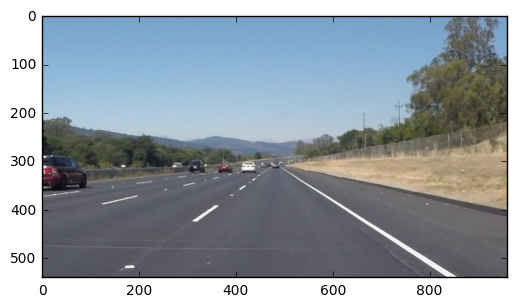

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [20]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lane = []
    right_lane = []
    left_x_coordinates = []
    left_y_coordinates = []
    right_x_coordinates = []
    right_y_coordinates = []
    y_min=320
    y_max=img.shape[0]
    # Was encountering Nan's due to collecting values that were outside the lane 
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x2-x1) == 0:
                continue
            slope = (y2-y1)/(x2-x1)
            if 0.8 > slope > 0.4: 
                left_lane.append(slope) 
                left_x_coordinates.append([x1,x2])
                left_y_coordinates.append([y1,y2])
            elif -0.8 < slope < -0.6:
                right_lane.append(slope)
                right_x_coordinates.append([x1,x2])
                right_y_coordinates.append([y1,y2])
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
          
    left_slope_average = np.mean(np.array(left_lane))
    right_slope_average = np.mean(np.array(right_lane))
    # Ravel is faster than flatten
    left_x_average = np.mean(np.array(left_x_coordinates).ravel())
    left_y_average = np.mean(np.array(left_y_coordinates).ravel())
    right_x_average = np.mean(np.array(right_x_coordinates).ravel()) 
    right_y_average = np.mean(np.array(right_y_coordinates).ravel())
    
    
    
    ## Calculate intercept 
    left_intercept = left_y_average - (left_slope_average * left_x_average)
    right_intercept = right_y_average - (right_slope_average * right_x_average)
    
    
    # Highest points for final exterpolation
    
    x1_left=(y_min-left_intercept)/left_slope_average
    x2_left=(y_max-left_intercept)/left_slope_average
    x1_right=(y_min-right_intercept)/right_slope_average
    x2_right=(y_max-right_intercept)/right_slope_average
    
    if ((not np.isnan(right_slope_average)) and (not np.isnan(left_slope_average)) ):
        print("Average right_slope average is " , right_slope_average)
        print("right line 1", (int((y_min - left_intercept) /left_slope_average), int(y_min)), (int((y_max - left_intercept)/left_slope_average), int(y_max)))
        print("left line 2", (int((y_min - right_intercept)/right_slope_average), int(y_min)), (int((y_max - right_intercept)/right_slope_average), int(y_max)))
        #Tracer()() # < -- this starts the debugger here.

        # Draw Left Line 
        #print("Left X1,X2 is : "  +  x1_left + " " + x2_left)
    
        #print("Right X1,X2 is : "  + x1_right + " " + x2_right)
        cv2.line(img, (int(x1_left), y_min), (int(x2_left), y_max), color, thickness)
    
        # Draw Right Line
    
        cv2.line(img, (int(x1_right), y_min), (int(x2_right), y_max), color, thickness)
    
    
    #print(left_x_coordinates)
            
        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def select_white(image):
    color_select  = np.copy(image)
    red_threshold = 190
    blue_threshold = 190
    green_threshold = 190
    rgb_threshold = [red_threshold,blue_threshold,green_threshold]
    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
            |(image[:,:,1] < rgb_threshold[1]) \
            |(image[:,:,2] < rgb_threshold[2])

    color_select[thresholds] = [0,0,0]
    
    return color_select

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.



## First we will design our Pipelines as follows
Image --> GrayScale --> GaussianBlur kernel 5 --> Canny Edge Detection -> Hough Lines --> Weighted Image --> Output

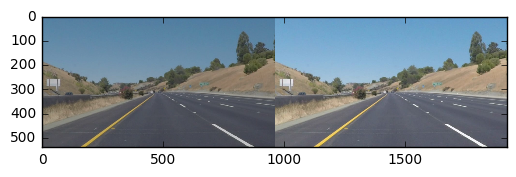

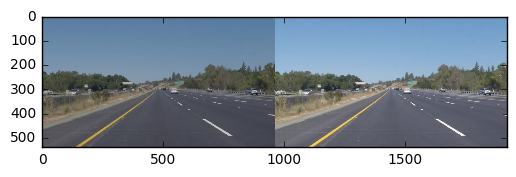

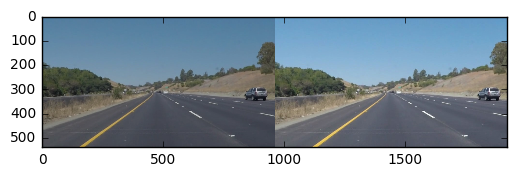

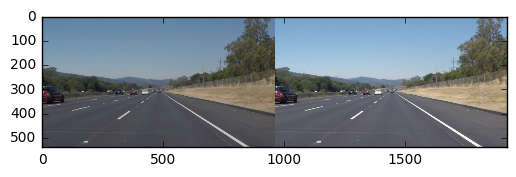

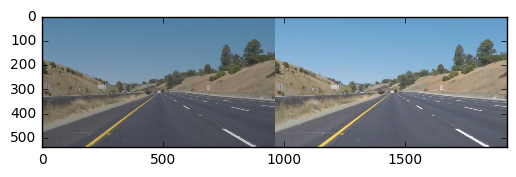

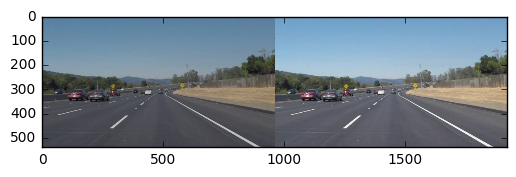

In [4]:
import os

def otsu_method(img):
    high_thresh, thresh_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh
    return [low_thresh,high_thresh]

def pipeline(image):
    imshape = image.shape
    gray = grayscale(image)
    blur = gaussian_blur(image,5) # Blur with a kernel size of 5
    # Calculate high and low threshold using otsu's method 
    low_thresh,high_thresh = otsu_method(gray)
    # Apply Canny Edge Detection
    ignore_mask_color = 255
    edges = canny(blur,low_thresh,high_thresh)
    mask = np.zeros_like(edges)
    line_image = hough_lines(edges,2,np.pi/180,30,10,7)
    res = weighted_img(line_image,image)
    mask = np.zeros_like(edges)
    vertices = np.array([[(0,imshape[0]),(450,320),(490,320),(imshape[1],imshape[0])]],dtype=np.int32)
    cv2.fillPoly(mask,vertices,ignore_mask_color)

    masked_edges = cv2.bitwise_and(edges,mask)
    lines = hough_lines(masked_edges,2,np.pi/360,100,90,150)
# Create binary color image
    color_edges = np.dstack((edges,edges,edges))
    line_edges = cv2.addWeighted(image,0.8,lines,1,0)
    return line_edges


images = os.listdir("test_images/")
for image in images:
    plt.figure()
    new_image = pipeline(mpimg.imread("test_images/" + image))
    original_image =mpimg.imread("test_images/" + image)
    plt.imshow(np.concatenate((new_image,original_image),axis=1),cmap="Greys_r")

Great now we can see Lines almost all of them but we need to restrict it's view only to Lanes. While we can use color to detect lanes that is not the best option in case lane changes color due to brightness and stuff or patches of road with faded color or lanes with different colors. Since in this example car hardly changes lanes we can use it our advantage and define a area under which it stays all the time.

But how we get coordinates for the endpoints ?
We can either guess or use some foreign packages to hover coordinates when pointed over a particular location

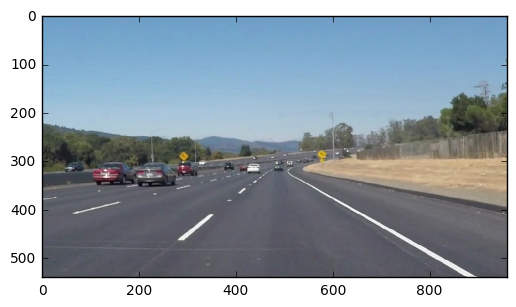

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import mpldatacursor


fig, ax = plt.subplots()
image= plt.imread('test_images/solidWhiteCurve.jpg')
ax.imshow(image, interpolation='none')
mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.show()

# For this to work, don't run it in Juypter but in command line with a Gui like Qt/TK based backend

In [63]:
# When we used above script to get the data, it is similar to this one
imshape = image.shape
gray = grayscale(image)
blur = gaussian_blur(image,5) # Blur with a kernel size of 5
    # Calculate high and low threshold using otsu's method 
low_thresh,high_thresh = otsu_method(gray)
    # Apply Canny Edge Detection
edges = canny(blur,low_thresh,high_thresh)
mask = np.zeros_like(edges)
ignore_mask_color = 255
bottom_left_corner = [166,539]
bottom_right_corner = [912,539]
upper_left_corner = [404,337]
upper_right_corner = [526,320]

#vertices = np.array([[bottom_left_corner,bottom_right_corner,upper_left_corner,upper_right_corner]],dtype=np.int32)
vertices = np.array([[(0,imshape[0]),(450,320),(490,320),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask,vertices,ignore_mask_color)

masked_edges = cv2.bitwise_and(edges,mask)
lines = hough_lines(masked_edges,2,np.pi/360,120,20,10)
# Create binary color image
color_edges = np.dstack((edges,edges,edges))
line_edges = cv2.addWeighted(image,0.8,lines,1,0)
plt.imshow(line_edges)


print(imshape)


AttributeError: 'str' object has no attribute 'shape'

Clearly hardcoding stuff is not a good way. Next approach is using a mixture of color section, possibly along with inRange to diverege between white and yellow and masking it Hough Transform to get the right frame.

In [ ]:
color_select  = np.copy(image)


## Threshold selection

red_threshold = 190
blue_threshold = 190
green_threshold = 190
rgb_threshold = [red_threshold,blue_threshold,green_threshold]

# Identify pixels below the threshold
thresholds = (image[:,:,0] < rgb_threshold[0]) \
        |(image[:,:,1] < rgb_threshold[1]) \
        |(image[:,:,2] < rgb_threshold[2])

color_select[thresholds] = [0,0,0]
final_image = np.concatenate((color_select,image),axis=1)
extra_image = pipeline(image)
plt.figure()
plt.imshow(final_image)
plt.imshow(extra_image)


We are looking for a easy way for now which is using vertices to define ROI


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def pipeline(image):
    imshape = image.shape
    gray = grayscale(image)
    blur = gaussian_blur(image,5) # Blur with a kernel size of 5
    # Calculate high and low threshold using otsu's method 
    low_thresh,high_thresh = otsu_method(gray)
    # Apply Canny Edge Detection
    ignore_mask_color = 255
    edges = canny(blur,low_thresh,high_thresh)
    mask = np.zeros_like(edges)
    line_image = hough_lines(edges,2,np.pi/180,100,10,7)
    res = weighted_img(line_image,image)
    mask = np.zeros_like(edges)
    vertices = np.array([[(0,imshape[0]),(450,320),(490,320),(imshape[1],imshape[0])]],dtype=np.int32)
    cv2.fillPoly(mask,vertices,ignore_mask_color)

    masked_edges = cv2.bitwise_and(edges,mask)
    lines = hough_lines(masked_edges,2,np.pi/360,100,90,150)
# Create binary color image
    color_edges = np.dstack((edges,edges,edges))
    line_edges = cv2.addWeighted(image,0.8,lines,1,0)
    plt.imshow(line_edges)
    return line_edges

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

Average right_slope average is  -0.693612351378
right line 1 (504, 320) (857, 540)
left line 2 (472, 320) (155, 540)
Average right_slope average is  -0.730161179965
right line 1 (508, 320) (860, 540)
left line 2 (457, 320) (156, 540)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4






  0%|          | 0/222 [00:00<?, ?it/s]

Average right_slope average is  -0.693612351378
right line 1 (504, 320) (857, 540)
left line 2 (472, 320) (155, 540)
Average right_slope average is  -0.730161179965
right line 1 (508, 320) (860, 540)
left line 2 (457, 320) (156, 540)






  0%|          | 1/222 [00:00<00:29,  7.55it/s]

Average right_slope average is  -0.688415158865
right line 1 (504, 320) (856, 540)
left line 2 (463, 320) (144, 540)
Average right_slope average is  -0.729246487867
right line 1 (505, 320) (860, 540)
left line 2 (455, 320) (153, 540)






  1%|          | 2/222 [00:00<00:30,  7.33it/s]

Average right_slope average is  -0.689644058253
right line 1 (503, 320) (862, 540)
left line 2 (464, 320) (145, 540)
Average right_slope average is  -0.730096821757
right line 1 (503, 320) (859, 540)
left line 2 (455, 320) (153, 540)






  1%|▏         | 3/222 [00:00<00:30,  7.12it/s]

Average right_slope average is  -0.681613793563
right line 1 (502, 320) (859, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.734180433677
right line 1 (502, 320) (859, 540)
left line 2 (456, 320) (156, 540)






  2%|▏         | 4/222 [00:00<00:31,  6.86it/s]

Average right_slope average is  -0.682284356593
right line 1 (505, 320) (862, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.701298701299
right line 1 (503, 320) (863, 540)
left line 2 (456, 320) (142, 540)






  2%|▏         | 5/222 [00:00<00:31,  6.91it/s]

Average right_slope average is  -0.675103612048
right line 1 (504, 320) (865, 540)
left line 2 (466, 320) (140, 540)
Average right_slope average is  -0.7169016977
right line 1 (505, 320) (862, 540)
left line 2 (457, 320) (150, 540)






  3%|▎         | 6/222 [00:00<00:29,  7.29it/s]



  3%|▎         | 7/222 [00:00<00:28,  7.58it/s]

Average right_slope average is  -0.676409895294
right line 1 (504, 320) (863, 540)
left line 2 (464, 320) (139, 540)
Average right_slope average is  -0.722555450624
right line 1 (500, 320) (867, 540)
left line 2 (457, 320) (152, 540)


Average right_slope average is  -0.678260451466
right line 1 (505, 320) (870, 540)
left line 2 (461, 320) (136, 540)
Average right_slope average is  -0.726113013699
right line 1 (503, 320) (864, 540)
left line 2 (456, 320) (153, 540)






  4%|▎         | 8/222 [00:01<00:35,  6.08it/s]



  4%|▍         | 9/222 [00:01<00:33,  6.43it/s]



  5%|▍         | 10/222 [00:01<00:31,  6.69it/s]

Average right_slope average is  -0.690036535225
right line 1 (503, 320) (862, 540)
left line 2 (463, 320) (144, 540)
Average right_slope average is  -0.713836781471
right line 1 (504, 320) (866, 540)
left line 2 (458, 320) (150, 540)
Average right_slope average is  -0.68230889186
right line 1 (501, 320) (856, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.724171686747
right line 1 (500, 320) (853, 540)
left line 2 (459, 320) (155, 540)






  5%|▍         | 11/222 [00:01<00:30,  6.92it/s]



  5%|▌         | 12/222 [00:01<00:28,  7.27it/s]

Average right_slope average is  -0.693693873034
right line 1 (495, 320) (851, 540)
left line 2 (474, 320) (157, 540)
Average right_slope average is  -0.720690952074
right line 1 (495, 320) (852, 540)
left line 2 (462, 320) (157, 540)
Average right_slope average is  -0.67431493226
right line 1 (495, 320) (844, 540)
left line 2 (471, 320) (145, 540)
Average right_slope average is  -0.713221531073
right line 1 (498, 320) (846, 540)
left line 2 (464, 320) (156, 540)






  6%|▌         | 13/222 [00:01<00:27,  7.61it/s]



  6%|▋         | 14/222 [00:01<00:26,  8.00it/s]

Average right_slope average is  -0.673916841494
right line 1 (497, 320) (847, 540)
left line 2 (470, 320) (144, 540)
Average right_slope average is  -0.719716421317
right line 1 (497, 320) (843, 540)
left line 2 (460, 320) (154, 540)
Average right_slope average is  -0.685347448233
right line 1 (502, 320) (846, 540)
left line 2 (470, 320) (149, 540)
Average right_slope average is  -0.72754705401
right line 1 (501, 320) (841, 540)
left line 2 (458, 320) (155, 540)






  7%|▋         | 15/222 [00:02<00:25,  8.09it/s]



  7%|▋         | 16/222 [00:02<00:24,  8.38it/s]

Average right_slope average is  -0.672365792222
right line 1 (504, 320) (844, 540)
left line 2 (463, 320) (136, 540)
Average right_slope average is  -0.7183244916
right line 1 (502, 320) (849, 540)
left line 2 (455, 320) (148, 540)
Average right_slope average is  -0.691986530201
right line 1 (505, 320) (843, 540)
left line 2 (461, 320) (144, 540)
Average right_slope average is  -0.713333333333
right line 1 (506, 320) (849, 540)
left line 2 (452, 320) (144, 540)






  8%|▊         | 17/222 [00:02<00:26,  7.83it/s]



  8%|▊         | 18/222 [00:02<00:24,  8.24it/s]

Average right_slope average is  -0.667705501041
right line 1 (508, 320) (845, 540)
left line 2 (458, 320) (128, 540)
Average right_slope average is  -0.684563758389
right line 1 (511, 320) (850, 540)
left line 2 (453, 320) (131, 540)
Average right_slope average is  -0.671964590443
right line 1 (506, 320) (844, 540)
left line 2 (460, 320) (132, 540)






  9%|▊         | 19/222 [00:02<00:23,  8.57it/s]



  9%|▉         | 20/222 [00:02<00:24,  8.27it/s]

Average right_slope average is  -0.668938864794
right line 1 (501, 320) (842, 540)
left line 2 (466, 320) (137, 540)
Average right_slope average is  -0.698506819813
right line 1 (507, 320) (848, 540)
left line 2 (459, 320) (144, 540)
Average right_slope average is  -0.673999303886
right line 1 (497, 320) (845, 540)
left line 2 (463, 320) (137, 540)
Average right_slope average is  -0.711015658982
right line 1 (503, 320) (846, 540)
left line 2 (459, 320) (150, 540)






  9%|▉         | 21/222 [00:02<00:25,  8.00it/s]



 10%|▉         | 22/222 [00:02<00:23,  8.37it/s]

Average right_slope average is  -0.666967697396
right line 1 (501, 320) (842, 540)
left line 2 (472, 320) (142, 540)
Average right_slope average is  -0.711963538708
right line 1 (502, 320) (844, 540)
left line 2 (459, 320) (150, 540)
Average right_slope average is  -0.690424251572
right line 1 (500, 320) (842, 540)
left line 2 (466, 320) (147, 540)
Average right_slope average is  -0.691295206056
right line 1 (502, 320) (844, 540)
left line 2 (462, 320) (144, 540)






 10%|█         | 23/222 [00:03<00:23,  8.32it/s]



 11%|█         | 24/222 [00:03<00:22,  8.62it/s]

Average right_slope average is  -0.671403840562
right line 1 (500, 320) (842, 540)
left line 2 (466, 320) (139, 540)
Average right_slope average is  -0.698385544745
right line 1 (503, 320) (848, 540)
left line 2 (463, 320) (148, 540)
Average right_slope average is  -0.666055697286
right line 1 (501, 320) (846, 540)
left line 2 (464, 320) (134, 540)
Average right_slope average is  -0.720192680719
right line 1 (503, 320) (845, 540)
left line 2 (458, 320) (152, 540)






 11%|█▏        | 25/222 [00:03<00:24,  7.96it/s]

Average right_slope average is  -0.675600889795
right line 1 (502, 320) (844, 540)
left line 2 (466, 320) (141, 540)
Average right_slope average is  -0.721388987599
right line 1 (501, 320) (847, 540)
left line 2 (458, 320) (153, 540)
Average right_slope average is  -0.694630229303
right line 1 (504, 320) (848, 540)
left line 2 (467, 320) (151, 540)
Average right_slope average is  -0.691944255513
right line 1 (502, 320) (843, 540)
left line 2 (464, 320) (146, 540)






 12%|█▏        | 26/222 [00:03<00:27,  7.08it/s]



 12%|█▏        | 27/222 [00:03<00:27,  7.02it/s]



 13%|█▎        | 28/222 [00:03<00:26,  7.43it/s]

Average right_slope average is  -0.683482820545
right line 1 (504, 320) (844, 540)
left line 2 (472, 320) (150, 540)
Average right_slope average is  -0.721189106753
right line 1 (501, 320) (844, 540)
left line 2 (460, 320) (155, 540)
Average right_slope average is  -0.688980352881
right line 1 (503, 320) (845, 540)
left line 2 (468, 320) (149, 540)
Average right_slope average is  -0.726507143349
right line 1 (501, 320) (847, 540)
left line 2 (458, 320) (155, 540)






 13%|█▎        | 29/222 [00:03<00:24,  7.74it/s]

Average right_slope average is  -0.682544325652
right line 1 (502, 320) (847, 540)
left line 2 (467, 320) (144, 540)
Average right_slope average is  -0.738675958188
right line 1 (501, 320) (843, 540)
left line 2 (461, 320) (164, 540)
Average right_slope average is  -0.673467712957
right line 1 (505, 320) (846, 540)
left line 2 (463, 320) (136, 540)






 14%|█▍        | 31/222 [00:04<00:22,  8.35it/s]



 14%|█▍        | 32/222 [00:04<00:21,  8.69it/s]

Average right_slope average is  -0.673698504847
right line 1 (506, 320) (846, 540)
left line 2 (462, 320) (136, 540)
Average right_slope average is  -0.713464315182
right line 1 (502, 320) (849, 540)
left line 2 (457, 320) (149, 540)
Average right_slope average is  -0.68214100704
right line 1 (504, 320) (847, 540)
left line 2 (462, 320) (140, 540)
Average right_slope average is  -0.711436170213
right line 1 (502, 320) (852, 540)
left line 2 (460, 320) (151, 540)






 15%|█▍        | 33/222 [00:04<00:21,  8.65it/s]



 15%|█▌        | 34/222 [00:04<00:21,  8.60it/s]

Average right_slope average is  -0.669581828337
right line 1 (503, 320) (851, 540)
left line 2 (464, 320) (136, 540)
Average right_slope average is  -0.726174957118
right line 1 (505, 320) (844, 540)
left line 2 (456, 320) (153, 540)
Average right_slope average is  -0.683630609493
right line 1 (505, 320) (854, 540)
left line 2 (462, 320) (141, 540)
Average right_slope average is  -0.708672086721
right line 1 (500, 320) (845, 540)
left line 2 (458, 320) (148, 540)






 16%|█▌        | 35/222 [00:04<00:23,  7.88it/s]

Average right_slope average is  -0.678347544077
right line 1 (504, 320) (847, 540)
left line 2 (468, 320) (144, 540)
Average right_slope average is  -0.718852459016
right line 1 (505, 320) (842, 540)
left line 2 (458, 320) (152, 540)
Average right_slope average is  -0.676827017479
right line 1 (501, 320) (847, 540)
left line 2 (467, 320) (142, 540)
Average right_slope average is  -0.710452491404
right line 1 (499, 320) (846, 540)
left line 2 (462, 320) (152, 540)






 16%|█▌        | 36/222 [00:04<00:25,  7.39it/s]



 17%|█▋        | 37/222 [00:04<00:25,  7.31it/s]



 17%|█▋        | 38/222 [00:04<00:24,  7.48it/s]

Average right_slope average is  -0.682829211436
right line 1 (501, 320) (852, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.712340491752
right line 1 (494, 320) (854, 540)
left line 2 (462, 320) (153, 540)
Average right_slope average is  -0.697468725684
right line 1 (505, 320) (837, 540)
left line 2 (470, 320) (155, 540)
Average right_slope average is  -0.705191140292
right line 1 (501, 320) (848, 540)
left line 2 (462, 320) (150, 540)






 18%|█▊        | 39/222 [00:05<00:23,  7.68it/s]



 18%|█▊        | 40/222 [00:05<00:23,  7.81it/s]

Average right_slope average is  -0.676724883008
right line 1 (504, 320) (836, 540)
left line 2 (467, 320) (142, 540)
Average right_slope average is  -0.720095298882
right line 1 (503, 320) (845, 540)
left line 2 (459, 320) (154, 540)
Average right_slope average is  -0.680212249813
right line 1 (506, 320) (844, 540)
left line 2 (465, 320) (141, 540)
Average right_slope average is  -0.718805772832
right line 1 (503, 320) (845, 540)
left line 2 (457, 320) (151, 540)






 18%|█▊        | 41/222 [00:05<00:24,  7.34it/s]



 19%|█▉        | 42/222 [00:05<00:23,  7.72it/s]

Average right_slope average is  -0.674779873171
right line 1 (508, 320) (840, 540)
left line 2 (462, 320) (136, 540)
Average right_slope average is  -0.725478329971
right line 1 (505, 320) (842, 540)
left line 2 (456, 320) (152, 540)
Average right_slope average is  -0.673182862907
right line 1 (507, 320) (838, 540)
left line 2 (460, 320) (133, 540)
Average right_slope average is  -0.711764705882
right line 1 (509, 320) (838, 540)
left line 2 (453, 320) (144, 540)






 19%|█▉        | 43/222 [00:05<00:24,  7.29it/s]

Average right_slope average is  -0.681046605702
right line 1 (507, 320) (848, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.734192037471
right line 1 (504, 320) (845, 540)
left line 2 (454, 320) (154, 540)
Average right_slope average is  -0.68007788188
right line 1 (509, 320) (844, 540)
left line 2 (462, 320) (138, 540)
Average right_slope average is  -0.726168224299
right line 1 (506, 320) (844, 540)
left line 2 (454, 320) (151, 540)






 20%|█▉        | 44/222 [00:05<00:25,  6.88it/s]



 20%|██        | 45/222 [00:05<00:25,  6.92it/s]

Average right_slope average is  -0.679685057136
right line 1 (504, 320) (843, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.725761368377
right line 1 (504, 320) (846, 540)
left line 2 (455, 320) (152, 540)
Average right_slope average is  -0.68244156637
right line 1 (507, 320) (842, 540)
left line 2 (463, 320) (141, 540)
Average right_slope average is  -0.734899328859
right line 1 (508, 320) (847, 540)
left line 2 (452, 320) (153, 540)






 21%|██        | 46/222 [00:06<00:26,  6.63it/s]



 21%|██        | 47/222 [00:06<00:29,  5.89it/s]

Average right_slope average is  -0.696591623359
right line 1 (510, 320) (848, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.719668972488
right line 1 (507, 320) (839, 540)
left line 2 (454, 320) (148, 540)






 22%|██▏       | 48/222 [00:06<00:32,  5.36it/s]

Average right_slope average is  -0.685518832782
right line 1 (507, 320) (843, 540)
left line 2 (463, 320) (142, 540)
Average right_slope average is  -0.725294227536
right line 1 (507, 320) (842, 540)
left line 2 (453, 320) (150, 540)
Average right_slope average is  -0.685373872919
right line 1 (505, 320) 





 22%|██▏       | 49/222 [00:06<00:31,  5.43it/s]

(844, 540)
left line 2 (463, 320) (142, 540)
Average right_slope average is  -0.717273414813
right line 1 (502, 320) (844, 540)
left line 2 (454, 320) (147, 540)
Average right_slope average is  -0.695836228324
right line 1 (503, 320) (847, 540)
left line 2 (458, 320) (142, 540)






 23%|██▎       | 50/222 [00:06<00:30,  5.56it/s]

Average right_slope average is  -0.718774781919
right line 1 (509, 320) (840, 540)
left line 2 (454, 320) (148, 540)
Average right_slope average is  -0.69278176465
right line 1 (505, 320) (846, 540)
left line 2 (460, 320) (142, 540)
Average right_slope average is  -0.715299581371
right line 1 (503, 320) (841, 540)
left line 2 (454, 320) (146, 540)






 23%|██▎       | 51/222 [00:07<00:39,  4.28it/s]



 23%|██▎       | 52/222 [00:07<00:38,  4.42it/s]

Average right_slope average is  -0.678687950311
right line 1 (505, 320) (852, 540)
left line 2 (462, 320) (137, 540)
Average right_slope average is  -0.695500601112
right line 1 (507, 320) (839, 540)
left line 2 (456, 320) (140, 540)
Average right_slope average is  -0.657082903834
right line 1 (506, 320) (849, 540)
left line 2 (455, 320) (121, 540)
Average right_slope average is  -0.686614618468
right line 1 (506, 320) (838, 540)
left line 2 (453, 320) (132, 540)






 24%|██▍       | 53/222 [00:07<00:34,  4.86it/s]



 24%|██▍       | 54/222 [00:07<00:34,  4.84it/s]

Average right_slope average is  -0.656427404227
right line 1 (503, 320) (848, 540)
left line 2 (455, 320) (120, 540)
Average right_slope average is  -0.682352941176
right line 1 (504, 320) (846, 540)
left line 2 (453, 320) (130, 540)
Average right_slope average is  -0.666517346621
right line 1 (505, 320) (842, 540)
left line 2 (462, 320) (131, 540)
Average right_slope average is  -0.704857248795
right line 1 (504, 320) (845, 540)
left line 2 (452, 320) (140, 540)






 25%|██▍       | 55/222 [00:08<00:33,  5.02it/s]



 25%|██▌       | 56/222 [00:08<00:31,  5.34it/s]

Average right_slope average is  -0.671648171712
right line 1 (502, 320) (842, 540)
left line 2 (459, 320) (131, 540)
Average right_slope average is  -0.693028790341
right line 1 (502, 320) (842, 540)
left line 2 (455, 320) (138, 540)
Average right_slope average is  -0.667681773463
right line 1 (500, 320) (841, 540)
left line 2 (461, 320) (131, 540)
Average right_slope average is  -0.687207068767
right line 1 (502, 320) (839, 540)
left line 2





 26%|██▌       | 57/222 [00:08<00:31,  5.28it/s]

 (458, 320) (138, 540)
Average right_slope average is  -0.656490524163
right line 1 (494, 320) (845, 540)
left line 2 (459, 320) (124, 540)
Average right_slope average is  -0.688122171946
right line 1 (498, 320) (846, 540)
left line 2 (458, 320) (138, 540)






 26%|██▌       | 58/222 [00:08<00:30,  5.39it/s]



 27%|██▋       | 59/222 [00:08<00:28,  5.76it/s]



 27%|██▋       | 60/222 [00:08<00:26,  6.15it/s]

Average right_slope average is  -0.659688576845
right line 1 (499, 320) (842, 540)
left line 2 (460, 320) (126, 540)
Average right_slope average is  -0.692712954747
right line 1 (501, 320) (843, 540)
left line 2 (457, 320) (139, 540)
Average right_slope average is  -0.662429443243
right line 1 (501, 320) (841, 540)
left line 2 (463, 320) (131, 540)
Average right_slope average is  -0.692406758706
right line 1 (501, 320) (838, 540)
left line 2 (457, 320) (139, 540)






 27%|██▋       | 61/222 [00:08<00:24,  6.68it/s]



 28%|██▊       | 62/222 [00:09<00:22,  7.11it/s]

Average right_slope average is  -0.664103881113
right line 1 (501, 320) (840, 540)
left line 2 (474, 320) (143, 540)
Average right_slope average is  -0.69295278365
right line 1 (500, 320) (840, 540)
left line 2 (457, 320) (139, 540)
Average right_slope average is  -0.665459094888
right line 1 (500, 320) (838, 540)
left line 2 (465, 320) (134, 540)
Average right_slope average is  -0.693756449948
right line 1 (500, 320) (840, 540)
left line 2 (456, 320) (138, 540)






 28%|██▊       | 63/222 [00:09<00:25,  6.33it/s]

Average right_slope average is  -0.664631384039
right line 1 (503, 320) (836, 540)
left line 2 (470, 320) (139, 540)
Average right_slope average is  -0.680446141008
right line 1 (499, 320) (839, 540)
left line 2 (457, 320) (134, 540)






 29%|██▉       | 64/222 [00:09<00:26,  6.08it/s]

Average right_slope average is  -0.647765282981
right line 1 (500, 320) (835, 540)
left line 2 (479, 320) (139, 540)
Average right_slope average is  -0.696175260228
right line 1 (499, 320) (834, 540)
left line 2 (458, 320) (142, 540)
Average right_slope average is  -0.647580469176
right line 1 (503, 320) (836, 540)
left line 2 (462, 320) (122, 540)
Average right_slope average is  -0.687333919081
right line 1 (503, 320) (832, 540)
left line 2 (457, 320) (137, 540)






 29%|██▉       | 65/222 [00:09<00:23,  6.55it/s]



 30%|██▉       | 66/222 [00:09<00:26,  5.95it/s]

Average right_slope average is  -0.643776106934
right line 1 (499, 320) (836, 540)
left line 2 (461, 320) (119, 540)
Average right_slope average is  -0.65
right line 1 (498, 320) (829, 540)
left line 2 (456, 320) (118, 540)
Average right_slope average is  -0.661676687415
right line 1 (500, 320) (839, 540)
left line 2 (458, 320) (125, 540)
Average right_slope average is  -0.652173913043
right line 1 (501, 320) (840, 540)
left line 2 (455, 320) (117, 540)






 30%|███       | 67/222 [00:09<00:26,  5.91it/s]



 31%|███       | 68/222 [00:10<00:24,  6.20it/s]



 31%|███       | 69/222 [00:10<00:22,  6.71it/s]

Average right_slope average is  -0.646782083712
right line 1 (500, 320) (839, 540)
left line 2 (457, 320) (117, 540)
Average right_slope average is  -0.686364868528
right line 1 (501, 320) (838, 540)
left line 2 (453, 320) (133, 540)
Average right_slope average is  -0.656141435662
right line 1 (504, 320) (841, 540)
left line 2 (458, 320) (122, 540)
Average right_slope average is  -0.674695291243
right line 1 (500, 320) (836, 540)
left line 2 (456, 320) (130, 540)






 32%|███▏      | 70/222 [00:10<00:24,  6.29it/s]

Average right_slope average is  -0.643243330743
right line 1 (502, 320) (836, 540)
left line 2 (461, 320) (119, 540)
Average right_slope average is  -0.672781385281
right line 1 (499, 320) (831, 540)
left line 2 (457, 320) (130, 540)






 32%|███▏      | 71/222 [00:10<00:28,  5.37it/s]

Average right_slope average is  -0.664428456819
right line 1 (503, 320) (835, 540)
left line 2 (458, 320) (127, 540)
Average right_slope average is  -0.673772937071
right line 1 (500, 320) (836, 540)
left line 2 (456, 320) (130, 540)






 32%|███▏      | 72/222 [00:10<00:28,  5.33it/s]

Average right_slope average is  -0.657285193525
right line 1 (503, 320) (833, 540)
left line 2 (459, 320) (124, 540)
Average right_slope average is  -0.669326835107
right line 1 (500, 320) (832, 540)
left line 2 (454, 320) (126, 540)
Average right_slope average is  -0.655282471621
right line 1 (502, 320) (835, 540)
left line 2 (458, 320) (122, 540)
Average right_slope average is  -0.678666090464
right line 1 (499, 320) (834, 540)
left line 2 (457, 320) (132, 540)






 33%|███▎      | 73/222 [00:10<00:27,  5.43it/s]



 33%|███▎      | 74/222 [00:11<00:26,  5.65it/s]

Average right_slope average is  -0.656929743041
right line 1 (500, 320) (835, 540)
left line 2 (462, 320) (127, 540)
Average right_slope average is  -0.690378394253
right line 1 (502, 320) (829, 540)
left line 2 (455, 320) (136, 540)
Average right_slope average is  -0.669165351988
right line 1 (499, 320) (835, 540)
left line 2 (465, 320) (136, 540)
Average right_slope average is  -0.668698879843
right line 1 (499, 320) (837, 540)
left line 2 (459, 320) (130, 540)






 34%|███▍      | 75/222 [00:11<00:24,  6.08it/s]



 34%|███▍      | 76/222 [00:11<00:24,  5.88it/s]

Average right_slope average is  -0.67141107078
right line 1 (500, 320) (836, 540)
left line 2 (457, 320) (129, 540)
Average right_slope average is  -0.667264308516
right line 1 (500, 320) (836, 540)
left line 2 (454, 320) (124, 540)
Average right_slope average is  -0.654549982675
right line 1 (499, 320) (837, 540)
left line 2 (453, 320) (117, 540)
Average right_slope average is  -0.668561392907
right line 1 (497, 320) (836, 540)
left line 2 (454, 320) (125, 540)






 35%|███▍      | 77/222 [00:11<00:23,  6.04it/s]



 35%|███▌      | 78/222 [00:11<00:23,  6.11it/s]

Average right_slope average is  -0.624491909511
right line 1 (499, 320) (826, 540)
left line 2 (456, 320) (103, 540)
Average right_slope average is  -0.66091954023
right line 1 (499, 320) (828, 540)
left line 2 (451, 320) (119, 540)
Average right_slope average is  -0.659236453202
right line 1 (501, 320) (827, 540)
left line 2 (457, 320) (123, 540)
Average right_slope average is  -0.673629276299
right line 1 (496, 320) (828, 540)
left line 2 (453, 320) (126, 540)






 36%|███▌      | 79/222 [00:11<00:22,  6.37it/s]



 36%|███▌      | 80/222 [00:12<00:21,  6.56it/s]

Average right_slope average is  -0.645252335384
right line 1 (499, 320) (827, 540)
left line 2 (457, 320) (116, 540)
Average right_slope average is  -0.672661733293
right line 1 (498, 320) (831, 540)
left line 2 (453, 320) (126, 540)
Average right_slope average is  -0.645525944287
right line 1 (500, 320) (826, 540)
left line 2 (456, 320) (116, 540)
Average right_slope average is  -0.65681033383
right line 1 (500, 320) (826, 540)
left line 2 (456, 320) (121, 540)






 36%|███▋      | 81/222 [00:12<00:22,  6.37it/s]



 37%|███▋      | 82/222 [00:12<00:21,  6.56it/s]



 37%|███▋      | 83/222 [00:12<00:20,  6.80it/s]

Average right_slope average is  -0.681637830322
right line 1 (502, 320) (828, 540)
left line 2 (453, 320) (131, 540)
Average right_slope average is  -0.667232989345
right line 1 (500, 320) (823, 540)
left line 2 (453, 320) (124, 540)
Average right_slope average is  -0.660057782593
right line 1 (500, 320) (828, 540)
left line 2 (456, 320) (122, 540)
Average right_slope average is  -0.647528507852
right line 1 (501, 320) (823, 540)
left line 2 (456, 320) (116, 540)






 38%|███▊      | 84/222 [00:12<00:19,  7.11it/s]

Average right_slope average is  -0.652600417343
right line 1 (501, 320) (827, 540)
left line 2 (457, 320) (120, 540)
Average right_slope average is  -0.672368277368
right line 1 (501, 320) (823, 540)
left line 2 (453, 320) (126, 540)
Average right_slope average is  -0.644900515205
right line 1 (501, 320) (828, 540)
left line 2 (457, 320) (116, 540)
Average right_slope average is  -0.651214337735
right line 1 (500, 320) (819, 540)
left line 2 (459, 320) (121, 540)






 38%|███▊      | 85/222 [00:12<00:18,  7.28it/s]



 39%|███▊      | 86/222 [00:12<00:18,  7.31it/s]

Average right_slope average is  -0.646194824829
right line 1 (500, 320) (830, 540)
left line 2 (458, 320) (118, 540)
Average right_slope average is  -0.646484929097
right line 1 (501, 320) (823, 540)
left line 2 (460, 320) (119, 540)
Average right_slope average is  -0.652141891467
right line 1 (501, 320) (823, 540)
left line 2 (456, 320) (119, 540)
Average right_slope average is  -0.670610974076
right line 1 (500, 320) (819, 540)
left line 2 (455, 320) (127, 540)






 39%|███▉      | 87/222 [00:13<00:18,  7.43it/s]



 40%|███▉      | 88/222 [00:13<00:18,  7.39it/s]

Average right_slope average is  -0.653797706747
right line 1 (499, 320) (827, 540)
left line 2 (457, 320) (120, 540)
Average right_slope average is  -0.661937413416
right line 1 (499, 320) (821, 540)
left line 2 (454, 320) (122, 540)
Average right_slope average is  -0.654544873178
right line 1 (501, 320) (820, 540)
left line 2 (455, 320) (119, 540)
Average right_slope average is  -0.667782958881
right line 1 (503, 320) (813, 540)
left line 2 (456, 320) (126, 540)






 40%|████      | 89/222 [00:13<00:19,  7.00it/s]



 41%|████      | 90/222 [00:13<00:18,  7.06it/s]



 41%|████      | 91/222 [00:13<00:18,  7.22it/s]

Average right_slope average is  -0.653252885108
right line 1 (500, 320) (825, 540)
left line 2 (458, 320) (122, 540)
Average right_slope average is  -0.65
right line 1 (504, 320) (817, 540)
left line 2 (455, 320) (116, 540)
Average right_slope average is  -0.647811543295
right line 1 (502, 320) (820, 540)
left line 2 (460, 320) (120, 540)
Average right_slope average is  -0.672895728643
right line 1 (502, 320) (817, 540)
left line 2 (456, 320) (129, 540)






 41%|████▏     | 92/222 [00:13<00:18,  6.96it/s]

Average right_slope average is  -0.683529359845
right line 1 (502, 320) (819, 540)
left line 2 (457, 320) (135, 540)
Average right_slope average is  -0.661262710106
right line 1 (501, 320) (815, 540)
left line 2 (459, 320) (127, 540)
Average right_slope average is  -0.648437459613
right line 1 (502, 320) (818, 540)
left line 2 (462, 320) (122, 540)
Average right_slope average is  -0.661041200426
right line 1 (502, 320) (823, 540)
left line 2 (459, 320) (126, 540)






 42%|████▏     | 93/222 [00:13<00:18,  6.84it/s]



 42%|████▏     | 94/222 [00:14<00:18,  6.79it/s]



 43%|████▎     | 95/222 [00:14<00:18,  6.95it/s]

Average right_slope average is  -0.64363656496
right line 1 (503, 320) (817, 540)
left line 2 (460, 320) (118, 540)
Average right_slope average is  -0.658297440207
right line 1 (502, 320) (818, 540)
left line 2 (459, 320) (125, 540)
Average right_slope average is  -0.652173913043
right line 1 (506, 320) (821, 540)
left line 2 (462, 320) (124, 540)
Average right_slope average is  -0.655824140169
right line 1 (501, 320) (822, 540)
left line 2 (460, 320) (124, 540)






 43%|████▎     | 96/222 [00:14<00:18,  6.72it/s]



 44%|████▎     | 97/222 [00:14<00:17,  7.07it/s]

Average right_slope average is  -0.650221924296
right line 1 (505, 320) (823, 540)
left line 2 (460, 320) (122, 540)
Average right_slope average is  -0.66790238837
right line 1 (502, 320) (826, 540)
left line 2 (457, 320) (127, 540)
Average right_slope average is  -0.655354809691
right line 1 (508, 320) (822, 540)
left line 2 (460, 320) (125, 540)
Average right_slope average is  -0.671076987178
right line 1 (507, 320) (824, 540)
left line 2 (457, 320) (129, 540)






 44%|████▍     | 98/222 [00:14<00:17,  6.94it/s]



 45%|████▍     | 99/222 [00:14<00:16,  7.40it/s]

Average right_slope average is  -0.643771405445
right line 1 (510, 320) (820, 540)
left line 2 (461, 320) (120, 540)
Average right_slope average is  -0.657397851928
right line 1 (512, 320) (821, 540)
left line 2 (457, 320) (122, 540)
Average right_slope average is  -0.656533080923
right line 1 (507, 320) (823, 540)
left line 2 (457, 320) (122, 540)
Average right_slope average is  -0.651520621815
right line 1 (509, 320) (824, 540)
left line 2 (457, 320) (119, 540)






 45%|████▌     | 100/222 [00:14<00:17,  6.83it/s]

Average right_slope average is  -0.654497750164
right line 1 (507, 320) (827, 540)
left line 2 (458, 320) (122, 540)
Average right_slope average is  -0.644797633495
right line 1 (508, 320) (829, 540)
left line 2 (460, 320) (119, 540)
Average right_slope average is  -0.640309083681
right line 1 (508, 320) (830, 540)
left line 2 (464, 320) (120, 540)
Average right_slope average is  -0.65406681191
right line 1 (508, 320) (830, 540)
left line 2 (459, 320) (123, 540)






 45%|████▌     | 101/222 [00:15<00:17,  6.75it/s]



 46%|████▌     | 102/222 [00:15<00:17,  6.98it/s]

Average right_slope average is  -0.66130952381
right line 1 (508, 320) (819, 540)
left line 2 (460, 320) (127, 540)
Average right_slope average is  -0.730769230769
right line 1 (504, 320) (823, 540)
left line 2 (457, 320) (156, 540)
Average right_slope average is  -0.673788431475
right line 1 (503, 320) (830, 540)
left line 2 (461, 320) (135, 540)






 46%|████▋     | 103/222 [00:15<00:17,  6.90it/s]



 47%|████▋     | 104/222 [00:15<00:15,  7.41it/s]

Average right_slope average is  -0.63547008547
right line 1 (511, 320) (823, 540)
left line 2 (469, 320) (122, 540)
Average right_slope average is  -0.636
right line 1 (502, 320) (826, 540)
left line 2 (465, 320) (120, 540)
Average right_slope average is  -0.650000488959
right line 1 (506, 320) (826, 540)
left line 2 (464, 320) (125, 540)
Average right_slope average is  -0.675170068027
right line 1 (507, 320) (819, 540)
left line 2 (460, 320) (134, 540)






 47%|████▋     | 105/222 [00:15<00:17,  6.82it/s]



 48%|████▊     | 106/222 [00:15<00:16,  7.13it/s]



 48%|████▊     | 107/222 [00:15<00:16,  7.03it/s]

Average right_slope average is  -0.689889045163
right line 1 (508, 320) (827, 540)
left line 2 (458, 320) (139, 540)
Average right_slope average is  -0.670804731999
right line 1 (509, 320) (822, 540)
left line 2 (461, 320) (133, 540)
Average right_slope average is  -0.65527137956
right line 1 (504, 320) (836, 540)
left line 2 (464, 320) (128, 540)
Average right_slope average is  -0.667985511284
right line 1 (508, 320) (827, 540)
left line 2 (462, 320) (133, 540)






 49%|████▊     | 108/222 [00:16<00:16,  6.83it/s]



 49%|████▉     | 109/222 [00:16<00:15,  7.49it/s]

Average right_slope average is  -0.696782260197
right line 1 (507, 320) (837, 540)
left line 2 (458, 320) (142, 540)
Average right_slope average is  -0.68681945908
right line 1 (506, 320) (831, 540)
left line 2 (458, 320) (138, 540)
Average right_slope average is  -0.665103722648
right line 1 (507, 320) (831, 540)
left line 2 (463, 320) (132, 540)
Average right_slope average is  -0.698633259854
right line 1 (508, 320) (835, 540)
left line 2 (457, 320) (142, 540)






 50%|████▉     | 110/222 [00:16<00:15,  7.26it/s]

Average right_slope average is  -0.688698727278
right line 1 (506, 320) (837, 540)
left line 2 (461, 320) (142, 540)
Average right_slope average is  -0.673281355787
right line 1 (506, 320) (827, 540)
left line 2 (461, 320) (134, 540)
Average right_slope average is  -0.691622775378
right line 1 (509, 320) (835, 540)
left line 2 (460, 320) (141, 540)
Average right_slope average is  -0.674617553848
right line 1 (509, 320) (828, 540)
left line 2 (462, 320) (135, 540)






 50%|█████     | 111/222 [00:16<00:16,  6.90it/s]



 50%|█████     | 112/222 [00:16<00:16,  6.66it/s]



 51%|█████     | 113/222 [00:16<00:15,  6.93it/s]

Average right_slope average is  -0.679754754755
right line 1 (509, 320) (831, 540)
left line 2 (461, 320) (137, 540)
Average right_slope average is  -0.687984851261
right line 1 (508, 320) (834, 540)
left line 2 (460, 320) (140, 540)
Average right_slope average is  -0.668228123228
right line 1 (507, 320) (833, 540)
left line 2 (465, 320) (135, 540)
Average right_slope average is  -0.687024860297
right line 1 (508, 320) (830, 540)
left line 2 (461, 320) (141, 540)






 51%|█████▏    | 114/222 [00:16<00:15,  7.07it/s]

Average right_slope average is  -0.668544033782
right line 1 (508, 320) (834, 540)
left line 2 (463, 320) (134, 540)
Average right_slope average is  -0.64247311828
right line 1 (510, 320) (840, 540)
left line 2 (463, 320) (121, 540)
Average right_slope average is  -0.660010555947
right line 1 (511, 320) (831, 540)
left line 2 (461, 320) (128, 540)






 52%|█████▏    | 115/222 [00:17<00:15,  7.08it/s]



 52%|█████▏    | 116/222 [00:17<00:15,  6.77it/s]



 53%|█████▎    | 117/222 [00:17<00:14,  7.12it/s]

Average right_slope average is  -0.662087912088
right line 1 (507, 320) (839, 540)
left line 2 (461, 320) (129, 540)
Average right_slope average is  -0.662004405286
right line 1 (510, 320) (838, 540)
left line 2 (460, 320) (128, 540)
Average right_slope average is  -0.652119350216
right line 1 (506, 320) (844, 540)
left line 2 (462, 320) (124, 540)
Average right_slope average is  -0.673860585769
right line 1 (507, 320) (842, 540)
left line 2 (461, 320) (134, 540)






 53%|█████▎    | 118/222 [00:17<00:14,  7.29it/s]

Average right_slope average is  -0.666503806178
right line 1 (506, 320) (838, 540)
left line 2 (460, 320) (130, 540)
Average right_slope average is  -0.666991461594
right line 1 (510, 320) (842, 540)
left line 2 (459, 320) (129, 540)
Average right_slope average is  -0.667631851591
right line 1 (506, 320) (838, 540)
left line 2 (462, 320) (132, 540)
Average right_slope average is  -0.676470588235
right line 1 (508, 320) (836, 540)
left line 2 (459, 320) (134, 540)






 54%|█████▎    | 119/222 [00:17<00:15,  6.65it/s]



 54%|█████▍    | 120/222 [00:17<00:15,  6.67it/s]

Average right_slope average is  -0.672478003076
right line 1 (505, 320) (842, 540)
left line 2 (461, 320) (134, 540)
Average right_slope average is  -0.666891922059
right line 1 (505, 320) (847, 540)
left line 2 (461, 320) (131, 540)
Average right_slope average is  -0.654130125026
right line 1 (500, 320) (847, 540)
left line 2 (466, 320) (130, 540)
Average right_slope average is  -0.695762728112
right line 1 (506, 320) (842, 540)
left line 2 (459, 320) (143, 540)






 55%|█████▍    | 121/222 [00:17<00:15,  6.56it/s]



 55%|█████▍    | 122/222 [00:18<00:14,  7.05it/s]

Average right_slope average is  -0.674458334018
right line 1 (507, 320) (841, 540)
left line 2 (464, 320) (138, 540)
Average right_slope average is  -0.681883560524
right line 1 (503, 320) (841, 540)
left line 2 (461, 320) (138, 540)
Average right_slope average is  -0.671455349034
right line 1 (504, 320) (839, 540)
left line 2 (465, 320) (138, 540)
Average right_slope average is  -0.682543713654
right line 1 (503, 320) (843, 540)
left line 2 (462, 320) (140, 540)






 55%|█████▌    | 123/222 [00:18<00:15,  6.27it/s]



 56%|█████▌    | 124/222 [00:18<00:15,  6.34it/s]



 56%|█████▋    | 125/222 [00:18<00:14,  6.59it/s]

Average right_slope average is  -0.661325902705
right line 1 (505, 320) (844, 540)
left line 2 (467, 320) (134, 540)
Average right_slope average is  -0.668204729781
right line 1 (506, 320) (844, 540)
left line 2 (466, 320) (137, 540)
Average right_slope average is  -0.67209746775
right line 1 (505, 320) (844, 540)
left line 2 (462, 320) (134, 540)
Average right_slope average is  -0.669051446945
right line 1 (505, 320) (842, 540)
left line 2 (465, 320) (136, 540)






 57%|█████▋    | 126/222 [00:18<00:15,  6.25it/s]

Average right_slope average is  -0.63961038961
right line 1 (503, 320) (847, 540)
left line 2 (464, 320) (120, 540)
Average right_slope average is  -0.657761286333
right line 1 (504, 320) (846, 540)
left line 2 (463, 320) (129, 540)
Average right_slope average is  -0.698761766024
right line 1 (506, 320) (849, 540)
left line 2 (462, 320) (148, 540)






 57%|█████▋    | 127/222 [00:18<00:14,  6.61it/s]



 58%|█████▊    | 128/222 [00:19<00:15,  6.19it/s]

Average right_slope average is  -0.662182580635
right line 1 (505, 320) (852, 540)
left line 2 (467, 320) (134, 540)
Average right_slope average is  -0.687810643714
right line 1 (506, 320) (848, 540)
left line 2 (464, 320) (144, 540)
Average right_slope average is  -0.685271317829
right line 1 (503, 320) (846, 540)
left line 2 (463, 320) (142, 540)
Average right_slope average is  -0.685868306157
right line 1 (507, 320) (850, 540)
left line 2 (464, 320) (143, 540)






 58%|█████▊    | 129/222 [00:19<00:14,  6.38it/s]



 59%|█████▊    | 130/222 [00:19<00:16,  5.72it/s]

Average right_slope average is  -0.671152518979
right line 1 (504, 320) (854, 540)
left line 2 (468, 320) (140, 540)
Average right_slope average is  -0.681999203505
right line 1 (508, 320) (845, 540)
left line 2 (468, 320) (145, 540)






 59%|█████▉    | 131/222 [00:19<00:16,  5.37it/s]

Average right_slope average is  -0.68606557377
right line 1 (505, 320) (844, 540)
left line 2 (468, 320) (147, 540)
Average right_slope average is  -0.699484600099
right line 1 (503, 320) (850, 540)
left line 2 (465, 320) (151, 540)
Average right_slope average is  -0.710943947357
right line 1 (505, 320) (853, 540)
left line 2 (464, 320) (154, 540)
Average right_slope average is  -0.702034211743
right line 1 (502, 320) (853, 540)
left line 2 (465, 320) (152, 540)






 59%|█████▉    | 132/222 [00:19<00:15,  5.64it/s]



 60%|█████▉    | 133/222 [00:19<00:16,  5.50it/s]

Average right_slope average is  -0.685799787321
right line 1 (503, 320) (852, 540)
left line 2 (470, 320) (149, 540)
Average right_slope average is  -0.71392041474
right line 1 (500, 320) (853, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.68628168807
right line 1 (505, 320) (848, 540)
left line 2 (467, 320) (147, 540)
Average right_slope average is  -0.704222113876
right line 1 (504, 320) (849, 540)
left line 2 (461, 320) (149, 540)






 60%|██████    | 134/222 [00:20<00:16,  5.33it/s]



 61%|██████    | 135/222 [00:20<00:15,  5.63it/s]

Average right_slope average is  -0.709386220446
right line 1 (507, 320) (850, 540)
left line 2 (459, 320) (149, 540)
Average right_slope average is  -0.710113712999
right line 1 (507, 320) (858, 540)
left line 2 (463, 320) (153, 540)
Average right_slope average is  -0.684336579877
right line 1 (510, 320) (848, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.707635955857
right line 1 (509, 320) (854, 540)
left line 2 (459, 320) (148, 540)






 61%|██████▏   | 136/222 [00:20<00:15,  5.58it/s]



 62%|██████▏   | 137/222 [00:20<00:14,  5.98it/s]

Average right_slope average is  -0.689458837305
right line 1 (510, 320) (856, 540)
left line 2 (465, 320) (146, 540)
Average right_slope average is  -0.707027225901
right line 1 (512, 320) (858, 540)
left line 2 (460, 320) (148, 540)
Average right_slope average is  -0.6875
right line 1 (512, 320) (860, 540)
left line 2 (461, 320) (141, 540)






 62%|██████▏   | 138/222 [00:20<00:13,  6.13it/s]



 63%|██████▎   | 139/222 [00:20<00:13,  6.11it/s]

Average right_slope average is  -0.707196029777
right line 1 (508, 320) (853, 540)
left line 2 (461, 320) (150, 540)
Average right_slope average is  -0.689839572193
right line 1 (511, 320) (848, 540)
left line 2 (459, 320) (140, 540)
Average right_slope average is  -0.699553676298
right line 1 (506, 320) (859, 540)
left line 2 (463, 320) (149, 540)






 63%|██████▎   | 140/222 [00:21<00:14,  5.66it/s]

Average right_slope average is  -0.709660308732
right line 1 (505, 320) (856, 540)
left line 2 (463, 320) (153, 540)
Average right_slope average is  -0.685479572185
right line 1 (495, 320) (852, 540)
left line 2 (467, 320) (146, 540)






 64%|██████▎   | 141/222 [00:21<00:14,  5.63it/s]

Average right_slope average is  -0.700657189252
right line 1 (509, 320) (849, 540)
left line 2 (465, 320) (151, 540)
Average right_slope average is  -0.716907737777
right line 1 (505, 320) (850, 540)
left line 2 (466, 320) (159, 540)
Average right_slope average is  -0.733289284659
right line 1 (507, 320) (852, 540)
left line 2 (461, 320) (161, 540)






 64%|██████▍   | 142/222 [00:21<00:14,  5.71it/s]



 64%|██████▍   | 143/222 [00:21<00:14,  5.58it/s]

Average right_slope average is  -0.723507866667
right line 1 (503, 320) (842, 540)
left line 2 (463, 320) (159, 540)
Average right_slope average is  -0.712351451393
right line 1 (505, 320) (850, 540)
left line 2 (465, 320) (156, 540)
Average right_slope average is  -0.703383458647
right line 1 (500, 320) (851, 540)
left line 2 (466, 320) (153, 540)






 65%|██████▍   | 144/222 [00:21<00:13,  5.75it/s]

Average right_slope average is  -0.727127071823
right line 1 (505, 320) (848, 540)
left line 2 (465, 320) (162, 540)
Average right_slope average is  -0.717371263808
right line 1 (503, 320) (858, 540)
left line 2 (466, 320) (160, 540)
Average right_slope average is  -0.727659493284
right line 1 (504, 320) (848, 540)
left line 2 (463, 320) (160, 540)






 65%|██████▌   | 145/222 [00:22<00:12,  6.00it/s]



 66%|██████▌   | 146/222 [00:22<00:12,  6.01it/s]

Average right_slope average is  -0.701079033654
right line 1 (507, 320) (855, 540)
left line 2 (469, 320) (155, 540)
Average right_slope average is  -0.719814455938
right line 1 (508, 320) (850, 540)
left line 2 (464, 320) (158, 540)
Average right_slope average is  -0.706303447792
right line 1 (510, 320) (859, 540)
left line 2 (468, 320) (157, 540)
Average right_slope average is  -0.726535740479
right line 1 (510, 320) (859, 540)
left line 2 (462, 320) (159, 540)






 66%|██████▌   | 147/222 [00:22<00:12,  6.14it/s]



 67%|██████▋   | 148/222 [00:22<00:12,  5.90it/s]

Average right_slope average is  -0.72427244582
right line 1 (510, 320) (859, 540)
left line 2 (462, 320) (158, 540)
Average right_slope average is  -0.720311197555
right line 1 (507, 320) (858, 540)
left line 2 (463, 320) (158, 540)
Average right_slope average is  -0.732704402516
right line 1 (509, 320) (864, 540)
left line 2 (459, 320) (158, 540)






 67%|██████▋   | 149/222 [00:22<00:12,  5.86it/s]

Average right_slope average is  -0.718850499783
right line 1 (509, 320) (863, 540)
left line 2 (464, 320) (158, 540)
Average right_slope average is  -0.718227424749
right line 1 (511, 320) (859, 540)
left line 2 (464, 320) (157, 540)






 68%|██████▊   | 150/222 [00:23<00:14,  4.87it/s]



 68%|██████▊   | 151/222 [00:23<00:14,  4.88it/s]

Average right_slope average is  -0.711111111111
right line 1 (513, 320) (854, 540)
left line 2 (461, 320) (152, 540)
Average right_slope average is  -0.757130809313
right line 1 (508, 320) (859, 540)
left line 2 (462, 320) (172, 540)
Average right_slope average is  -0.740523338048





 68%|██████▊   | 152/222 [00:23<00:12,  5.44it/s]



 69%|██████▉   | 153/222 [00:23<00:13,  4.95it/s]


right line 1 (509, 320) (861, 540)
left line 2 (463, 320) (166, 540)
Average right_slope average is  -0.720123870124
right line 1 (508, 320) (865, 540)
left line 2 (465, 320) (159, 540)
Average right_slope average is  -0.729282215951
right line 1 (509, 320) (855, 540)
left line 2 (465, 320) (163, 540)






 69%|██████▉   | 154/222 [00:23<00:14,  4.76it/s]

Average right_slope average is  -0.720439803829
right line 1 (510, 320) (860, 540)
left line 2 (463, 320) (157, 540)
Average right_slope average is  -0.727597549909
right line 1 (512, 320) (859, 540)
left line 2 (462, 320) (160, 540)






 70%|██████▉   | 155/222 [00:24<00:13,  4.93it/s]

Average right_slope average is  -0.721050724638
right line 1 (511, 320) (868, 540)
left line 2 (464, 320) (159, 540)
Average right_slope average is  -0.727982631229
right line 1 (514, 320) (861, 540)
left line 2 (462, 320) (160, 540)
Average right_slope average is  -0.729340250386
right line 1 (511, 320) (867, 540)
left line 2 (461, 320) (160, 540)
Average right_slope average is  -0.732376395534
right line 1 (512, 320) (858, 540)
left line 2 (461, 320) (161, 540)






 70%|███████   | 156/222 [00:24<00:13,  4.98it/s]



 71%|███████   | 157/222 [00:24<00:13,  4.90it/s]

Average right_slope average is  -0.731027777131
right line 1 (510, 320) (865, 540)
left line 2 (462, 320) (161, 540)
Average right_slope average is  -0.739618858153
right line 1 (510, 320) (862, 540)
left line 2 (462, 320) (165, 540)






 71%|███████   | 158/222 [00:24<00:14,  4.27it/s]

Average right_slope average is  -0.727811877891
right line 1 (510, 320) (869, 540)
left line 2 (465, 320) (162, 540)
Average right_slope average is  -0.732330404549
right line 1 (509, 320) (868, 540)
left line 2 (461, 320) (160, 540)






 72%|███████▏  | 159/222 [00:24<00:15,  4.11it/s]

Average right_slope average is  -0.723567442186
right line 1 (511, 320) (869, 540)
left line 2 (464, 320) (160, 540)
Average right_slope average is  -0.749598289564
right line 1 (513, 320) (867, 540)
left line 2 (460, 320) (167, 540)






 72%|███████▏  | 160/222 [00:25<00:14,  4.25it/s]

Average right_slope average is  -0.72509552285
right line 1 (509, 320) (869, 540)
left line 2 (465, 320) (162, 540)
Average right_slope average is  -0.727322007554
right line 1 (513, 320) (874, 540)
left line 2 (464, 320) (162, 540)
Average right_slope average is  -0.719092000327
right line 1 (509, 320) (870, 540)
left line 2 (470, 320) (164, 540)
Average right_slope average is  -0.740079341929
right line 1 (512, 320) (873, 540)
left line 2 (464, 320) (167, 540)






 73%|███████▎  | 161/222 [00:25<00:12,  4.73it/s]



 73%|███████▎  | 162/222 [00:25<00:11,  5.30it/s]



 73%|███████▎  | 163/222 [00:25<00:09,  5.91it/s]

Average right_slope average is  -0.68
right line 1 (510, 320) (876, 540)
left line 2 (470, 320) (146, 540)
Average right_slope average is  -0.777777777778
right line 1 (508, 320) (881, 540)
left line 2 (459, 320) (176, 540)
Average right_slope average is  -0.71270718232
right line 1 (506, 320) (883, 540)
left line 2 (466, 320) (157, 540)






 74%|███████▍  | 164/222 [00:25<00:09,  5.87it/s]

Average right_slope average is  -0.761904761905
right line 1 (507, 320) (875, 540)
left line 2 (464, 320) (175, 540)
Average right_slope average is  -0.768360071301
right line 1 (507, 320) (880, 540)
left line 2 (464, 320) (178, 540)
Average right_slope average is  -0.756461818962
right line 1 (505, 320) (873, 540)
left line 2 (467, 320) (177, 540)
Average right_slope average is  -0.76588735788
right line 1 (504, 320) (875, 540)
left line 2 (465, 320) (178, 540)






 74%|███████▍  | 165/222 [00:25<00:09,  5.84it/s]

Average right_slope average is  -0.744152465892
right line 1 (506, 320) (882, 540)
left line 2 (467, 320) (172, 540)
Average right_slope average is  -0.745690587811
right line 1 (507, 320) (876, 540)
left line 2 (468, 320) (173, 540)






 75%|███████▍  | 166/222 [00:26<00:11,  4.69it/s]



 75%|███████▌  | 167/222 [00:26<00:12,  4.50it/s]

Average right_slope average is  -0.74066091954
right line 1 (504, 320) (877, 540)
left line 2 (471, 320) (174, 540)
Average right_slope average is  -0.780742365172
right line 1 (503, 320) (877, 540)
left line 2 (465, 320) (183, 540)






 76%|███████▌  | 168/222 [00:26<00:12,  4.38it/s]

Average right_slope average is  -0.721284455811
right line 1 (507, 320) (879, 540)
left line 2 (469, 320) (164, 540)
Average right_slope average is  -0.774704607829
right line 1 (503, 320) (881, 540)
left line 2 (467, 320) (183, 540)






 76%|███████▌  | 169/222 [00:26<00:11,  4.63it/s]

Average right_slope average is  -0.740226412503
right line 1 (503, 320) (874, 540)
left line 2 (466, 320) (169, 540)
Average right_slope average is  -0.754967700352
right line 1 (502, 320) (875, 540)
left line 2 (467, 320) (176, 540)
Average right_slope average is  -0.725522545409
right line 1 (503, 320) (874, 540)
left line 2 (471, 320) (168, 540)
Average right_slope average is  -0.763301289189
right line 1 (504, 320) (879, 540)
left line 2 (466, 320) (178, 540)






 77%|███████▋  | 170/222 [00:27<00:12,  4.28it/s]



 77%|███████▋  | 171/222 [00:27<00:11,  4.59it/s]

Average right_slope average is  -0.742772861357
right line 1 (503, 320) (878, 540)
left line 2 (466, 320) (170, 540)
Average right_slope average is  -0.770442044339
right line 1 (503, 320) (877, 540)
left line 2 (463, 320) (178, 540)
Average right_slope average is 





 77%|███████▋  | 172/222 [00:27<00:10,  4.66it/s]

 -0.752762507635
right line 1 (503, 320) (874, 540)
left line 2 (465, 320) (173, 540)
Average right_slope average is  -0.774034181948
right line 1 (502, 320) (873, 540)
left line 2 (466, 320) (181, 540)
Average right_slope average is  -0.760778823468
right line 1 (503, 320) (874, 540)
left line 2 (468, 320) (178, 540)
Average right_slope average is  -0.76582278481
right line 1 (503, 320) (877, 540)
left line 2 (459, 320) (172, 540)






 78%|███████▊  | 173/222 [00:27<00:09,  5.17it/s]



 78%|███████▊  | 174/222 [00:27<00:08,  5.66it/s]



 79%|███████▉  | 175/222 [00:28<00:08,  5.78it/s]

Average right_slope average is  -0.756688963211
right line 1 (505, 320) (881, 540)
left line 2 (467, 320) (177, 540)






 79%|███████▉  | 176/222 [00:28<00:07,  5.88it/s]



 80%|███████▉  | 177/222 [00:28<00:07,  6.25it/s]

Average right_slope average is  -0.769230769231
right line 1 (504, 320) (873, 540)
left line 2 (463, 320) (177, 540)
Average right_slope average is  -0.734219469179
right line 1 (502, 320) (878, 540)
left line 2 (471, 320) (171, 540)
Average right_slope average is  -0.780017086052
right line 1 (504, 320) (871, 540)
left line 2 (465, 320) (183, 540)






 80%|████████  | 178/222 [00:28<00:07,  6.15it/s]

Average right_slope average is  -0.755555555556
right line 1 (505, 320) (872, 540)
left line 2 (466, 320) (175, 540)
Average right_slope average is  -0.779430313223
right line 1 (504, 320) (881, 540)
left line 2 (466, 320) (184, 540)
Average right_slope average is  -0.762755102041
right line 1 (506, 320) (881, 540)
left line 2 (464, 320) (175, 540)
Average right_slope average is  -0.740740740741
right line 1 (507, 320) (873, 540)
left line 2 (469, 320) (172, 540)






 81%|████████  | 179/222 [00:28<00:06,  6.19it/s]



 81%|████████  | 180/222 [00:28<00:06,  6.37it/s]

Average right_slope average is  -0.78125
right line 1 (506, 320) (882, 540)
left line 2 (460, 320) (179, 540)
Average right_slope average is  -0.776536312849
right line 1 (506, 320) (877, 540)
left line 2 (460, 320) (177, 540)
Average right_slope average is  -0.78313253012
right line 1 (512, 320) (882, 540)
left line 2 (461, 320) (180, 540)
Average right_slope average is  -0.780952380952
right line 1 (507, 320) (885, 540)
left line 2 (460, 320) (179, 540)






 82%|████████▏ | 181/222 [00:28<00:06,  6.32it/s]



 82%|████████▏ | 182/222 [00:29<00:06,  6.49it/s]



 82%|████████▏ | 183/222 [00:29<00:05,  6.80it/s]

Average right_slope average is  -0.777610355592
right line 1 (507, 320) (886, 540)
left line 2 (462, 320) (179, 540)
Average right_slope average is  -0.780392156863
right line 1 (506, 320) (884, 540)
left line 2 (461, 320) (180, 540)
Average right_slope average is  -0.778761061947
right line 1 (509, 320) (885, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.781980519481
right line 1 (507, 320) (879, 540)
left line 2 (460, 320) (179, 540)






 83%|████████▎ | 184/222 [00:29<00:05,  6.59it/s]

Average right_slope average is  -0.731640146879
right line 1 (507, 320) (884, 540)
left line 2 (470, 320) (169, 540)
Average right_slope average is  -0.78102189781
right line 1 (508, 320) (880, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.744227994228
right line 1 (511, 320) (871, 540)
left line 2 (470, 320) (174, 540)
Average right_slope average is  -0.764285714286
right line 1 (510, 320) (880, 540)
left line 2 (465, 320) (177, 540)






 83%|████████▎ | 185/222 [00:29<00:05,  6.53it/s]



 84%|████████▍ | 186/222 [00:29<00:05,  6.71it/s]

Average right_slope average is  -0.708333333333
right line 1 (509, 320) (881, 540)
left line 2 (467, 320) (157, 540)






 84%|████████▍ | 187/222 [00:29<00:05,  6.76it/s]



 85%|████████▍ | 188/222 [00:30<00:05,  6.74it/s]

Average right_slope average is  -0.747763347763
right line 1 (509, 320) (882, 540)
left line 2 (465, 320) (171, 540)
Average right_slope average is  -0.765625
right line 1 (512, 320) (881, 540)
left line 2 (461, 320) (173, 540)
Average right_slope average is  -0.75
right line 1 (512, 320) (891, 540)
left line 2 (460, 320) (166, 540)
Average right_slope average is  -0.768888888889
right line 1 (511, 320) (886, 540)
left line 2 (457, 320) (171, 540)






 85%|████████▌ | 189/222 [00:30<00:04,  6.91it/s]



 86%|████████▌ | 190/222 [00:30<00:04,  6.95it/s]

Average right_slope average is  -0.767441860465
right line 1 (517, 320) (888, 540)
left line 2 (455, 320) (168, 540)
Average right_slope average is  -0.736842105263
right line 1 (517, 320) (895, 540)
left line 2 (458, 320) (159, 540)
Average right_slope average is  -0.722549019608
right line 1 (511, 320) (897, 540)
left line 2 (464, 320) (160, 540)
Average right_slope average is  -0.761589403974
right line 1 (516, 320) (901, 540)
left line 2 (457, 320) (168, 540)






 86%|████████▌ | 191/222 [00:30<00:04,  6.86it/s]



 86%|████████▋ | 192/222 [00:30<00:04,  6.81it/s]



 87%|████████▋ | 193/222 [00:30<00:04,  7.20it/s]

Average right_slope average is  -0.753846153846
right line 1 (510, 320) (897, 540)
left line 2 (462, 320) (170, 540)
Average right_slope average is  -0.752898550725
right line 1 (512, 320) (892, 540)
left line 2 (463, 320) (171, 540)
Average right_slope average is  -0.747456492637
right line 1 (507, 320) (889, 540)
left line 2 (465, 320) (171, 540)
Average right_slope average is  -0.766355140187
right line 1 (508, 320) (888, 540)
left line 2 (464, 320) (176, 540)






 87%|████████▋ | 194/222 [00:30<00:04,  6.87it/s]

Average right_slope average is  -0.748873873874
right line 1 (506, 320) (882, 540)
left line 2 (468, 320) (174, 540)
Average right_slope average is  -0.766798418972
right line 1 (506, 320) (882, 540)
left line 2 (464, 320) (177, 540)
Average right_slope average is  -0.756068376068
right line 1 (503, 320) (885, 540)
left line 2 (465, 320) (174, 540)
Average right_slope average is  -0.755244755245
right line 1 (508, 320) (884, 540)
left line 2 (466, 320) (175, 540)






 88%|████████▊ | 195/222 [00:31<00:04,  6.73it/s]



 88%|████████▊ | 196/222 [00:31<00:03,  6.87it/s]



 89%|████████▊ | 197/222 [00:31<00:03,  7.15it/s]

Average right_slope average is  -0.724160206718
right line 1 (506, 320) (884, 540)
left line 2 (476, 320) (172, 540)
Average right_slope average is  -0.754537279785
right line 1 (502, 320) (881, 540)
left line 2 (467, 320) (176, 540)
Average right_slope average is  -0.790570175439
right line 1 (504, 320) (882, 540)
left line 2 (461, 320) (183, 540)
Average right_slope average is  -0.767605633803
right line 1 (506, 320) (881, 540)
left line 2 (463, 320) (176, 540)






 89%|████████▉ | 198/222 [00:31<00:03,  7.17it/s]



 90%|████████▉ | 199/222 [00:31<00:03,  7.29it/s]

Average right_slope average is  -0.782608695652
right line 1 (503, 320) (884, 540)
left line 2 (462, 320) (181, 540)






 90%|█████████ | 200/222 [00:31<00:02,  7.52it/s]



 91%|█████████ | 201/222 [00:31<00:02,  7.79it/s]

Average right_slope average is  -0.71875
right line 1 (503, 320) (885, 540)
left line 2 (468, 320) (162, 540)
Average right_slope average is  -0.78021978022
right line 1 (505, 320) (880, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.771551724138
right line 1 (505, 320) (890, 540)
left line 2 (462, 320) (177, 540)
Average right_slope average is  -0.74358974359
right line 1 (504, 320) (883, 540)
left line 2 (464, 320) (168, 540)






 91%|█████████ | 202/222 [00:31<00:02,  6.99it/s]

Average right_slope average is  -0.761904761905
right line 1 (506, 320) (890, 540)
left line 2 (460, 320) (171, 540)
Average right_slope average is  -0.737588652482
right line 1 (506, 320) (888, 540)
left line 2 (465, 320) (166, 540)
Average right_slope average is  -0.727272727273
right line 1 (504, 320) (889, 540)
left line 2 (468, 320) (166, 540)
Average right_slope average is  -0.739130434783
right line 1 (505, 320) (884, 540)
left line 2 (466, 320) (168, 540)






 91%|█████████▏| 203/222 [00:32<00:02,  6.90it/s]



 92%|█████████▏| 204/222 [00:32<00:02,  7.10it/s]

Average right_slope average is  -0.768939393939
right line 1 (509, 320) (886, 540)
left line 2 (462, 320) (176, 540)
Average right_slope average is  -0.772573839662
right line 1 (508, 320) (891, 540)
left line 2 (459, 320) (174, 540)
Average right_slope average is  -0.779228537293
right line 1 (507, 320) (893, 540)
left line 2 (457, 320) (175, 540)
Average right_slope average is  -0.772946859903
right line 1 (510, 320) (891, 540)
left line 2 (459, 320) (174, 540)






 92%|█████████▏| 205/222 [00:32<00:02,  7.28it/s]



 93%|█████████▎| 206/222 [00:32<00:02,  7.37it/s]

Average right_slope average is  -0.772373051785
right line 1 (510, 320) (894, 540)
left line 2 (460, 320) (175, 540)
Average right_slope average is  -0.766536964981
right line 1 (510, 320) (892, 540)
left line 2 (460, 320) (173, 540)
Average right_slope average is  -0.758385999028
right line 1 (511, 320) (892, 540)
left line 2 (463, 320) (173, 540)
Average right_slope average is  -0.767605633803
right line 1 (511, 320) (888, 540)
left line 2 (460, 320) (173, 540)






 93%|█████████▎| 207/222 [00:32<00:02,  7.40it/s]



 94%|█████████▎| 208/222 [00:32<00:01,  7.39it/s]

Average right_slope average is  -0.752688172043
right line 1 (506, 320) (897, 540)
left line 2 (464, 320) (172, 540)
Average right_slope average is  -0.772539742073
right line 1 (511, 320) (896, 540)
left line 2 (458, 320) (173, 540)
Average right_slope average is  -0.730909090909
right line 1 (505, 320) (894, 540)
left line 2 (469, 320) (168, 540)
Average right_slope average is  -0.779026217228
right line 1 (507, 320) (895, 540)
left line 2 (457, 320) (175, 540)






 94%|█████████▍| 209/222 [00:32<00:01,  6.51it/s]



 95%|█████████▍| 210/222 [00:33<00:01,  7.02it/s]



 95%|█████████▌| 211/222 [00:33<00:01,  7.32it/s]



 95%|█████████▌| 212/222 [00:33<00:01,  7.02it/s]



 96%|█████████▌| 213/222 [00:33<00:01,  7.22it/s]

Average right_slope average is  -0.734737484737
right line 1 (505, 320) (897, 540)
left line 2 (466, 320) (166, 540)
Average right_slope average is  -0.752066115702
right line 1 (504, 320) (894, 540)
left line 2 (462, 320) (169, 540)
Average right_slope average is  -0.75
right line 1 (503, 320) (893, 540)
left line 2 (464, 320) (170, 540)
Average right_slope average is  -0.755555555556
right line 1 (502, 320) (889, 540)
left line 2 (462, 320) (171, 540)






 96%|█████████▋| 214/222 [00:33<00:01,  7.03it/s]



 97%|█████████▋| 215/222 [00:33<00:01,  6.82it/s]

Average right_slope average is  -0.740384615385
right line 1 (502, 320) (895, 540)
left line 2 (466, 320) (168, 540)
Average right_slope average is  -0.75641025641
right line 1 (502, 320) (888, 540)
left line 2 (463, 320) (172, 540)
Average right_slope average is  -0.735197505198
right line 1 (499, 320) (888, 540)
left line 2 (468, 320) (169, 540)
Average right_slope average is  -0.746623436421
right line 1 (500, 320) (890, 540)
left line 2 (467, 320) (172, 540)






 97%|█████████▋| 216/222 [00:33<00:00,  6.94it/s]



 98%|█████████▊| 217/222 [00:34<00:00,  7.03it/s]

Average right_slope average is  -0.748084152689
right line 1 (501, 320) (890, 540)
left line 2 (468, 320) (174, 540)
Average right_slope average is  -0.767195767196
right line 1 (499, 320) (885, 540)
left line 2 (463, 320) (176, 540)
Average right_slope average is  -0.75114017438
right line 1 (500, 320) (888, 540)
left line 2 (465, 320) (173, 540)
Average right_slope average is  -0.775219941349
right line 1 (500, 320) (889, 540)
left line 2 (459, 320) (176, 540)






 98%|█████████▊| 218/222 [00:34<00:00,  6.82it/s]



 99%|█████████▊| 219/222 [00:34<00:00,  6.70it/s]

Average right_slope average is  -0.7806848788
right line 1 (502, 320) (888, 540)
left line 2 (457, 320) (175, 540)
Average right_slope average is  -0.769547325103
right line 1 (501, 320) (893, 540)
left line 2 (460, 320) (174, 540)
Average right_slope average is  -0.743248413471
right line 1 (505, 320) (883, 540)
left line 2 (468, 320) (172, 540)
Average right_slope average is  -0.765432098765
right line 1 (503, 320) (888, 540)
left line 2 (459, 320) (172, 540)






 99%|█████████▉| 220/222 [00:34<00:00,  5.77it/s]



100%|█████████▉| 221/222 [00:34<00:00,  5.40it/s]

Average right_slope average is  -0.764615384615
right line 1 (502, 320) (886, 540)
left line 2 (462, 320) (174, 540)
Average right_slope average is  -0.752358595358
right line 1 (499, 320) (890, 540)
left line 2 (464, 320) (171, 540)


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 21.9 s, sys: 1.12 s, total: 23 s
Wall time: 38 s


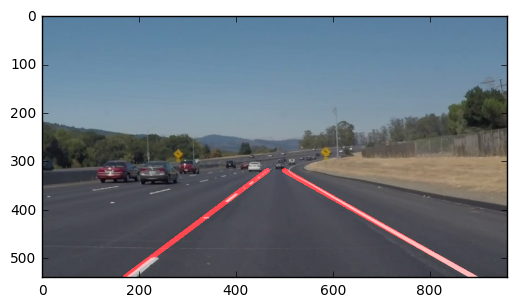

In [22]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Average right_slope average is  -0.619251078036
right line 1 (506, 320) (829, 540)
left line 2 (466, 320) (111, 540)
Average right_slope average is  -0.617275799929
right line 1 (505, 320) (833, 540)
left line 2 (464, 320) (108, 540)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4






  0%|          | 0/682 [00:00<?, ?it/s]



  0%|          | 1/682 [00:00<01:40,  6.75it/s]

Average right_slope average is  -0.619251078036
right line 1 (506, 320) (829, 540)
left line 2 (466, 320) (111, 540)
Average right_slope average is  -0.617275799929
right line 1 (505, 320) (833, 540)
left line 2 (464, 320) (108, 540)
Average right_slope average is  -0.620935022421
right line 1 (504, 320) (834, 540)
left line 2 (470, 320) (116, 540)
Average right_slope average is  -0.620887755037
right line 1 (504, 320) (831, 540)
left line 2 (464, 320) (110, 540)






  0%|          | 2/682 [00:00<01:42,  6.63it/s]



  0%|          | 3/682 [00:00<01:37,  6.93it/s]



  1%|          | 4/682 [00:00<01:35,  7.14it/s]

Average right_slope average is  -0.634370539371
right line 1 (504, 320) (827, 540)
left line 2 (467, 320) (120, 540)
Average right_slope average is  -0.620020964361
right line 1 (506, 320) (831, 540)
left line 2 (465, 320) (110, 540)
Average right_slope average is  -0.630251099452
right line 1 (510, 320) (829, 540)
left line 2 (468, 320) (119, 540)
Average right_slope average is  -0.63063970549
right line 1 (505, 320) (832, 540)
left line 2 (466, 320) (117, 540)






  1%|          | 5/682 [00:00<01:33,  7.21it/s]

Average right_slope average is  -0.640355696935
right line 1 (517, 320) (827, 540)
left line 2 (465, 320) (121, 540)
Average right_slope average is  -0.635800508287
right line 1 (504, 320) (824, 540)
left line 2 (468, 320) (122, 540)
Average right_slope average is  -0.65626448176
right line 1 (509, 320) (823, 540)
left line 2 (461, 320) (126, 540)






  1%|          | 6/682 [00:00<01:35,  7.08it/s]



  1%|          | 7/682 [00:00<01:32,  7.29it/s]



  1%|          | 8/682 [00:01<01:29,  7.49it/s]

Average right_slope average is  -0.638315680221
right line 1 (498, 320) (845, 540)
left line 2 (470, 320) (125, 540)
Average right_slope average is  -0.659928223003
right line 1 (510, 320) (837, 540)
left line 2 (464, 320) (130, 540)






  1%|▏         | 9/682 [00:01<01:35,  7.02it/s]

Average right_slope average is  -0.654168576575
right line 1 (512, 320) (841, 540)
left line 2 (466, 320) (130, 540)
Average right_slope average is  -0.646584299761
right line 1 (507, 320) (847, 540)
left line 2 





  1%|▏         | 10/682 [00:01<01:44,  6.43it/s]

(469, 320) (129, 540)
Average right_slope average is  -0.669204842215
right line 1 (505, 320) (854, 540)
left line 2 (458, 320) (129, 540)
Average right_slope average is  -0.66141994867
right line 1 (510, 320) (846, 540)
left line 2 (465, 320) (133, 540)






  2%|▏         | 11/682 [00:01<01:42,  6.57it/s]



  2%|▏         | 12/682 [00:01<01:39,  6.76it/s]

Average right_slope average is  -0.674328630259
right line 1 (513, 320) (840, 540)
left line 2 (462, 320) (135, 540)
Average right_slope average is  -0.681020843369
right line 1 (509, 320) (848, 540)
left line 2 (461, 320) (138, 540)
Average right_slope average is  -0.675682170139
right line 1 (511, 320) (842, 540)
left line 2 (459, 320) (133, 540)
Average right_slope average is  -0.665718493871
right line 1 (507, 320) (852, 540)
left line 2 (463, 320) (133, 540)






  2%|▏         | 13/682 [00:01<01:34,  7.08it/s]



  2%|▏         | 14/682 [00:01<01:33,  7.12it/s]



  2%|▏         | 15/682 [00:02<01:28,  7.51it/s]

Average right_slope average is  -0.656378187133
right line 1 (510, 320) (844, 540)
left line 2 (469, 320) (133, 540)
Average right_slope average is  -0.679107880523
right line 1 (507, 320) (843, 540)
left line 2 (461, 320) (137, 540)
Average right_slope average is  -0.671457486528
right line 1 (508, 320) (849, 540)
left line 2 (466, 320) (138, 540)
Average right_slope average is  -0.671403454163
right line 1 (508, 320) (850, 540)
left line 2 (466, 320) (138, 540)






  2%|▏         | 16/682 [00:02<01:26,  7.67it/s]



  2%|▏         | 17/682 [00:02<01:25,  7.76it/s]

Average right_slope average is  -0.683528253971
right line 1 (506, 320) (854, 540)
left line 2 (462, 320) (140, 540)
Average right_slope average is  -0.673944182954
right line 1 (505, 320) (849, 540)
left line 2 (467, 320) (141, 540)
Average right_slope average is  -0.694904154215
right line 1 (518, 320) (848, 540)
left line 2 (461, 320) (144, 540)
Average right_slope average is  -0.668278869122
right line 1 (501, 320) (852, 540)
left line 2 (466, 320) (137, 540)






  3%|▎         | 18/682 [00:02<01:23,  7.99it/s]



  3%|▎         | 19/682 [00:02<01:19,  8.31it/s]

Average right_slope average is  -0.686471250145
right line 1 (506, 320) (868, 540)
left line 2 (464, 320) (143, 540)
Average right_slope average is  -0.678486528391
right line 1 (509, 320) (868, 540)
left line 2 (463, 320) (138, 540)






  3%|▎         | 20/682 [00:02<01:22,  8.04it/s]



  3%|▎         | 21/682 [00:02<01:21,  8.12it/s]

Average right_slope average is  -0.685411016205
right line 1 (510, 320) (852, 540)
left line 2 (462, 320) (141, 540)
Average right_slope average is  -0.694208088819
right line 1 (515, 320) (838, 540)
left line 2 (462, 320) (145, 540)






  3%|▎         | 22/682 [00:02<01:22,  7.95it/s]



  3%|▎         | 23/682 [00:03<01:24,  7.81it/s]

Average right_slope average is  -0.688757817194
right line 1 (511, 320) (856, 540)
left line 2 (459, 320) (139, 540)
Average right_slope average is  -0.684041630825
right line 1 (508, 320) (846, 540)
left line 2 (459, 320) (137, 540)
Average right_slope average is  -0.687249143262
right line 1 (512, 320) (846, 540)
left line 2 (459, 320) (139, 540)
Average right_slope average is  -0.675610837916
right line 1 (507, 320) (858, 540)
left line 2 (461, 320) (135, 540)






  4%|▎         | 24/682 [00:03<01:23,  7.88it/s]



  4%|▎         | 25/682 [00:03<01:22,  8.00it/s]

Average right_slope average is  -0.683613614597
right line 1 (514, 320) (845, 540)
left line 2 (459, 320) (137, 540)
Average right_slope average is  -0.683201460743
right line 1 (506, 320) (857, 540)
left line 2 (461, 320) (139, 540)
Average right_slope average is  -0.704203323245
right line 1 (506, 320) (852, 540)
left line 2 (458, 320) (146, 540)
Average right_slope average is  -0.683005316728
right line 1 (508, 320) (854, 540)
left line 2 (462, 320) (140, 540)






  4%|▍         | 26/682 [00:03<01:31,  7.18it/s]

Average right_slope average is  -0.694660777302
right line 1 (507, 320) (855, 540)
left line 2 (464, 320) (148, 540)
Average right_slope average is  -0.706280957254
right line 1 (505, 320) (858, 540)
left line 2 (461, 320) (149, 540)
Average right_slope average is  -0.713827093895
right line 1 (509, 320) (864, 540)
left line 2 (462, 320) (154, 540)






  4%|▍         | 27/682 [00:03<01:41,  6.48it/s]

Average right_slope average is  -0.697690849071
right line 1 (508, 320) (860, 540)
left line 2 (462, 320) (147, 540)
Average right_slope average is  -0.743204993459
right line 1 (507, 320) (865, 540)
left line 2 (456, 320) (160, 540)






  4%|▍         | 28/682 [00:03<01:56,  5.63it/s]

Average right_slope average is  -0.724844729567
right line 1 (510, 320) (860, 540)
left line 2 (459, 320) (156, 540)
Average right_slope average is  -0.726224602792
right line 1 (521, 320) (868, 540)
left line 2 (456, 320) (153, 540)
Average right_slope average is  -0.703802266449
right line 1 (500, 320) (868, 540)
left line 2 (460, 320) (147, 540)






  4%|▍         | 29/682 [00:04<01:54,  5.71it/s]



  4%|▍         | 30/682 [00:04<01:43,  6.31it/s]

Average right_slope average is  -0.718264474481
right line 1 (512, 320) (870, 540)
left line 2 (460, 320) (153, 540)
Average right_slope average is  -0.704545999747
right line 1 (509, 320) (869, 540)
left line 2 (460, 320) (148, 540)
Average right_slope average is  -0.715709292852
right line 1 (514, 320) (859, 540)
left line 2 (459, 320) (151, 540)






  5%|▍         | 31/682 [00:04<01:51,  5.84it/s]



  5%|▍         | 32/682 [00:04<01:49,  5.95it/s]



  5%|▍         | 33/682 [00:04<01:38,  6.59it/s]

Average right_slope average is  -0.702037682882
right line 1 (516, 320) (853, 540)
left line 2 (463, 320) (149, 540)
Average right_slope average is  -0.71181375529
right line 1 (522, 320) (844, 540)
left line 2 (457, 320) (148, 540)






  5%|▍         | 34/682 [00:04<01:35,  6.79it/s]



  5%|▌         | 35/682 [00:04<01:27,  7.38it/s]

Average right_slope average is  -0.700350088508
right line 1 (520, 320) (859, 540)
left line 2 (461, 320) (147, 540)
Average right_slope average is  -0.73046487902
right line 1 (516, 320) (869, 540)
left line 2 (455, 320) (154, 540)






  5%|▌         | 36/682 [00:05<01:22,  7.83it/s]



  5%|▌         | 37/682 [00:05<01:21,  7.92it/s]

Average right_slope average is  -0.748701119693
right line 1 (515, 320) (864, 540)
left line 2 (451, 320) (158, 540)
Average right_slope average is  -0.743049022011
right line 1 (511, 320) (870, 540)
left line 2 (456, 320) (159, 540)
Average right_slope average is  -0.739660987902
right line 1 (518, 320) (863, 540)
left line 2 (451, 320) (154, 540)
Average right_slope average is  -0.719660395946
right line 1 (514, 320) (869, 540)
left line 2 (456, 320) (151, 540)






  6%|▌         | 38/682 [00:05<01:24,  7.60it/s]

Average right_slope average is  -0.748144402349
right line 1 (516, 320) (864, 540)
left line 2 (453, 320) (159, 540)
Average right_slope average is  -0.734995356397
right line 1 (511, 320) (869, 540)
left line 2 (455, 320) (156, 540)
Average right_slope average is  -0.747454691394
right line 1 (527, 320) (868, 540)
left line 2 (449, 320) (154, 540)
Average right_slope average is  -0.749164001959
right line 1 (508, 320) (873, 540)
left line 2 (453, 320) (160, 540)






  6%|▌         | 39/682 [00:05<01:26,  7.39it/s]



  6%|▌         | 40/682 [00:05<01:27,  7.36it/s]



  6%|▌         | 41/682 [00:05<01:22,  7.73it/s]

Average right_slope average is  -0.737966562142
right line 1 (520, 320) (877, 540)
left line 2 (450, 320) (152, 540)
Average right_slope average is  -0.723843446937
right line 1 (509, 320) (875, 540)
left line 2 (451, 320) (147, 540)
Average right_slope average is  -0.732717267356
right line 1 (506, 320) (878, 540)
left line 2 (454, 320) (154, 540)
Average right_slope average is  -0.73588603495
right line 1 (509, 320) (875, 540)
left line 2 (452, 320) (153, 540)






  6%|▌         | 42/682 [00:05<01:22,  7.75it/s]

Average right_slope average is  -0.732191451738
right line 1 (512, 320) (873, 540)
left line 2 (453, 320) (153, 540)
Average right_slope average is  -0.717754021274
right line 1 (512, 320) (875, 540)
left line 2 (453, 320) (147, 540)
Average right_slope average is  -0.740336260698
right line 1 (520, 320) (849, 540)
left line 2 (448, 320) (151, 540)






  6%|▋         | 43/682 [00:06<01:31,  7.00it/s]



  6%|▋         | 44/682 [00:06<01:31,  6.96it/s]



  7%|▋         | 45/682 [00:06<01:30,  7.06it/s]

Average right_slope average is  -0.757725063847
right line 1 (517, 320) (855, 540)
left line 2 (447, 320) (157, 540)
Average right_slope average is  -0.741127867207
right line 1 (518, 320) (857, 540)
left line 2 (450, 320) (153, 540)






  7%|▋         | 46/682 [00:06<01:32,  6.87it/s]

Average right_slope average is  -0.747315508565
right line 1 (518, 320) (857, 540)
left line 2 (451, 320) (156, 540)
Average right_slope average is  -0.728792030135
right line 1 (511, 320) (859, 540)
left line 2 (455, 320) (153, 540)
Average right_slope average is  -0.733261062173
right line 1 (501, 320) (889, 540)
left line 2 (453, 320) (153, 540)






  7%|▋         | 47/682 [00:06<01:31,  6.90it/s]



  7%|▋         | 48/682 [00:06<01:37,  6.52it/s]

Average right_slope average is  -0.742877404769
right line 1 (511, 320) (858, 540)
left line 2 (449, 320) (153, 540)
Average right_slope average is  -0.731247561252
right line 1 (503, 320) (872, 540)
left line 2 (455, 320) (154, 540)
Average right_slope average is  -0.726397341825
right line 1 (517, 320) (857, 540)
left line 2 (451, 320) (149, 540)
Average right_slope average is  -0.725472114809
right line 1 (508, 320) (868, 540)
left line 2 (452, 320) 





  7%|▋         | 49/682 [00:06<01:39,  6.35it/s]



  7%|▋         | 50/682 [00:07<02:04,  5.06it/s]

(149, 540)
Average right_slope average is  -0.721987862637
right line 1 (511, 320) (866, 540)
left line 2 (453, 320) (148, 540)
Average right_slope average is  -0.731919620391
right line 1 (509, 320) (869, 540)
left line 2 (453, 320) (152, 540)






  7%|▋         | 51/682 [00:07<01:55,  5.48it/s]

Average right_slope average is  -0.727704552102
right line 1 (508, 320) (872, 540)
left line 2 (449, 320) (147, 540)
Average right_slope average is  -0.724982173307
right line 1 (504, 320) (869, 540)
left line 2 (451, 320) (147, 540)
Average right_slope average is  -0.740250902658
right line 1 (512, 320) (867, 540)
left line 2 (447, 320) (150, 540)
Average right_slope average is  -0.736818220567
right line 1 (507, 320) (866, 540)
left line 2 (451, 320) (153, 540)






  8%|▊         | 52/682 [00:07<01:48,  5.81it/s]



  8%|▊         | 53/682 [00:07<01:48,  5.82it/s]

Average right_slope average is  -0.718801628479
right line 1 (514, 320) (858, 540)
left line 2 (456, 320) (150, 540)
Average right_slope average is  -0.741668760391
right line 1 (507, 320) (867, 540)
left line 2 (453, 320) (156, 540)
Average right_slope average is  -0.742624448333
right line 1 (508, 320) (860, 540)
left line 2 (452, 320) (156, 540)
Average right_slope average is  -0.722103874229
right line 1 (501, 320) (871, 540)
left line 2 (454, 320) (149, 540)






  8%|▊         | 54/682 [00:07<01:55,  5.46it/s]



  8%|▊         | 55/682 [00:08<01:47,  5.85it/s]

Average right_slope average is  -0.729692692647
right line 1 (517, 320) (860, 540)
left line 2 (455, 320) (153, 540)
Average right_slope average is  -0.73180143974
right line 1 (513, 320) (859, 540)
left line 2 (454, 320) (154, 540)
Average right_slope average is  -0.724457282748
right line 1 (513, 320) (834, 540)
left line 2 (452, 320) (148, 540)






  8%|▊         | 56/682 [00:08<01:45,  5.91it/s]



  8%|▊         | 57/682 [00:08<01:39,  6.29it/s]

Average right_slope average is  -0.737991589933
right line 1 (512, 320) (850, 540)
left line 2 (455, 320) (157, 540)
Average right_slope average is  -0.731488923458
right line 1 (510, 320) (856, 540)
left line 2 (456, 320) (155, 540)






  9%|▊         | 58/682 [00:08<01:37,  6.43it/s]



  9%|▊         | 59/682 [00:08<01:45,  5.90it/s]

Average right_slope average is  -0.740979128494
right line 1 (510, 320) (860, 540)
left line 2 (451, 320) (154, 540)






  9%|▉         | 60/682 [00:08<01:54,  5.42it/s]

Average right_slope average is  -0.736186367089
right line 1 (511, 320) (853, 540)
left line 2 (449, 320) (150, 540)
Average right_slope average is  -0.713529014949
right line 1 (502, 320) (854, 540)
left line 2 (453, 320) (145, 540)
Average right_slope average is  -0.717204112412
right line 1 (507, 320) (859, 540)
left line 2 (455, 320) (148, 540)
Average right_slope average is  -0.731058101086
right line 1 (500, 320) (865, 540)
left line 2 (453, 320) (152, 540)






  9%|▉         | 61/682 [00:09<01:46,  5.81it/s]



  9%|▉         | 62/682 [00:09<01:42,  6.02it/s]

Average right_slope average is  -0.709770543513
right line 1 (506, 320) (858, 540)
left line 2 (453, 320) (143, 540)
Average right_slope average is  -0.709180550958
right line 1 (502, 320) (862, 540)
left line 2 (453, 320) (143, 540)
Average right_slope average is  -0.718876672693
right line 1 (505, 320) (864, 540)
left line 2 (450, 320) (144, 540)
Average right_slope average is  





  9%|▉         | 63/682 [00:09<01:47,  5.78it/s]

-0.704914531157
right line 1 (503, 320) (865, 540)
left line 2 (459, 320) (147, 540)
Average right_slope average is  -0.727354896542
right line 1 (508, 320) (866, 540)
left line 2 (448, 320) (145, 540)
Average right_slope average is  -0.70276902173
right line 1 (503, 320) (859, 540)
left line 2 (452, 320) (139, 540)






  9%|▉         | 64/682 [00:09<01:44,  5.90it/s]



 10%|▉         | 65/682 [00:09<01:40,  6.14it/s]

Average right_slope average is  -0.718445393403
right line 1 (517, 320) (856, 540)
left line 2 (453, 320) (146, 540)
Average right_slope average is  -0.700382315475
right line 1 (503, 320) (862, 540)
left line 2 (455, 320) (140, 540)
Average right_slope average is  -0.717901617988
right line 1 (502, 320) (869, 540)
left line 2 (452, 320) (145, 540)
Average right_slope average is  -0.696814234155
right line 1 (499, 320) (865, 540)
left line 2 (455, 320) (139, 540)






 10%|▉         | 66/682 [00:09<01:42,  6.01it/s]



 10%|▉         | 67/682 [00:10<01:39,  6.16it/s]

Average right_slope average is  -0.725926691185
right line 1 (511, 320) (856, 540)
left line 2 (451, 320) (148, 540)
Average right_slope average is  -0.713860323298
right line 1 (507, 320) (859, 540)
left line 2 (457, 320) (149, 540)
Average right_slope average is  -0.711978248769
right line 1 (514, 320) (845, 540)
left line 2 (453, 320) (144, 540)






 10%|▉         | 68/682 [00:10<01:37,  6.33it/s]



 10%|█         | 69/682 [00:10<01:31,  6.71it/s]

Average right_slope average is  -0.707127346353
right line 1 (505, 320) (854, 540)
left line 2 (454, 320) (142, 540)
Average right_slope average is  -0.699113526855
right line 1 (509, 320) (848, 540)
left line 2 (458, 320) (143, 540)






 10%|█         | 70/682 [00:10<01:30,  6.77it/s]



 10%|█         | 71/682 [00:10<01:39,  6.17it/s]

Average right_slope average is  -0.717550843977
right line 1 (508, 320) (847, 540)
left line 2 (453, 320) (147, 540)
Average right_slope average is  -0.716027406056
right line 1 (498, 320) (880, 540)
left line 2 (454, 320) (147, 540)






 11%|█         | 72/682 [00:10<01:50,  5.50it/s]

Average right_slope average is  -0.733741312943
right line 1 (508, 320) (848, 540)
left line 2 (454, 320) (154, 540)
Average right_slope average is  -0.709631213539
right line 1 (504, 320) (836, 540)
left line 2 (457, 320) (147, 540)






 11%|█         | 73/682 [00:11<01:47,  5.68it/s]

Average right_slope average is  -0.746649594868
right line 1 (509, 320) (836, 540)
left line 2 (452, 320) (157, 540)
Average right_slope average is  -0.700620232659
right line 1 (503, 320) (852, 540)
left line 2 (459, 320) (145, 540)
Average right_slope average is  -0.706465724581
right line 1 (506, 320) (851, 540)
left line 2 (455, 320) (144, 540)
Average right_slope average is  -0.701060107245
right line 1 (498, 320) (860, 540)
left line 2 (459, 320) (146, 540)






 11%|█         | 74/682 [00:11<01:51,  5.47it/s]



 11%|█         | 75/682 [00:11<02:05,  4.82it/s]

Average right_slope average is  -0.725859231113
right line 1 (507, 320) (847, 540)
left line 2 (455, 320) (152, 540)
Average right_slope average is  -0.698703642881
right line 1 (500, 320) (852, 540)
left line 2 (458, 320) (143, 540)






 11%|█         | 76/682 [00:11<01:59,  5.09it/s]



 11%|█▏        | 77/682 [00:11<01:47,  5.62it/s]

Average right_slope average is  -0.720213641403
right line 1 (499, 320) (855, 540)
left line 2 (456, 320) (150, 540)
Average right_slope average is  -0.720660455804
right line 1 (501, 320) (849, 540)
left line 2 (455, 320) (150, 540)
Average right_slope average is  -0.722525039581
right line 1 (505, 320) (844, 540)
left line 2 (457, 320) (153, 540)
Average right_slope average is  -0.708930701115
right line 1 (502, 320) (850, 540)
left line 2 (458, 320) (147, 540)






 11%|█▏        | 78/682 [00:11<01:43,  5.85it/s]

Average right_slope average is  -0.707939649914
right line 1 (504, 320) (849, 540)
left line 2 (455, 320) (144, 540)
Average right_slope average is  -0.701307976928
right line 1 (501, 320) (849, 540)
left line 2 (459, 320) (145, 540)
Average right_slope average is  -0.729366336117
right line 1 (505, 320) (847, 540)
left line 2 (452, 320) (150, 540)
Average right_slope average is  -0.72209040368
right line 1 (500, 320) (852, 540)
left line 2 (456, 320) (151, 540)






 12%|█▏        | 79/682 [00:12<01:35,  6.31it/s]



 12%|█▏        | 80/682 [00:12<01:35,  6.29it/s]

Average right_slope average is  -0.716985931081
right line 1 (513, 320) (845, 540)
left line 2 (453, 320) (147, 540)
Average right_slope average is  -0.717839597044
right line 1 (504, 320) (852, 540)
left line 2 (455, 320) (149, 540)
Average right_slope average is  -0.718702110769
right line 1 (506, 320) 





 12%|█▏        | 81/682 [00:12<01:37,  6.17it/s]

(838, 540)
left line 2 (455, 320) (149, 540)
Average right_slope average is  -0.703829892493
right line 1 (508, 320) (842, 540)
left line 2 (452, 320) (139, 540)






 12%|█▏        | 82/682 [00:12<01:34,  6.33it/s]



 12%|█▏        | 83/682 [00:12<01:32,  6.48it/s]

Average right_slope average is  -0.706625222554
right line 1 (505, 320) (841, 540)
left line 2 (455, 320) (143, 540)
Average right_slope average is  -0.714502586272
right line 1 (508, 320) (845, 540)
left line 2 (453, 320) (145, 540)






 12%|█▏        | 84/682 [00:12<01:31,  6.57it/s]



 12%|█▏        | 85/682 [00:13<01:28,  6.76it/s]

Average right_slope average is  -0.720621059033
right line 1 (509, 320) (845, 540)
left line 2 (454, 320) (149, 540)
Average right_slope average is  -0.703538032561
right line 1 (502, 320) (851, 540)
left line 2 (453, 320) (141, 540)
Average right_slope average is  -0.711654886637
right line 1 (507, 320) (837, 540)
left line 2 (452, 320) (143, 540)
Average right_slope average is  -0.697047955064
right line 1 (501, 320) (851, 540)
left line 2 (456, 320) (141, 540)






 13%|█▎        | 86/682 [00:13<01:28,  6.77it/s]



 13%|█▎        | 87/682 [00:13<01:27,  6.82it/s]

Average right_slope average is  -0.726887383988
right line 1 (505, 320) (844, 540)
left line 2 (452, 320) (150, 540)
Average right_slope average is  -0.693808069238
right line 1 (501, 320) (854, 540)
left line 2 (456, 320) (139, 540)
Average right_slope average is  -0.709986252202
right line 1 (511, 320) (841, 540)
left line 2 (451, 320) (141, 540)
Average right_slope average is  -0.695268460847
right line 1 (501, 320) (849, 540)
left line 2 (455, 320) (139, 540)






 13%|█▎        | 88/682 [00:13<01:32,  6.43it/s]



 13%|█▎        | 89/682 [00:13<01:31,  6.51it/s]

Average right_slope average is  -0.69685101476
right line 1 (507, 320) (850, 540)
left line 2 (453, 320) (138, 540)
Average right_slope average is  -0.68784103534
right line 1 (501, 320) (849, 540)
left line 2 (455, 320) (136, 540)
Average right_slope average is  -0.69451070405
right line 1 (503, 320) (845, 540)
left line 2 (455, 320) (139, 540)
Average right_slope average is  -0.704159305237
right line 1 (500, 320) (849, 540)
left line 2 (455, 320) (142, 540)






 13%|█▎        | 90/682 [00:13<01:34,  6.24it/s]



 13%|█▎        | 91/682 [00:13<01:32,  6.37it/s]

Average right_slope average is  -0.707499060772
right line 1 (503, 320) (844, 540)
left line 2 (457, 320) (146, 540)
Average right_slope average is  -0.682676674772
right line 1 (501, 320) (846, 540)
left line 2 (457, 320) (135, 540)






 13%|█▎        | 92/682 [00:14<01:39,  5.94it/s]



 14%|█▎        | 93/682 [00:14<01:29,  6.55it/s]

Average right_slope average is  -0.680085426183
right line 1 (502, 320) (846, 540)
left line 2 (459, 320) (135, 540)
Average right_slope average is  -0.684012903249
right line 1 (497, 320) (846, 540)
left line 2 (460, 320) (138, 540)
Average right_slope average is  -0.690930264196
right line 1 (502, 320) (839, 540)
left line 2 (460, 320) (141, 540)
Average right_slope average is  -0.68230728621
right line 1 (502, 320) (834, 540)
left line 2 (462, 320) (139, 540)






 14%|█▍        | 94/682 [00:14<01:25,  6.87it/s]

Average right_slope average is  -0.70728604255
right line 1 (502, 320) (829, 540)
left line 2 (463, 320) (152, 540)
Average right_slope average is  -0.718698320119
right line 1 (504, 320) (827, 540)
left line 2 (457, 320) (151, 540)






 14%|█▍        | 95/682 [00:14<01:25,  6.88it/s]



 14%|█▍        | 96/682 [00:14<01:28,  6.62it/s]

Average right_slope average is  -0.706586158252
right line 1 (501, 320) (832, 540)
left line 2 (464, 320) (153, 540)
Average right_slope average is  -0.696936120389
right line 1 (505, 320) (829, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.691426862537
right line 1 (497, 320) (837, 540)
left line 2 (461, 320) (143, 540)






 14%|█▍        | 97/682 [00:14<01:26,  6.73it/s]



 14%|█▍        | 98/682 [00:14<01:24,  6.87it/s]

Average right_slope average is  -0.717117290314
right line 1 (504, 320) (833, 540)
left line 2 (456, 320) (149, 540)
Average right_slope average is  -0.687901173116
right line 1 (500, 320) (842, 540)
left line 2 (461, 320) (141, 540)
Average right_slope average is  -0.70926955989
right line 1 (505, 320) (832, 540)
left line 2 (459, 320) (149, 540)
Average right_slope average is  -0.694351759674
right line 1 (501, 320) (841, 540)
left line 2 (461, 320) (144, 540)






 15%|█▍        | 99/682 [00:15<01:47,  5.41it/s]



 15%|█▍        | 100/682 [00:15<01:48,  5.39it/s]

Average right_slope average is  -0.719316214211
right line 1 (504, 320) (834, 540)
left line 2 (461, 320) (155, 540)
Average right_slope average is  -0.694104656953
right line 1 (503, 320) (838, 540)
left line 2 (461, 320) (144, 540)
Average right_slope average is  -0.711667604282
right line 1 (506, 320) (838, 540)
left line 2 (459, 320) (150, 540)
Average right_slope average is  -0.71061281149
right line 1 (504, 320) (840, 540)
left line 2 (460, 320) (150, 540)






 15%|█▍        | 101/682 [00:15<01:38,  5.87it/s]



 15%|█▍        | 102/682 [00:15<01:47,  5.42it/s]

Average right_slope average is  -0.726884706847
right line 1 (501, 320) (841, 540)
left line 2 (459, 320) (156, 540)
Average right_slope average is  -0.693523242573
right line 1 (503, 320) (845, 540)
left line 2 (463, 320) (145, 540)






 15%|█▌        | 103/682 [00:15<01:43,  5.58it/s]

Average right_slope average is  -0.6882565314
right line 1 (506, 320) (841, 540)
left line 2 (461, 320) (141, 540)
Average right_slope average is  -0.68537376204
right line 1 (501, 320) (844, 540)
left line 2 (460, 320) (139, 540)
Average right_slope average is  -0.724064583481
right line 1 (498, 320) (854, 540)
left line 2 (457, 320) (153, 540)
Average right_slope average is  -0.696324807454
right line 1 (502, 320) (845, 540)
left line 2 (459, 320) (143, 540)






 15%|█▌        | 104/682 [00:16<01:39,  5.82it/s]



 15%|█▌        | 105/682 [00:16<01:34,  6.08it/s]



 16%|█▌        | 106/682 [00:16<01:29,  6.43it/s]

Average right_slope average is  -0.717531562733
right line 1 (503, 320) (848, 540)
left line 2 (456, 320) (150, 540)
Average right_slope average is  -0.694588098461
right line 1 (504, 320) (842, 540)
left line 2 (460, 320) (143, 540)
Average right_slope average is  -0.718434776329
right line 1 (511, 320) (843, 540)
left line 2 (455, 320) (149, 540)
Average right_slope average is  -0.713473929313
right line 1 (503, 320) (847, 540)
left line 2 (458, 320) (150, 540)






 16%|█▌        | 107/682 [00:16<01:34,  6.10it/s]

Average right_slope average is  -0.698957503016
right line 1 (505, 320) (837, 540)
left line 2 (456, 320) (141, 540)






 16%|█▌        | 108/682 [00:16<01:31,  6.27it/s]



 16%|█▌        | 109/682 [00:16<01:25,  6.69it/s]

Average right_slope average is  -0.712326677935
right line 1 (504, 320) (857, 540)
left line 2 (456, 320) (147, 540)
Average right_slope average is  -0.699083083525
right line 1 (501, 320) (845, 540)
left line 2 (457, 320) (142, 540)
Average right_slope average is  -0.697577414812
right line 1 (497, 320) (862, 540)
left line 2 (458, 320) (143, 540)






 16%|█▌        | 110/682 [00:17<01:31,  6.26it/s]

Average right_slope average is  -0.695891422033
right line 1 (501, 320) (845, 540)
left line 2 (459, 320) (143, 540)
Average right_slope average is  -0.675678444633
right line 1 (501, 320) (860, 540)
left line 2 (464, 320) (139, 540)
Average right_slope average is  -0.696337277871
right line 1 (499, 320) (848, 540)
left line 2 (460, 320) (144, 540)
Average right_slope average is  -0.698098659057





 16%|█▋        | 111/682 [00:17<01:31,  6.22it/s]



 16%|█▋        | 112/682 [00:17<01:32,  6.14it/s]



 17%|█▋        | 113/682 [00:17<01:25,  6.63it/s]


right line 1 (496, 320) (846, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.693846696148
right line 1 (502, 320) (843, 540)
left line 2 (461, 320) (143, 540)
Average right_slope average is  -0.713402680709
right line 1 (498, 320) (847, 540)
left line 2 (461, 320) (153, 540)
Average right_slope average is  -0.708036319497
right line 1 (505, 320) (835, 540)
left line 2 (461, 320) (150, 540)
Average right_slope average is  -0.693738019282
right line 1 (500, 320) (845, 540)
left line 2 (463, 320) (146, 540)






 17%|█▋        | 114/682 [00:17<01:31,  6.18it/s]

Average right_slope average is  -0.721503582624
right line 1 (504, 320) (839, 540)
left line 2 (459, 320) (154, 540)
Average right_slope average is  -0.706337751506
right line 1 (499, 320) (852, 540)
left line 2 (462, 320) (150, 540)






 17%|█▋        | 115/682 [00:17<01:39,  5.67it/s]

Average right_slope average is  -0.70172708175
right line 1 (503, 320) (846, 540)
left line 2 (462, 320) (149, 540)
Average right_slope average is  -0.708253906029
right line 1 (499, 320) (845, 540)
left line 2 (460, 320) (150, 540)
Average right_slope average is  -0.712775886632
right line 1 (504, 320) (852, 540)
left line 2 (459, 320) (151, 540)
Average right_slope average is  -0.696177510484
right line 1 (501, 320) (847, 540)
left line 2 (462, 320) (146, 540)






 17%|█▋        | 116/682 [00:18<01:34,  5.98it/s]



 17%|█▋        | 117/682 [00:18<01:33,  6.03it/s]

Average right_slope average is  -0.701370092607
right line 1 (502, 320) (847, 540)
left line 2 (460, 320) (146, 540)
Average right_slope average is  -0.698429488527
right line 1 (500, 320) (848, 540)
left line 2 (460, 320) (145, 540)
Average right_slope average is  -0.699958298099
right line 1 (504, 320) (851, 540)
left line 2 (460, 320) (146, 540)
Average right_slope average is  -0.718161425246
right line 1 (498, 320) (855, 540)
left line 2 (460, 320) (153, 540)






 17%|█▋        | 118/682 [00:18<01:35,  5.94it/s]



 17%|█▋        | 119/682 [00:18<01:30,  6.20it/s]



 18%|█▊        | 120/682 [00:18<01:25,  6.59it/s]

Average right_slope average is  -0.711451958837
right line 1 (511, 320) (834, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.707254576044
right line 1 (501, 320) (861, 540)
left line 2 (460, 320) (149, 540)
Average right_slope average is  -0.706690126474
right line 1 (505, 320) (837, 540)
left line 2 (461, 320) (150, 540)






 18%|█▊        | 121/682 [00:18<01:22,  6.78it/s]

Average right_slope average is  -0.708732867788
right line 1 (506, 320) (852, 540)
left line 2 (459, 320) (149, 540)
Average right_slope average is  -0.711590536634
right line 1 (508, 320) (840, 540)
left line 2 (460, 320) (151, 540)






 18%|█▊        | 122/682 [00:18<01:21,  6.88it/s]



 18%|█▊        | 123/682 [00:19<01:16,  7.26it/s]

Average right_slope average is  -0.696259049329
right line 1 (498, 320) (863, 540)
left line 2 (461, 320) (145, 540)
Average right_slope average is  -0.697436195902
right line 1 (501, 320) (850, 540)
left line 2 (464, 320) (149, 540)
Average right_slope average is  -0.712469954459
right line 1 (500, 320) (844, 540)
left line 2 (458, 320) (150, 540)
Average right_slope average is  -0.702612475434
right line 1 (501, 320) (846, 540)
left line 2 (463, 320) (150, 540)






 18%|█▊        | 124/682 [00:19<01:19,  6.98it/s]



 18%|█▊        | 125/682 [00:19<01:28,  6.26it/s]

Average right_slope average is  -0.702148052692
right line 1 (504, 320) (853, 540)
left line 2 (461, 320) (147, 540)
Average right_slope average is  -0.705842969545
right line 1 (501, 320) (851, 540)
left line 2 (462, 320) (151, 540)






 18%|█▊        | 126/682 [00:19<01:41,  5.47it/s]



 19%|█▊        | 127/682 [00:19<01:30,  6.12it/s]

Average right_slope average is  -0.708310481848
right line 1 (502, 320) (853, 540)
left line 2 (461, 320) (150, 540)
Average right_slope average is  -0.699098722639
right line 1 (501, 320) (850, 540)
left line 2 (462, 320) (147, 540)
Average right_slope average is  -0.699267703394
right line 1 (496, 320) (856, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.707714510635
right line 1 (499, 320) (854, 540)
left line 2 (462, 320) (151, 540)






 19%|█▉        | 128/682 [00:19<01:32,  6.01it/s]

Average right_slope average is  -0.700109579961
right line 1 (499, 320) (847, 540)
left line 2 (462, 320) (148, 540)
Average right_slope average is  -0.713228372592
right line 1 (501, 320) (850, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.700959779089
right line 1 (499, 320) (851, 540)
left line 2 (464, 320) (150, 540)






 19%|█▉        | 129/682 [00:20<01:30,  6.11it/s]



 19%|█▉        | 130/682 [00:20<01:26,  6.38it/s]

Average right_slope average is  -0.701500955768
right line 1 (501, 320) (849, 540)
left line 2 (464, 320) (150, 540)
Average right_slope average is  -0.710159852773
right line 1 (502, 320) (850, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.692938682677
right line 1 (504, 320) (847, 540)
left line 2 (466, 320) (148, 540)






 19%|█▉        | 131/682 [00:20<01:55,  4.77it/s]

Average right_slope average is  -0.694634438812
right line 1 (499, 320) (852, 540)
left line 2 (465, 320) (149, 540)
Average right_slope average is  -0.694594647391
right line 1 (500, 320) (850, 540)
left line 2 (467, 320) (150, 540)






 19%|█▉        | 132/682 [00:20<01:57,  4.69it/s]

Average right_slope average is  -0.699118301115
right line 1 (503, 320) (845, 540)
left line 2 (463, 320) (148, 540)
Average right_slope average is  -0.724441240236
right line 1 (500, 320) (862, 540)
left line 2 (461, 320) (157, 540)






 20%|█▉        | 133/682 [00:20<01:54,  4.79it/s]



 20%|█▉        | 134/682 [00:21<01:44,  5.26it/s]



 20%|█▉        | 135/682 [00:21<01:36,  5.66it/s]

Average right_slope average is  -0.712265279334
right line 1 (500, 320) (850, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.693564307541
right line 1 (500, 320) (839, 540)
left line 2 (469, 320) (152, 540)
Average right_slope average is  -0.704561474142
right line 1 (493, 320) (852, 540)
left line 2 (465, 320) (153, 540)
Average right_slope average is  -0.701611481298
right line 1 (501, 320) (850, 540)
left line 2 (466, 320) (152, 540)






 20%|█▉        | 136/682 [00:21<01:40,  5.44it/s]

Average right_slope average is  -0.693771055843
right line 1 (500, 320) (851, 540)
left line 2 (466, 320) (148, 540)
Average right_slope average is  -0.706992600212
right line 1 (501, 320) (847, 540)
left line 2 (463, 320) (152, 540)






 20%|██        | 137/682 [00:21<01:35,  5.70it/s]

Average right_slope average is  -0.690899972892
right line 1 (501, 320) (848, 540)
left line 2 (464, 320) (146, 540)
Average right_slope average is  -0.706226110869
right line 1 (502, 320) (841, 540)
left line 2 (464, 320) (153, 540)
Average right_slope average is  -0.686502237237
right line 1 (501, 320) (847, 540)
left line 2 (466, 320) (145, 540)
Average right_slope average is  -0.711033864284
right line 1 (502, 320) (850, 540)
left line 2 (463, 320) (154, 540)






 20%|██        | 138/682 [00:21<01:37,  5.59it/s]



 20%|██        | 139/682 [00:21<01:28,  6.14it/s]



 21%|██        | 140/682 [00:22<01:21,  6.63it/s]

Average right_slope average is  -0.706712800928
right line 1 (495, 320) (856, 540)
left line 2 (464, 320) (152, 540)
Average right_slope average is  -0.702074976347
right line 1 (501, 320) (850, 540)
left line 2 (465, 320) (152, 540)
Average right_slope average is  -0.697240159853
right line 1 (500, 320) (846, 540)
left line 2 (462, 320) (146, 540)
Average right_slope average is  -0.702975677023
right line 1 (501, 320) (844, 540)
left line 2 (463, 320) (150, 540)






 21%|██        | 141/682 [00:22<01:20,  6.73it/s]

Average right_slope average is  -0.695325444147
right line 1 (499, 320) (849, 540)
left line 2 (463, 320) (146, 540)
Average right_slope average is  -0.701776768145
right line 1 (501, 320) (847, 540)
left line 2 (463, 320) (150, 540)
Average right_slope average is  -0.695419863343
right line 1 (500, 320) (848, 540)
left line 2 (463, 320) (147, 540)
Average right_slope average is  -0.705141412163
right line 1 (501, 320) (850, 540)
left line 2 (465, 320) (153, 540)






 21%|██        | 142/682 [00:22<01:18,  6.85it/s]



 21%|██        | 143/682 [00:22<01:18,  6.90it/s]

Average right_slope average is  -0.697336577945
right line 1 (484, 320) (842, 540)
left line 2 (463, 320) (148, 540)
Average right_slope average is  -0.699464933283
right line 1 (503, 320) (852, 540)
left line 2 (462, 320) (148, 540)
Average right_slope average is  -0.696318401184
right line 1 (500, 320) (859, 540)
left line 2 (463, 320) (147, 540)






 21%|██        | 144/682 [00:22<01:20,  6.65it/s]



 21%|██▏       | 145/682 [00:22<01:20,  6.65it/s]

Average right_slope average is  -0.706296909314
right line 1 (498, 320) (854, 540)
left line 2 (462, 320) (150, 540)
Average right_slope average is  -0.701822391622
right line 1 (497, 320) (857, 540)
left line 2 (464, 320) (150, 540)






 21%|██▏       | 146/682 [00:22<01:18,  6.82it/s]



 22%|██▏       | 147/682 [00:23<01:18,  6.79it/s]

Average right_slope average is  -0.696169584546
right line 1 (501, 320) (849, 540)
left line 2 (463, 320) (147, 540)
Average right_slope average is  -0.709438221418
right line 1 (501, 320) (850, 540)
left line 2 (464, 320) (154, 540)
Average right_slope average is  -0.694223838739
right line 1 (496, 320) (856, 540)
left line 2 (464, 320) (147, 540)
Average right_slope average is  -0.711147345339
right line 1 (501, 320) (849, 540)
left line 2 (464, 320) (155, 540)






 22%|██▏       | 148/682 [00:23<01:19,  6.75it/s]



 22%|██▏       | 149/682 [00:23<01:21,  6.51it/s]

Average right_slope average is  -0.682393819576
right line 1 (495, 320) (859, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.696663950828
right line 1 (496, 320) (854, 540)
left line 2 (464, 320) (148, 540)
Average right_slope average is  -0.695104506303
right line 1 (496, 320) (863, 540)
left line 2 (465, 320) (149, 540)
Average right_slope average is  -0.689106809841
right line 1 (500, 320) (854, 540)
left line 2 (466, 320) (147, 540)






 22%|██▏       | 150/682 [00:23<01:23,  6.37it/s]



 22%|██▏       | 151/682 [00:23<01:22,  6.40it/s]

Average right_slope average is  -0.706463482688
right line 1 (496, 320) (860, 540)
left line 2 (464, 320) (153, 540)
Average right_slope average is  -0.70381207319
right line 1 (499, 320) (850, 540)
left line 2 (465, 320) (152, 540)
Average right_slope average is  -0.701967654448
right line 1 (495, 320) (862, 540)
left line 2 (464, 320) (151, 540)
Average right_slope average is  -0.706620710784
right line 1 (498, 320) (851, 540)
left line 2 (463, 320) (151, 540)






 22%|██▏       | 152/682 [00:23<01:21,  6.50it/s]



 22%|██▏       | 153/682 [00:24<01:18,  6.76it/s]

Average right_slope average is  -0.696506484636
right line 1 (481, 320) (849, 540)
left line 2 (467, 320) (152, 540)
Average right_slope average is  -0.694216521474
right line 1 (500, 320) (855, 540)
left line 2 (467, 320) (150, 540)
Average right_slope average is  -0.711004945385
right line 1 (497, 320) (865, 540)
left line 2 (465, 320) (156, 540)
Average right_slope average is  -0.698990988953
right line 1 (500, 320) (856, 540)
left line 2 (466, 320) (151, 540)






 23%|██▎       | 154/682 [00:24<01:21,  6.46it/s]



 23%|██▎       | 155/682 [00:24<01:27,  6.04it/s]

Average right_slope average is  -0.707903069561
right line 1 (496, 320) (858, 540)
left line 2 (466, 320) (155, 540)
Average right_slope average is  -0.698123406045
right line 1 (499, 320) (855, 540)
left line 2 (469, 320) (154, 540)
Average right_slope average is  -0.714748854278
right line 1 (478, 320) (862, 540)
left line 2 (466, 320) (159, 540)
Average right_slope average is  -0.692414111218
right line 1 (496, 320) (857, 540)
left line 2 (472, 320) (155, 540)






 23%|██▎       | 156/682 [00:24<01:21,  6.42it/s]



 23%|██▎       | 157/682 [00:24<01:17,  6.78it/s]

Average right_slope average is  -0.702801438109
right line 1 (491, 320) (878, 540)
left line 2 (471, 320) (158, 540)
Average right_slope average is  -0.700747896803
right line 1 (489, 320) (887, 540)
left line 2 (470, 320) (156, 540)
Average right_slope average is  -0.704308446175
right line 1 (463, 320) (854, 540)
left line 2 (472, 320) (159, 540)






 23%|██▎       | 158/682 [00:24<01:15,  6.99it/s]



 23%|██▎       | 159/682 [00:24<01:23,  6.26it/s]

Average right_slope average is  -0.709179152998
right line 1 (491, 320) (868, 540)
left line 2 (471, 320) (161, 540)
Average right_slope average is  -0.703393677286
right line 1 (491, 320) (864, 540)
left line 2 (471, 320) (159, 540)






 23%|██▎       | 160/682 [00:25<01:37,  5.34it/s]

Average right_slope average is  -0.713236876384
right line 1 (491, 320) (872, 540)
left line 2 (470, 320) (162, 540)
Average right_slope average is  -0.70114944837
right line 1 (492, 320) (862, 540)
left line 2 (474, 320) (160, 540)






 24%|██▎       | 161/682 [00:25<01:33,  5.59it/s]

Average right_slope average is  -0.726348693277
right line 1 (491, 320) (861, 540)
left line 2 (470, 320) (167, 540)
Average right_slope average is  -0.696321716568
right line 1 (491, 320) (865, 540)
left line 2 (474, 320) (158, 540)
Average right_slope average is  -0.711676342042
right line 1 (459, 320) (840, 540)
left line 2 (471, 320) (162, 540)
Average right_slope average is 





 24%|██▍       | 162/682 [00:25<01:39,  5.22it/s]

 -0.70944406463
right line 1 (498, 320) (859, 540)
left line 2 (472, 320) (162, 540)
Average right_slope average is  -0.706860596975
right line 1 (494, 320) (873, 540)
left line 2 (471, 320) (159, 540)






 24%|██▍       | 163/682 [00:25<01:39,  5.19it/s]

Average right_slope average is  -0.703129411922
right line 1 (495, 320) (863, 540)
left line 2 (474, 320) (161, 540)
Average right_slope average is  -0.713533987085
right line 1 (471, 320) (870, 540)
left line 2 (469, 320) (161, 540)
Average right_slope average is  -0.707884615385
right line 1 (496, 320) (869, 540)
left line 2 (473, 320) (162, 540)






 24%|██▍       | 164/682 [00:25<01:33,  5.56it/s]



 24%|██▍       | 165/682 [00:26<01:30,  5.69it/s]

Average right_slope average is  -0.701627631229
right line 1 (496, 320) (871, 540)
left line 2 (472, 320) (158, 540)
Average right_slope average is  -0.706612628148
right line 1 (496, 320) (866, 540)
left line 2 (475, 320) (163, 540)
Average right_slope average is  -0.716293949308
right line 1 (483, 320) (867, 540)
left line 2 (467, 320) (160, 540)






 24%|██▍       | 166/682 [00:26<01:28,  5.82it/s]

Average right_slope average is  -0.70208084351
right line 1 (499, 320) (868, 540)
left line 2 (472, 320) (159, 540)
Average right_slope average is  -0.72271752539
right line 1 (493, 320) (879, 540)
left line 2 (467, 320) (163, 540)
Average right_slope average is  -0.70300671879
right line 1 (496, 320) (869, 540)
left line 2 (471, 320) (158, 540)






 24%|██▍       | 167/682 [00:26<01:25,  6.00it/s]



 25%|██▍       | 168/682 [00:26<01:22,  6.20it/s]

Average right_slope average is  -0.709612241595
right line 1 (498, 320) (874, 540)
left line 2 (471, 320) (161, 540)
Average right_slope average is  -0.735599692508
right line 1 (499, 320) (866, 540)
left line 2 (472, 320) (173, 540)
Average right_slope average is  -0.736542550173
right line 1 (499, 320) (875, 540)
left line 2 (470, 320) (171, 540)






 25%|██▍       | 169/682 [00:26<01:22,  6.25it/s]



 25%|██▍       | 170/682 [00:26<01:18,  6.48it/s]



 25%|██▌       | 171/682 [00:27<01:14,  6.90it/s]

Average right_slope average is  -0.716423118014
right line 1 (467, 320) (854, 540)
left line 2 (474, 320) (167, 540)
Average right_slope average is  -0.73758597765
right line 1 (498, 320) (887, 540)
left line 2 (470, 320) (172, 540)






 25%|██▌       | 172/682 [00:27<01:16,  6.69it/s]

Average right_slope average is  -0.748228882107
right line 1 (503, 320) (876, 540)
left line 2 (470, 320) (176, 540)
Average right_slope average is  -0.741567151562
right line 1 (475, 320) (876, 540)
left line 2 (470, 320) (173, 540)
Average right_slope average is  -0.75009446448
right line 1 (498, 320) (879, 540)
left line 2 (468, 320) (175, 540)






 25%|██▌       | 173/682 [00:27<01:18,  6.50it/s]



 26%|██▌       | 174/682 [00:27<01:35,  5.33it/s]

Average right_slope average is  -0.746795281675
right line 1 (501, 320) (879, 540)
left line 2 (466, 320) (172, 540)
Average right_slope average is  -0.725641101994
right line 1 (503, 320) (878, 540)
left line 2 (472, 320) (169, 540)






 26%|██▌       | 175/682 [00:27<01:31,  5.51it/s]

Average right_slope average is  -0.745367117498
right line 1 (497, 320) (891, 540)
left line 2 (468, 320) (173, 540)
Average right_slope average is  -0.736950437465
right line 1 (504, 320) (878, 540)
left line 2 (472, 320) (173, 540)
Average right_slope average is  -0.751231517487
right line 1 (501, 320) (884, 540)
left line 2 (467, 320) (174, 540)
Average right_slope average is  -0.731692017947
right line 1 (504, 320) (875, 540)
left line 2 (473, 320) (172, 540)






 26%|██▌       | 176/682 [00:27<01:28,  5.73it/s]



 26%|██▌       | 177/682 [00:28<01:23,  6.05it/s]

Average right_slope average is  -0.759566380086
right line 1 (496, 320) (883, 540)
left line 2 (471, 320) (181, 540)
Average right_slope average is  -0.747527530251
right line 1 (500, 320) (882, 540)
left line 2 (469, 320) (174, 540)
Average right_slope average is  -0.754583385978
right line 1 (484, 320) (881, 540)
left line 2 (468, 320) (177, 540)
Average right_slope average is  -0.757641322743
right line 1 (502, 320) (879, 540)
left line 2 (468, 320) (178, 540)






 26%|██▌       | 178/682 [00:28<01:19,  6.30it/s]



 26%|██▌       | 179/682 [00:28<01:18,  6.41it/s]

Average right_slope average is  -0.751242975648
right line 1 (490, 320) (892, 540)
left line 2 (471, 320) (178, 540)
Average right_slope average is  -0.758196084283
right line 1 (500, 320) (883, 540)
left line 2 (471, 320) (181, 540)
Average right_slope average is  -0.755667551563
right line 1 (491, 320) (893, 540)
left line 2 (469, 320) (178, 540)
Average right_slope average is  -0.750950367418
right line 1 (499, 320) (884, 540)
left line 2 (472, 320) (179, 540)






 26%|██▋       | 180/682 [00:28<01:16,  6.60it/s]



 27%|██▋       | 181/682 [00:28<01:13,  6.80it/s]

Average right_slope average is  -0.757517434842
right line 1 (496, 320) (888, 540)
left line 2 (469, 320) (178, 540)
Average right_slope average is  -0.76041269208
right line 1 (496, 320) (883, 540)
left line 2 (469, 320) (180, 540)
Average right_slope average is  -0.751348878292
right line 1 (497, 320) (896, 540)
left line 2 (469, 320) (176, 540)






 27%|██▋       | 182/682 [00:28<01:17,  6.46it/s]



 27%|██▋       | 183/682 [00:28<01:13,  6.75it/s]

Average right_slope average is  -0.754614017969
right line 1 (456, 320) (872, 540)
left line 2 (469, 320) (178, 540)
Average right_slope average is  -0.758748391687
right line 1 (496, 320) (890, 540)
left line 2 (469, 320) (179, 540)
Average right_slope average is  -0.763724841798
right line 1 (495, 320) (893, 540)
left line 2 (468, 320) (180, 540)






 27%|██▋       | 184/682 [00:29<01:19,  6.23it/s]



 27%|██▋       | 185/682 [00:29<01:13,  6.72it/s]

Average right_slope average is  -0.760276030722
right line 1 (493, 320) (892, 540)
left line 2 (469, 320) (180, 540)
Average right_slope average is  -0.767091522728
right line 1 (490, 320) (895, 540)
left line 2 (469, 320) (182, 540)
Average right_slope average is  -0.754181567738
right line 1 (499, 320) (880, 540)
left line 2 (469, 320) (177, 540)
Average right_slope average is  -0.765221016022
right line 1 (494, 320) (888, 540)
left line 2 (469, 320) (181, 540)






 27%|██▋       | 186/682 [00:29<01:18,  6.31it/s]



 27%|██▋       | 187/682 [00:29<01:12,  6.81it/s]

Average right_slope average is  -0.755803939041
right line 1 (491, 320) (894, 540)
left line 2 (470, 320) (179, 540)
Average right_slope average is  -0.760072414787
right line 1 (494, 320) (892, 540)
left line 2 (470, 320) (181, 540)
Average right_slope average is  -0.758486814548
right line 1 (482, 320) (882, 540)
left line 2 (470, 320) (180, 540)
Average right_slope average is  -0.767434079975
right line 1 (492, 320) (888, 540)
left line 2 (467, 320) (180, 540)






 28%|██▊       | 188/682 [00:29<01:30,  5.43it/s]



 28%|██▊       | 189/682 [00:30<01:31,  5.37it/s]

Average right_slope average is  -0.76815566697
right line 1 (462, 320) (878, 540)
left line 2 (469, 320) (183, 540)
Average right_slope average is  -0.766717666377
right line 1 (495, 320) (886, 540)
left line 2 (468, 320) (181, 540)






 28%|██▊       | 190/682 [00:30<01:35,  5.15it/s]

Average right_slope average is  -0.769802932456
right line 1 (479, 320) (881, 540)
left line 2 (471, 320) (185, 540)
Average right_slope average is  -0.758682926195
right line 1 (490, 320) (892, 540)
left line 2 (467, 320) (177, 540)
Average right_slope average is  -0.767573874326
right line 1 (465, 320) (898, 540)
left line 2 (468, 320) (181, 540)
Average right_slope average is  -0.760013505581
right line 1 (491, 320) (883, 540)
left line 2 (467, 320) (178, 540)






 28%|██▊       | 191/682 [00:30<01:26,  5.68it/s]



 28%|██▊       | 192/682 [00:30<01:27,  5.62it/s]

Average right_slope average is  -0.774822448318
right line 1 (473, 320) (884, 540)
left line 2 (468, 320) (184, 540)
Average right_slope average is  -0.768989276473
right line 1 (491, 320) (888, 540)
left line 2 (467, 320) (181, 540)
Average right_slope average is  -0.764481107846
right line 1 (469, 320) (889, 540)
left line 2 (467, 320) (179, 540)






 28%|██▊       | 193/682 [00:30<01:31,  5.33it/s]

Average right_slope average is  -0.764857644144
right line 1 (491, 320) (891, 540)
left line 2 (464, 320) (176, 540)
Average right_slope average is  -0.766758377708
right line 1 (493, 320) (886, 540)
left line 2 (465, 320) (178, 540)
Average right_slope average is  -0.767669172932
right line 1 (488, 320) (913, 540)
left line 2 (467, 320) (180, 540)






 28%|██▊       | 194/682 [00:30<01:31,  5.33it/s]



 29%|██▊       | 195/682 [00:31<01:28,  5.50it/s]

Average right_slope average is  -0.761273712737
right line 1 (495, 320) (880, 540)
left line 2 (464, 320) (175, 540)
Average right_slope average is  -0.775401282018
right line 1 (489, 320) (912, 540)
left line 2 (463, 320) (179, 540)
Average right_slope average is  -0.762403993856
right line 1 (467, 320) (874, 540)
left line 2 (464, 320) (176, 540)
Average right_slope average is  -0.775772782015
right line 1 (489, 320) (904, 540)
left line 2 (463, 320) (179, 540)






 29%|██▊       | 196/682 [00:31<01:38,  4.92it/s]



 29%|██▉       | 197/682 [00:31<01:33,  5.18it/s]

Average right_slope average is  -0.761908143939
right line 1 (464, 320) (870, 540)
left line 2 (464, 320) (176, 540)
Average right_slope average is  -0.766921063501
right line 1 (488, 320) (889, 540)
left line 2 (461, 320) (174, 540)
Average right_slope average is  -0.767906491301
right line 1 (433, 320) (891, 540)
left line 2 (464, 320) (178, 540)
Average right_slope average is  -0.769463209752
right line 1 (490, 320) (880, 540)
left line 2 (464, 320) (178, 540)






 29%|██▉       | 198/682 [00:31<01:30,  5.33it/s]



 29%|██▉       | 199/682 [00:31<01:23,  5.80it/s]

Average right_slope average is  -0.764691778923
right line 1 (491, 320) (883, 540)
left line 2 (464, 320) (176, 540)
Average right_slope average is  -0.761621436716
right line 1 (488, 320) (886, 540)
left line 2 (463, 320) (174, 540)
Average right_slope average is  -0.759517440435
right line 1 (487, 320) (888, 540)
left line 2 (465, 320) (175, 540)
Average right_slope average is  -0.754455401697
right line 1 (491, 320) (880, 540)
left line 2 (465, 320) (173, 540)






 29%|██▉       | 200/682 [00:32<01:29,  5.36it/s]



 29%|██▉       | 201/682 [00:32<01:21,  5.93it/s]

Average right_slope average is  -0.753736588908
right line 1 (490, 320) (880, 540)
left line 2 (463, 320) (171, 540)
Average right_slope average is  -0.760103268047
right line 1 (495, 320) (876, 540)
left line 2 (463, 320) (174, 540)
Average right_slope average is  -0.771279761905
right line 1 (456, 320) (874, 540)
left line 2 (462, 320) (177, 540)
Average right_slope average is  -0.763760607516
right line 1 (493, 320) (872, 540)
left line 2 (463, 320) (175, 540)






 30%|██▉       | 202/682 [00:32<01:22,  5.81it/s]



 30%|██▉       | 203/682 [00:32<01:25,  5.63it/s]

Average right_slope average is  -0.751962339188
right line 1 (477, 320) (874, 540)
left line 2 (463, 320) (171, 540)
Average right_slope average is  -0.754703750511
right line 1 (493, 320) (872, 540)
left line 2 (463, 320) (172, 540)
Average right_slope average is  -0.754287329404
right line 1 (456, 320) (868, 540)
left line 2 





 30%|██▉       | 204/682 [00:32<01:25,  5.61it/s]

(463, 320) (171, 540)
Average right_slope average is  -0.765444639394
right line 1 (488, 320) (878, 540)
left line 2 (461, 320) (174, 540)
Average right_slope average is  -0.749346680203
right line 1 (450, 320) (855, 540)
left line 2 (464, 320) (170, 540)
Average right_slope average is  -0.770962048543
right line 1 (490, 320) (872, 540)
left line 2 (462, 320) (177, 540)






 30%|███       | 205/682 [00:32<01:22,  5.80it/s]



 30%|███       | 206/682 [00:33<01:21,  5.86it/s]

Average right_slope average is  -0.75389200451
right line 1 (453, 320) (871, 540)
left line 2 (468, 320) (176, 540)
Average right_slope average is  -0.760669907453
right line 1 (488, 320) (870, 540)
left line 2 (467, 320) (178, 540)
Average right_slope average is  -0.741408249743
right line 1 (462, 320) (873, 540)
left line 2 (464, 320) (167, 540)
Average right_slope average is  -0.7504104328
right line 1 (484, 320) (897, 540)
left line 2 (465, 320) (171, 540)






 30%|███       | 207/682 [00:33<01:17,  6.10it/s]



 30%|███       | 208/682 [00:33<01:13,  6.41it/s]

Average right_slope average is  -0.758157327732
right line 1 (451, 320) (876, 540)
left line 2 (465, 320) (175, 540)
Average right_slope average is  -0.747387397765
right line 1 (486, 320) (876, 540)
left line 2 (464, 320) (170, 540)
Average right_slope average is  -0.752482326393
right line 1 (431, 320) (865, 540)
left line 2 (465, 320) (173, 540)
Average right_slope average is  -0.740319705393
right line 1 (488, 320) (875, 540)
left line 2 (463, 320) (166, 540)






 31%|███       | 209/682 [00:33<01:15,  6.28it/s]



 31%|███       | 210/682 [00:33<01:11,  6.56it/s]

Average right_slope average is  -0.736546389162
right line 1 (464, 320) (875, 540)
left line 2 (465, 320) (166, 540)
Average right_slope average is  -0.757560749438
right line 1 (490, 320) (871, 540)
left line 2 (462, 320) (172, 540)
Average right_slope average is  -0.745724875448
right line 1 (485, 320) (886, 540)
left line 2 (466, 320) (171, 540)
Average right_slope average is  -0.742253103749
right line 1 (488, 320) (871, 540)
left line 2 (463, 320) (167, 540)






 31%|███       | 211/682 [00:33<01:11,  6.63it/s]



 31%|███       | 212/682 [00:33<01:12,  6.45it/s]

Average right_slope average is  -0.734770867134
right line 1 (488, 320) (868, 540)
left line 2 (465, 320) (165, 540)
Average right_slope average is  -0.738542053354
right line 1 (488, 320) (870, 540)
left line 2 (466, 320) (168, 540)
Average right_slope average is  -0.739933946188
right line 1 (454, 320) (865, 540)
left line 2 (464, 320) (166, 540)
Average right_slope average is  -0.740120465785
right line 1 (485, 320) (870, 540)
left line 2 (467, 320) (170, 540)






 31%|███       | 213/682 [00:34<01:26,  5.44it/s]



 31%|███▏      | 214/682 [00:34<01:24,  5.55it/s]

Average right_slope average is  -0.732653876403
right line 1 (457, 320) (863, 540)
left line 2 (464, 320) (164, 540)
Average right_slope average is  -0.741357139062
right line 1 (489, 320) (858, 540)
left line 2 (465, 320) (169, 540)
Average right_slope average is  -0.731338309804
right line 1 (468, 320) (877, 540)
left line 2 (466, 320) (165, 540)
Average right_slope average is  -0.73396744292
right line 1 (489, 320) (858, 540)
left line 2 (462, 320) (163, 540)






 32%|███▏      | 215/682 [00:34<01:21,  5.74it/s]



 32%|███▏      | 216/682 [00:34<01:30,  5.15it/s]

Average right_slope average is  -0.728059778813
right line 1 (451, 320) (852, 540)
left line 2 (461, 320) (159, 540)
Average right_slope average is  -0.720596697488
right line 1 (490, 320) (859, 540)
left line 2 (463, 320) (158, 540)






 32%|███▏      | 217/682 [00:34<01:26,  5.38it/s]

Average right_slope average is  -0.727477451696
right line 1 (452, 320) (849, 540)
left line 2 (464, 320) (162, 540)
Average right_slope average is  -0.740590132406
right line 1 (490, 320) (859, 540)
left line 2 (464, 320) (167, 540)
Average right_slope average is  -0.731723528791
right line 1 (485, 320) (865, 540)
left line 2 (463, 320) (162, 540)
Average right_slope average is  -0.722497051092
right line 1 (488, 320) (862, 540)
left line 2 (463, 320) (158, 540)






 32%|███▏      | 218/682 [00:35<01:21,  5.66it/s]



 32%|███▏      | 219/682 [00:35<01:18,  5.88it/s]

Average right_slope average is  -0.733184595627
right line 1 (433, 320) (870, 540)
left line 2 (464, 320) (163, 540)
Average right_slope average is  -0.728209859529
right line 1 (491, 320) (873, 540)
left line 2 (466, 320) (164, 540)
Average right_slope average is  -0.738309389564
right line 1 (449, 320) (908, 540)
left line 2 (463, 320) (165, 540)
Average right_slope average is  -0.706292117565
right line 1 (489, 320) (871, 540)
left line 2 (466, 320) (155, 540)






 32%|███▏      | 220/682 [00:35<01:24,  5.45it/s]



 32%|███▏      | 221/682 [00:35<01:19,  5.81it/s]

Average right_slope average is  -0.721406389628
right line 1 (458, 320) (861, 540)
left line 2 (465, 320) (160, 540)
Average right_slope average is  -0.718762943627
right line 1 (488, 320) (863, 540)
left line 2 (465, 320) (159, 540)
Average right_slope average is  -0.732378932741
right line 1 (457, 320) (869, 540)
left line 2 (464, 320) (163, 540)
Average right_slope average is  -0.728582884369
right line 1 (490, 320) (863, 540)
left line 2 (463, 320) (161, 540)






 33%|███▎      | 222/682 [00:35<01:16,  6.04it/s]



 33%|███▎      | 223/682 [00:35<01:14,  6.13it/s]

Average right_slope average is  -0.744060109288
right line 1 (485, 320) (868, 540)
left line 2 (461, 320) (166, 540)
Average right_slope average is  -0.714123491472
right line 1 (488, 320) (866, 540)
left line 2 (467, 320) (159, 540)
Average right_slope average is  -0.732951284071
right line 1 (489, 320) (861, 540)
left line 2 (463, 320) (163, 540)
Average right_slope average is  -0.736502356148
right line 1 (492, 320) (859, 540)
left line 2 (462, 320) (163, 540)






 33%|███▎      | 224/682 [00:36<01:13,  6.26it/s]



 33%|███▎      | 225/682 [00:36<01:10,  6.52it/s]

Average right_slope average is  -0.73676267034
right line 1 (459, 320) (845, 540)
left line 2 (463, 320) (164, 540)
Average right_slope average is  -0.720376247316
right line 1 (492, 320) (859, 540)
left line 2 (466, 320) (161, 540)
Average right_slope average is  -0.738167705315
right line 1 (472, 320) (863, 540)
left line 2 (462, 320) (164, 540)
Average right_slope average is  -0.726505379829
right line 1 (490, 320) (856, 540)
left line 2 (464, 320) (161, 540)






 33%|███▎      | 226/682 [00:36<01:13,  6.21it/s]



 33%|███▎      | 227/682 [00:36<01:10,  6.46it/s]



 33%|███▎      | 228/682 [00:36<01:06,  6.78it/s]

Average right_slope average is  -0.736991947023
right line 1 (491, 320) (865, 540)
left line 2 (463, 320) (164, 540)
Average right_slope average is  -0.722838191593
right line 1 (495, 320) (856, 540)
left line 2 (463, 320) (158, 540)
Average right_slope average is  -0.730534570023
right line 1 (490, 320) (866, 540)
left line 2 (462, 320) (161, 540)
Average right_slope average is  -0.73934954257
right line 1 (495, 320) (857, 540)
left line 2 (461, 320) (163, 540)






 34%|███▎      | 229/682 [00:36<01:06,  6.83it/s]

Average right_slope average is  -0.727002503129
right line 1 (459, 320) (856, 540)
left line 2 (462, 320) (159, 540)
Average right_slope average is  -0.728122043532
right line 1 (491, 320) (865, 540)
left line 2 (460, 320) (158, 540)
Average right_slope average is  -0.740059442773
right line 1 (447, 320) (857, 540)
left line 2 (460, 320) (163, 540)
Average right_slope average is  -0.728779746426
right line 1 (494, 320) (864, 540)
left line 2 (460, 320) (158, 540)






 34%|███▎      | 230/682 [00:36<01:08,  6.58it/s]



 34%|███▍      | 231/682 [00:37<01:06,  6.83it/s]

Average right_slope average is  -0.733238209726
right line 1 (496, 320) (863, 540)
left line 2 (459, 320) (159, 540)
Average right_slope average is  -0.723655191576
right line 1 (498, 320) (861, 540)
left line 2 (459, 320) (155, 540)
Average right_slope average is  -0.723939328233
right line 1 (490, 320) (875, 540)
left line 2 (460, 320) (156, 540)
Average right_slope average is  -0.704977184179
right line 1 (489, 320) (890, 540)
left line 2 (463, 320) (151, 540)






 34%|███▍      | 232/682 [00:37<01:11,  6.33it/s]



 34%|███▍      | 233/682 [00:37<01:06,  6.72it/s]



 34%|███▍      | 234/682 [00:37<01:05,  6.88it/s]

Average right_slope average is  -0.707864717311
right line 1 (439, 320) (845, 540)
left line 2 (462, 320) (151, 540)
Average right_slope average is  -0.713035967078
right line 1 (490, 320) (887, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.712532518054
right line 1 (427, 320) (878, 540)
left line 2 (462, 320) (153, 540)
Average right_slope average is  -0.701229103158
right line 1 (494, 320) (861, 540)
left line 2 (465, 320) (151, 540)






 34%|███▍      | 235/682 [00:37<01:03,  7.08it/s]

Average right_slope average is  -0.712530873237
right line 1 (463, 320) (847, 540)
left line 2 (460, 320) (152, 540)
Average right_slope average is  -0.706687073228
right line 1 (493, 320) (860, 540)
left line 2 (465, 320) (154, 540)
Average right_slope average is  -0.702563572849
right line 1 (443, 320) (871, 540)
left line 2 (461, 320) (148, 540)
Average right_slope average is  -0.700822411128
right line 1 (495, 320) (857, 540)
left line 2 (463, 320) (149, 540)






 35%|███▍      | 236/682 [00:37<01:03,  6.99it/s]



 35%|███▍      | 237/682 [00:37<01:02,  7.10it/s]

Average right_slope average is  -0.701633362447
right line 1 (458, 320) (854, 540)
left line 2 (460, 320) (146, 540)
Average right_slope average is  -0.714393773109
right line 1 (498, 320) (861, 540)
left line 2 (463, 320) (155, 540)
Average right_slope average is  -0.710458903605
right line 1 (442, 320) (854, 540)
left line 2 (458, 320) (149, 540)
Average right_slope average is  -0.70073798503
right line 1 (497, 320) (861, 540)
left line 2 (461, 320) (147, 540)






 35%|███▍      | 238/682 [00:38<01:03,  6.94it/s]



 35%|███▌      | 239/682 [00:38<01:05,  6.75it/s]

Average right_slope average is  -0.714471098482
right line 1 (465, 320) (860, 540)
left line 2 (456, 320) (148, 540)
Average right_slope average is  -0.704409033039
right line 1 (498, 320) (865, 540)
left line 2 (463, 320) (150, 540)
Average right_slope average is  -0.708124291913
right line 1 (493, 320) (869, 540)
left line 2 (460, 320) (149, 540)
Average right_slope average is  -0.707258606518
right line 1 (494, 320) (861, 540)
left line 2 (462, 320) (151, 540)






 35%|███▌      | 240/682 [00:38<01:06,  6.66it/s]



 35%|███▌      | 241/682 [00:38<01:06,  6.67it/s]

Average right_slope average is  -0.711941428273
right line 1 (472, 320) (862, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.713480906711
right line 1 (494, 320) (867, 540)
left line 2 (464, 320) (156, 540)
Average right_slope average is  -0.72183815481
right line 1 (493, 320) (868, 540)
left line 2 (460, 320) (155, 540)
Average right_slope average is  -0.706833596896
right line 1 (497, 320) (866, 540)
left line 2 (463, 320) (152, 540)






 35%|███▌      | 242/682 [00:38<01:08,  6.46it/s]



 36%|███▌      | 243/682 [00:38<01:04,  6.80it/s]



 36%|███▌      | 244/682 [00:39<01:03,  6.94it/s]

Average right_slope average is  -0.708263282719
right line 1 (469, 320) (863, 540)
left line 2 (461, 320) (151, 540)
Average right_slope average is  -0.692821835375
right line 1 (495, 320) (864, 540)
left line 2 (465, 320) (147, 540)
Average right_slope average is  -0.70758851601
right line 1 (487, 320) (899, 540)
left line 2 (463, 320) (152, 540)
Average right_slope average is  -0.705960097615
right line 1 (488, 320) (895, 540)
left line 2 (463, 320) (151, 540)






 36%|███▌      | 245/682 [00:39<01:03,  6.88it/s]

Average right_slope average is  -0.711582761694
right line 1 (467, 320) (882, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.71210077768
right line 1 (492, 320) (866, 540)
left line 2 (464, 320) (155, 540)
Average right_slope average is  -0.718977379033
right line 1 (484, 320) (878, 540)
left line 2 (463, 320) (157, 540)
Average right_slope average is  -0.703039058214
right line 1 (490, 320) (849, 540)
left line 2 (463, 320) (150, 540)






 36%|███▌      | 246/682 [00:39<01:03,  6.91it/s]



 36%|███▌      | 247/682 [00:39<01:05,  6.65it/s]



 36%|███▋      | 248/682 [00:39<01:03,  6.86it/s]

Average right_slope average is  -0.715563088682
right line 1 (491, 320) (859, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.688965422661
right line 1 (493, 320) (862, 540)
left line 2 (467, 320) (148, 540)
Average right_slope average is  -0.71712071586
right line 1 (489, 320) (863, 540)
left line 2 (463, 320) (156, 540)
Average right_slope average is  -0.692777946281
right line 1 (493, 320) (861, 540)
left line 2 (465, 320) (148, 540)






 37%|███▋      | 249/682 [00:39<01:00,  7.12it/s]

Average right_slope average is  -0.698253532542
right line 1 (489, 320) (865, 540)
left line 2 (466, 320) (151, 540)
Average right_slope average is  -0.695789547133
right line 1 (492, 320) (860, 540)
left line 2 (465, 320) (149, 540)
Average right_slope average is  -0.704506727305
right line 1 (492, 320) (858, 540)
left line 2 (465, 320) (152, 540)
Average right_slope average is  -0.710642198629
right line 1 (493, 320) (857, 540)
left line 2 (461, 320) (151, 540)






 37%|███▋      | 250/682 [00:39<01:00,  7.15it/s]



 37%|███▋      | 251/682 [00:40<00:59,  7.22it/s]

Average right_slope average is  -0.717868325152
right line 1 (491, 320) (862, 540)
left line 2 (461, 320) (154, 540)
Average right_slope average is  -0.70746031746
right line 1 (494, 320) (862, 540)
left line 2 (465, 320) (154, 540)
Average right_slope average is  -0.727475866154
right line 1 (490, 320) (858, 540)
left line 2 (463, 320) (161, 540)
Average right_slope average is  -0.707419432369
right line 1 (490, 320) (857, 540)
left line 2 (464, 320) (153, 540)






 37%|███▋      | 252/682 [00:40<01:01,  6.95it/s]



 37%|███▋      | 253/682 [00:40<01:02,  6.86it/s]

Average right_slope average is  -0.697286763261
right line 1 (485, 320) (861, 540)
left line 2 (465, 320) (150, 540)
Average right_slope average is  -0.716006067822
right line 1 (490, 320) (859, 540)
left line 2 (462, 320) (155, 540)
Average right_slope average is  -0.708318864585
right line 1 (487, 320) (860, 540)
left line 2 (465, 320) (154, 540)
Average right_slope average is  -0.69911966768
right line 1 (490, 320) (851, 540)
left line 2 (466, 320) (152, 540)






 37%|███▋      | 254/682 [00:40<01:03,  6.69it/s]



 37%|███▋      | 255/682 [00:40<01:01,  6.90it/s]

Average right_slope average is  -0.69514183578
right line 1 (488, 320) (860, 540)
left line 2 (467, 320) (151, 540)
Average right_slope average is  -0.713652946663
right line 1 (488, 320) (855, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.734468473867
right line 1 (485, 320) (866, 540)
left line 2 (459, 320) (160, 540)
Average right_slope average is  -0.713622079496
right line 1 (490, 320) (857, 540)
left line 2 (463, 320) (155, 540)






 38%|███▊      | 256/682 [00:40<01:00,  7.02it/s]



 38%|███▊      | 257/682 [00:40<01:01,  6.95it/s]

Average right_slope average is  -0.720424490031
right line 1 (490, 320) (857, 540)
left line 2 (464, 320) (159, 540)
Average right_slope average is  -0.719681943003
right line 1 (492, 320) (855, 540)
left line 2 (464, 320) (158, 540)
Average right_slope average is  -0.711398489036
right line 1 (488, 320) (888, 540)
left line 2 (465, 320) (156, 540)






 38%|███▊      | 258/682 [00:41<01:00,  7.01it/s]



 38%|███▊      | 259/682 [00:41<01:02,  6.81it/s]

Average right_slope average is  -0.743673885752
right line 1 (488, 320) (871, 540)
left line 2 (461, 320) (166, 540)
Average right_slope average is  -0.734679503647
right line 1 (491, 320) (850, 540)
left line 2 (460, 320) (161, 540)
Average right_slope average is  -0.720026249949
right line 1 (493, 320) (860, 540)
left line 2 (461, 320) (156, 540)






 38%|███▊      | 260/682 [00:41<01:03,  6.63it/s]



 38%|███▊      | 261/682 [00:41<01:00,  6.96it/s]

Average right_slope average is  -0.744772678695
right line 1 (493, 320) (858, 540)
left line 2 (459, 320) (164, 540)
Average right_slope average is  -0.723522460243
right line 1 (493, 320) (860, 540)
left line 2 (463, 320) (158, 540)
Average right_slope average is  -0.720539298089
right line 1 (489, 320) (865, 540)
left line 2 (463, 320) (157, 540)






 38%|███▊      | 262/682 [00:41<01:00,  7.00it/s]

Average right_slope average is  -0.73379373849
right line 1 (488, 320) (857, 540)
left line 2 (463, 320) (163, 540)
Average right_slope average is  -0.728226728773
right line 1 (494, 320) (854, 540)
left line 2 (465, 320) (163, 540)
Average right_slope average is  -0.728503242855
right line 1 (489, 320) (867, 540)
left line 2 (463, 320) (161, 540)
Average right_slope average is  -0.721278721279
right line 1 (494, 320) (857, 540)
left line 2 (463, 320) (158, 540)






 39%|███▊      | 263/682 [00:41<00:59,  7.04it/s]



 39%|███▊      | 264/682 [00:41<00:57,  7.33it/s]



 39%|███▉      | 265/682 [00:42<00:56,  7.35it/s]

Average right_slope average is  -0.713470563664
right line 1 (488, 320) (869, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.727505827506
right line 1 (491, 320) (860, 540)
left line 2 (463, 320) (161, 540)
Average right_slope average is  -0.719593314942
right line 1 (496, 320) (858, 540)
left line 2 (466, 320) (160, 540)
Average right_slope average is  -0.716035474616
right line 1 (494, 320) (865, 540)
left line 2 (461, 320) (154, 540)






 39%|███▉      | 266/682 [00:42<00:55,  7.46it/s]



 39%|███▉      | 267/682 [00:42<00:55,  7.46it/s]

Average right_slope average is  -0.721413882247
right line 1 (490, 320) (866, 540)
left line 2 (462, 320) (157, 540)
Average right_slope average is  -0.710850004034
right line 1 (498, 320) (859, 540)
left line 2 (463, 320) (154, 540)
Average right_slope average is  -0.716950413062
right line 1 (485, 320) (868, 540)
left line 2 (467, 320) (161, 540)
Average right_slope average is  -0.716003932236
right line 1 (494, 320) (863, 540)
left line 2 (462, 320) (155, 540)






 39%|███▉      | 268/682 [00:42<00:56,  7.27it/s]

Average right_slope average is  -0.689745287297
right line 1 (485, 320) (866, 540)
left line 2 (467, 320) (148, 540)
Average right_slope average is  -0.710070934368
right line 1 (495, 320) (864, 540)
left line 2 (463, 320) (153, 540)
Average right_slope average is  -0.713939089157
right line 1 (492, 320) (861, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.709473467039
right line 1 (496, 320) (864, 540)
left line 2 (467, 320) (157, 540)






 39%|███▉      | 269/682 [00:42<01:00,  6.86it/s]



 40%|███▉      | 270/682 [00:42<01:04,  6.44it/s]

Average right_slope average is  -0.717809622772
right line 1 (488, 320) (878, 540)
left line 2 (465, 320) (159, 540)
Average right_slope average is  -0.719254413497
right line 1 (495, 320) (871, 540)
left line 2 (469, 320) (163, 540)
Average right_slope average is  -0.710889859337
right line 1 (493, 320) (875, 540)
left line 2 (465, 320) (155, 540)
Average right_slope average is  -0.727978323635
right line 1 (486, 320) (884, 540)
left line 2 (466, 320) (164, 540)






 40%|███▉      | 271/682 [00:42<01:04,  6.40it/s]



 40%|███▉      | 272/682 [00:43<01:14,  5.54it/s]

Average right_slope average is  -0.704512381067
right line 1 (491, 320) (878, 540)
left line 2 (467, 320) (155, 540)
Average right_slope average is  -0.735111710901
right line 1 (488, 320) (881, 540)
left line 2 (463, 320) (164, 540)
Average right_slope average is  -0.710298939946
right line 1 (491, 320) (877, 540)
left line 2 (467, 320) (157, 540)






 40%|████      | 273/682 [00:43<01:26,  4.75it/s]

Average right_slope average is  -0.713033776127
right line 1 (485, 320) (882, 540)
left line 2 (466, 320) (157, 540)






 40%|████      | 274/682 [00:43<01:25,  4.75it/s]

Average right_slope average is  -0.710155466207
right line 1 (486, 320) (894, 540)
left line 2 (467, 320) (158, 540)
Average right_slope average is  -0.713233842181
right line 1 (487, 320) (877, 540)
left line 2 (466, 320) (157, 540)
Average right_slope average is  -0.714149517142
right line 1 (488, 320) (877, 540)
left line 2 (468, 320) (160, 540)






 40%|████      | 275/682 [00:43<01:26,  4.69it/s]

Average right_slope average is  -0.711480759714
right line 1 (495, 320) (871, 540)
left line 2 (468, 320) (158, 540)
Average right_slope average is  -0.713018332382
right line 1 (487, 320) (890, 540)
left line 2 (468, 320) (160, 540)
Average right_slope average is  -0.718061359718
right line 1 (493, 320) (872, 540)
left line 2 (466, 320) (160, 540)






 40%|████      | 276/682 [00:44<01:37,  4.18it/s]



 41%|████      | 277/682 [00:44<01:25,  4.74it/s]

Average right_slope average is  -0.719730673471
right line 1 (492, 320) (883, 540)
left line 2 (466, 320) (161, 540)
Average right_slope average is  -0.72074856244
right line 1 (496, 320) (871, 540)
left line 2 (465, 320) (160, 540)
Average right_slope average is  -0.712137966627
right line 1 (491, 320) (881, 540)
left line 2 (466, 320) (157, 540)
Average right_slope average is  -0.719388608423
right line 1 (496, 320) (867, 540)
left line 2 (467, 320) (161, 540)






 41%|████      | 278/682 [00:44<01:19,  5.06it/s]



 41%|████      | 279/682 [00:44<01:12,  5.58it/s]



 41%|████      | 280/682 [00:44<01:07,  5.96it/s]

Average right_slope average is  -0.715864455621
right line 1 (491, 320) (877, 540)
left line 2 (468, 320) (161, 540)
Average right_slope average is  -0.724873737374
right line 1 (492, 320) (867, 540)
left line 2 (467, 320) (164, 540)
Average right_slope average is  -0.732586817226
right line 1 (486, 320) (873, 540)
left line 2 (463, 320) (163, 540)
Average right_slope average is  -0.714649056321
right line 1 (494, 320) (871, 540)
left line 2 (467, 320) (159, 540)






 41%|████      | 281/682 [00:44<01:03,  6.34it/s]

Average right_slope average is  -0.711704135161
right line 1 (487, 320) (867, 540)
left line 2 (471, 320) (161, 540)
Average right_slope average is  -0.713849984438
right line 1 (487, 320) (868, 540)
left line 2 (467, 320) (158, 540)
Average right_slope average is  -0.712053765453
right line 1 (484, 320) (865, 540)
left line 2 (471, 320) (162, 540)
Average right_slope average is  -0.732407498204
right line 1 (487, 320) (864, 540)
left line 2 (467, 320) (166, 540)






 41%|████▏     | 282/682 [00:45<01:03,  6.33it/s]



 41%|████▏     | 283/682 [00:45<00:59,  6.74it/s]

Average right_slope average is  -0.720911094052
right line 1 (483, 320) (877, 540)
left line 2 (470, 320) (165, 540)
Average right_slope average is  -0.719362561894
right line 1 (484, 320) (876, 540)
left line 2 (470, 320) (164, 540)
Average right_slope average is  -0.728142347343
right line 1 (481, 320) (878, 540)
left line 2 (466, 320) (164, 540)
Average right_slope average is  -0.71671934523
right line 1 (483, 320) (871, 540)
left line 2 (469, 320) (162, 540)






 42%|████▏     | 284/682 [00:45<00:56,  7.00it/s]



 42%|████▏     | 285/682 [00:45<00:55,  7.15it/s]

Average right_slope average is  -0.712078943292
right line 1 (485, 320) (874, 540)
left line 2 (467, 320) (158, 540)
Average right_slope average is  -0.724486488433
right line 1 (487, 320) (866, 540)
left line 2 (466, 320) (162, 540)
Average right_slope average is  -0.727941000801
right line 1 (484, 320) (877, 540)
left line 2 (464, 320) (162, 540)
Average right_slope average is  -0.709747196123
right line 1 (486, 320) (868, 540)
left line 2 (465, 320) (156, 540)






 42%|████▏     | 286/682 [00:45<01:00,  6.51it/s]



 42%|████▏     | 287/682 [00:45<00:59,  6.64it/s]



 42%|████▏     | 288/682 [00:45<00:56,  6.92it/s]

Average right_slope average is  -0.705838648991
right line 1 (468, 320) (867, 540)
left line 2 (466, 320) (154, 540)
Average right_slope average is  -0.724204941145
right line 1 (486, 320) (869, 540)
left line 2 (464, 320) (160, 540)
Average right_slope average is  -0.715351659166
right line 1 (480, 320) (873, 540)
left line 2 (466, 320) (158, 540)
Average right_slope average is  -0.717013512317
right line 1 (484, 320) (865, 540)
left line 2 (467, 320) (160, 540)






 42%|████▏     | 289/682 [00:46<00:55,  7.04it/s]

Average right_slope average is  -0.736094412404
right line 1 (484, 320) (858, 540)
left line 2 (464, 320) (165, 540)
Average right_slope average is  -0.721896103592
right line 1 (481, 320) (860, 540)
left line 2 (470, 320) (165, 540)
Average right_slope average is  -0.725879649117
right line 1 (483, 320) (852, 540)
left line 2 (469, 320) (166, 540)
Average right_slope average is  -0.708770880622
right line 1 (482, 320) (855, 540)
left line 2 (469, 320) (159, 540)






 43%|████▎     | 290/682 [00:46<00:57,  6.80it/s]



 43%|████▎     | 291/682 [00:46<00:53,  7.24it/s]

Average right_slope average is  -0.716198506235
right line 1 (488, 320) (853, 540)
left line 2 (468, 320) (161, 540)
Average right_slope average is  -0.72606011688
right line 1 (484, 320) (854, 540)
left line 2 (467, 320) (164, 540)
Average right_slope average is  -0.725557049005
right line 1 (484, 320) (859, 540)
left line 2 (466, 320) (163, 540)
Average right_slope average is  -0.714847776913
right line 1 (483, 320) (856, 540)
left line 2 (466, 320) (159, 540)






 43%|████▎     | 292/682 [00:46<01:00,  6.39it/s]



 43%|████▎     | 293/682 [00:46<00:58,  6.69it/s]

Average right_slope average is  -0.72469166966
right line 1 (478, 320) (862, 540)
left line 2 (467, 320) (163, 540)
Average right_slope average is  -0.71314897289
right line 1 (482, 320) (857, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.736165903806
right line 1 (477, 320) (863, 540)
left line 2 (467, 320) (168, 540)
Average right_slope average is  -0.719794857439
right line 1 (484, 320) (855, 540)
left line 2 (467, 320) (161, 540)






 43%|████▎     | 294/682 [00:46<00:57,  6.78it/s]



 43%|████▎     | 295/682 [00:46<00:53,  7.17it/s]



 43%|████▎     | 296/682 [00:47<00:51,  7.46it/s]

Average right_slope average is  -0.723374258045
right line 1 (442, 320) (909, 540)
left line 2 (467, 320) (163, 540)
Average right_slope average is  -0.727580846239
right line 1 (482, 320) (874, 540)
left line 2 (467, 320) (165, 540)
Average right_slope average is  -0.727919660296
right line 1 (490, 320) (856, 540)
left line 2 (464, 320) (161, 540)
Average right_slope average is  -0.74725938648
right line 1 (491, 320) (857, 540)
left line 2 (463, 320) (169, 540)






 44%|████▎     | 297/682 [00:47<00:53,  7.22it/s]

Average right_slope average is  -0.728850310599
right line 1 (492, 320) (859, 540)
left line 2 (465, 320) (163, 540)
Average right_slope average is  -0.725920035308
right line 1 (491, 320) (857, 540)
left line 2 (465, 320) (162, 540)






 44%|████▎     | 298/682 [00:47<00:57,  6.68it/s]



 44%|████▍     | 299/682 [00:47<00:54,  7.00it/s]

Average right_slope average is  -0.730512816462
right line 1 (458, 320) (861, 540)
left line 2 (464, 320) (163, 540)
Average right_slope average is  -0.715042179047
right line 1 (490, 320) (856, 540)
left line 2 (466, 320) (158, 540)
Average right_slope average is  -0.736947338193
right line 1 (488, 320) (854, 540)
left line 2 (467, 320) (168, 540)
Average right_slope average is  -0.721329950871
right line 1 (489, 320) (850, 540)
left line 2 (466, 320) (161, 540)






 44%|████▍     | 300/682 [00:47<00:52,  7.21it/s]

Average right_slope average is  -0.729792155703
right line 1 (488, 320) (852, 540)
left line 2 (467, 320) (165, 540)
Average right_slope average is  -0.729577955974
right line 1 (489, 320) (856, 540)
left line 2 (467, 320) (165, 540)
Average right_slope average is  -0.741008820647
right line 1 (487, 320) (861, 540)
left line 2 (467, 320) (170, 540)
Average right_slope average is  -0.737443235036
right line 1 (490, 320) (854, 540)
left line 2 (466, 320) (167, 540)






 44%|████▍     | 301/682 [00:47<00:54,  7.05it/s]



 44%|████▍     | 302/682 [00:47<00:54,  6.98it/s]



 44%|████▍     | 303/682 [00:48<00:52,  7.25it/s]

Average right_slope average is  -0.744494165626
right line 1 (489, 320) (857, 540)
left line 2 (466, 320) (171, 540)
Average right_slope average is  -0.714759829432
right line 1 (490, 320) (847, 540)
left line 2 (468, 320) (161, 540)
Average right_slope average is  -0.751363819353
right line 1 (485, 320) (853, 540)
left line 2 (462, 320) (169, 540)
Average right_slope average is  -0.739593842498
right line 1 (492, 320) (851, 540)
left line 2 (464, 320) (167, 540)






 45%|████▍     | 304/682 [00:48<00:51,  7.32it/s]

Average right_slope average is  -0.735839730908
right line 1 (494, 320) (857, 540)
left line 2 (461, 320) (162, 540)
Average right_slope average is  -0.735290388707
right line 1 (491, 320) (855, 540)
left line 2 (465, 320) (166, 540)
Average right_slope average is  -0.745481325122
right line 1 (492, 320) (853, 540)
left line 2 (459, 320) (164, 540)
Average right_slope average is  -0.729390339174
right line 1 (493, 320) (854, 540)
left line 2 (462, 320) (160, 540)






 45%|████▍     | 305/682 [00:48<00:50,  7.54it/s]



 45%|████▍     | 306/682 [00:48<00:51,  7.31it/s]



 45%|████▌     | 307/682 [00:48<00:49,  7.52it/s]

Average right_slope average is  -0.732940160843
right line 1 (495, 320) (857, 540)
left line 2 (463, 320) (162, 540)
Average right_slope average is  -0.736537136816
right line 1 (491, 320) (856, 540)
left line 2 (460, 320) (161, 540)
Average right_slope average is  -0.727078197359
right line 1 (496, 320) (875, 540)
left line 2 (461, 320) (159, 540)
Average right_slope average is  -0.719387173474
right line 1 (489, 320) (885, 540)
left line 2 (462, 320) (156, 540)






 45%|████▌     | 308/682 [00:48<00:53,  7.05it/s]

Average right_slope average is  -0.74900705744
right line 1 (492, 320) (866, 540)
left line 2 (458, 320) (165, 540)
Average right_slope average is  -0.726680351947
right line 1 (491, 320) (889, 540)
left line 2 (459, 320) (156, 540)
Average right_slope average is  -0.724943272867
right line 1 (494, 320) (869, 540)
left line 2 (459, 320) (155, 540)
Average right_slope average is  -0.718817893011
right line 1 (491, 320) (886, 540)
left line 2 (462, 320) (156, 540)






 45%|████▌     | 309/682 [00:48<00:54,  6.84it/s]



 45%|████▌     | 310/682 [00:49<00:53,  6.91it/s]

Average right_slope average is  -0.749749296068
right line 1 (477, 320) (864, 540)
left line 2 (456, 320) (163, 540)
Average right_slope average is  -0.753977485248
right line 1 (494, 320) (861, 540)
left line 2 (456, 320) (165, 540)
Average right_slope average is  -0.716861935577
right line 1 (495, 320) (857, 540)
left line 2 (459, 320) (153, 540)
Average right_slope average is  -0.732998455732
right line 1 (492, 320) (858, 540)
left line 2 (458, 320) (158, 540)






 46%|████▌     | 311/682 [00:49<00:53,  6.97it/s]



 46%|████▌     | 312/682 [00:49<00:53,  6.92it/s]

Average right_slope average is  -0.727609927132
right line 1 (495, 320) (858, 540)
left line 2 (456, 320) (154, 540)
Average right_slope average is  -0.710109127274
right line 1 (500, 320) (854, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.710608674678
right line 1 (493, 320) (859, 540)
left line 2 (460, 320) (150, 540)
Average right_slope average is  -0.737843349442
right line 1 (492, 320) (856, 540)
left line 2 (458, 320) (160, 540)






 46%|████▌     | 313/682 [00:49<00:54,  6.82it/s]



 46%|████▌     | 314/682 [00:49<00:51,  7.08it/s]

Average right_slope average is  -0.707242546755
right line 1 (498, 320) (855, 540)
left line 2 (460, 320) (149, 540)
Average right_slope average is  -0.717112554924
right line 1 (494, 320) (860, 540)
left line 2 (460, 320) (153, 540)
Average right_slope average is  -0.720811902517
right line 1 (494, 320) (865, 540)
left line 2 (459, 320) (154, 540)
Average right_slope average is  -0.720063648739
right line 1 (494, 320) (862, 540)
left line 2 (461, 320) (156, 540)






 46%|████▌     | 315/682 [00:49<00:56,  6.53it/s]



 46%|████▋     | 316/682 [00:49<00:54,  6.73it/s]

Average right_slope average is  -0.714697262811
right line 1 (490, 320) (865, 540)
left line 2 (460, 320) (152, 540)
Average right_slope average is  -0.718098912874
right line 1 (491, 320) (861, 540)
left line 2 (460, 320) (154, 540)
Average right_slope average is  -0.716831771012
right line 1 (486, 320) (865, 540)
left line 2 (461, 320) (154, 540)
Average right_slope average is  -0.710379371784
right line 1 (492, 320) (855, 540)
left line 2 (462, 320) (152, 540)






 46%|████▋     | 317/682 [00:50<00:53,  6.84it/s]



 47%|████▋     | 318/682 [00:50<00:53,  6.84it/s]

Average right_slope average is  -0.719835102425
right line 1 (491, 320) (864, 540)
left line 2 (461, 320) (156, 540)
Average right_slope average is  -0.71689020896
right line 1 (492, 320) (855, 540)
left line 2 (461, 320) (154, 540)
Average right_slope average is  -0.719554178497
right line 1 (493, 320) (864, 540)
left line 2 (460, 320) (155, 540)
Average right_slope average is  -0.72069208022
right line 1 (493, 320) (860, 540)
left line 2 (461, 320) (156, 540)






 47%|████▋     | 319/682 [00:50<00:53,  6.80it/s]



 47%|████▋     | 320/682 [00:50<00:56,  6.40it/s]

Average right_slope average is  -0.716405303973
right line 1 (493, 320) (869, 540)
left line 2 (462, 320) (155, 540)
Average right_slope average is  -0.73267947244
right line 1 (492, 320) (866, 540)
left line 2 (459, 320) (159, 540)






 47%|████▋     | 321/682 [00:50<00:58,  6.12it/s]

Average right_slope average is  -0.728889059615
right line 1 (494, 320) (864, 540)
left line 2 (461, 320) (159, 540)
Average right_slope average is  -0.721298476807
right line 1 (491, 320) (869, 540)
left line 2 (461, 320) (156, 540)
Average right_slope average is  -0.724103157696
right line 1 (491, 320) (873, 540)
left line 2 (460, 320) (156, 540)
Average right_slope average is  -0.719789232253
right line 1 (490, 320) (867, 540)
left line 2 (460, 320) (154, 540)






 47%|████▋     | 322/682 [00:50<00:58,  6.18it/s]



 47%|████▋     | 323/682 [00:51<00:58,  6.18it/s]

Average right_slope average is  -0.714575609151
right line 1 (492, 320) (866, 540)
left line 2 (458, 320) (150, 540)
Average right_slope average is  -0.713113592061
right line 1 (490, 320) (868, 540)
left line 2 (459, 320) (151, 540)
Average right_slope average is  -0.718759520812
right line 1 (488, 320) (874, 540)
left line 2 (458, 320) (152, 540)
Average right_slope average is  -0.72434879573
right line 1 (491, 320) (865, 540)
left line 2 (460, 320) (156, 540)






 48%|████▊     | 324/682 [00:51<01:05,  5.49it/s]



 48%|████▊     | 325/682 [00:51<00:58,  6.07it/s]

Average right_slope average is  -0.697480557783
right line 1 (491, 320) (860, 540)
left line 2 (465, 320) (149, 540)
Average right_slope average is  -0.719549246861
right line 1 (491, 320) (864, 540)
left line 2 (460, 320) (155, 540)
Average right_slope average is  -0.716643150883
right line 1 (492, 320) (859, 540)
left line 2 (462, 320) (155, 540)
Average right_slope average is  -0.725472456848
right line 1 (487, 320) (867, 540)
left line 2 (461, 320) (158, 540)






 48%|████▊     | 326/682 [00:51<00:59,  6.00it/s]



 48%|████▊     | 327/682 [00:51<00:57,  6.19it/s]

Average right_slope average is  -0.719374862932
right line 1 (488, 320) (861, 540)
left line 2 (462, 320) (156, 540)
Average right_slope average is  -0.726169684115
right line 1 (488, 320) (858, 540)
left line 2 (462, 320) (159, 540)
Average right_slope average is  -0.711514102124
right line 1 (488, 320) (861, 540)
left line 2 (465, 320) (156, 540)
Average right_slope average is  -0.718668039048
right line 1 (490, 320) (856, 540)
left line 2 (459, 320) (153, 540)






 48%|████▊     | 328/682 [00:51<00:56,  6.24it/s]



 48%|████▊     | 329/682 [00:52<00:57,  6.09it/s]

Average right_slope average is  -0.69586483186
right line 1 (486, 320) (858, 540)
left line 2 (462, 320) (146, 540)
Average right_slope average is  -0.710610679728
right line 1 (492, 320) (853, 540)
left line 2 (461, 320) (152, 540)






 48%|████▊     | 330/682 [00:52<01:04,  5.48it/s]

Average right_slope average is  -0.728148937668
right line 1 (493, 320) (855, 540)
left line 2 (459, 320) (157, 540)
Average right_slope average is  -0.703405847578
right line 1 (492, 320) (856, 540)
left line 2 (462, 320) (150, 540)
Average right_slope average is  -0.721925285673
right line 1 (492, 320) (862, 540)
left line 2 (457, 320) (152, 540)
Average right_slope average is  -0.715600914784
right line 1 (493, 320) 





 49%|████▊     | 331/682 [00:52<01:02,  5.66it/s]



 49%|████▊     | 332/682 [00:52<01:10,  4.95it/s]

(860, 540)
left line 2 (458, 320) (151, 540)
Average right_slope average is  -0.692805995431
right line 1 (492, 320) (861, 540)
left line 2 (460, 320) (142, 540)
Average right_slope average is  -0.701390173008
right line 1 (491, 320) (851, 540)
left line 2 (458, 320) (144, 540)






 49%|████▉     | 333/682 [00:52<01:09,  5.03it/s]

Average right_slope average is  -0.693410235553
right line 1 (485, 320) (881, 540)
left line 2 (460, 320) (143, 540)
Average right_slope average is  -0.69764170834
right line 1 (493, 320) (860, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.702563292055
right line 1 (439, 320) (818, 540)
left line 2 (461, 320) (148, 540)






 49%|████▉     | 334/682 [00:53<01:08,  5.08it/s]

Average right_slope average is  -0.68739823395
right line 1 (488, 320) (854, 540)
left line 2 (462, 320) (142, 540)
Average right_slope average is  -0.690768597506
right line 1 (463, 320) (831, 540)
left line 2 (465, 320) (147, 540)
Average right_slope average is  -0.703914855703
right line 1 (490, 320) (856, 540)
left line 2 (462, 320) (149, 540)






 49%|████▉     | 335/682 [00:53<01:09,  4.99it/s]



 49%|████▉     | 336/682 [00:53<01:04,  5.40it/s]

Average right_slope average is  -0.687145416157
right line 1 (489, 320) (857, 540)
left line 2 (466, 320) (146, 540)
Average right_slope average is  -0.69384241556
right line 1 (491, 320) (858, 540)
left line 2 (463, 320) (145, 540)
Average right_slope average is  -0.686494076099
right line 1 (446, 320) (827, 540)
left line 2 (459, 320) (139, 540)
Average right_slope average is  -0.676201961955
right line 1 (489, 320) (852, 540)
left line 2 (465, 320) (139, 540)






 49%|████▉     | 337/682 [00:53<01:00,  5.75it/s]



 50%|████▉     | 338/682 [00:53<00:58,  5.90it/s]

Average right_slope average is  -0.671612502623
right line 1 (493, 320) (855, 540)
left line 2 (463, 320) (136, 540)
Average right_slope average is  -0.68924270507
right line 1 (489, 320) (851, 540)
left line 2 (465, 320) (146, 540)
Average right_slope average is  -0.686031839048
right line 1 (444, 320) (823, 540)
left line 2 (463, 320) (143, 540)
Average right_slope average is  -0.68786050844
right line 1 (489, 320) (853, 540)
left line 2 (464, 320) (144, 540)






 50%|████▉     | 339/682 [00:53<00:56,  6.07it/s]



 50%|████▉     | 340/682 [00:54<00:53,  6.41it/s]

Average right_slope average is  -0.683528829136
right line 1 (489, 320) (853, 540)
left line 2 (461, 320) (139, 540)
Average right_slope average is  -0.668963000874
right line 1 (489, 320) (852, 540)
left line 2 (467, 320) (138, 540)
Average right_slope average is  -0.679472270272
right line 1 (469, 320) (838, 540)
left line 2 (463, 320) (139, 540)
Average right_slope average is  -0.682794599018
right line 1 (489, 320) (848, 540)
left line 2 (465, 320) (143, 540)






 50%|█████     | 341/682 [00:54<00:53,  6.34it/s]



 50%|█████     | 342/682 [00:54<00:57,  5.89it/s]

Average right_slope average is  -0.693696261441
right line 1 (491, 320) (851, 540)
left line 2 (462, 320) (145, 540)
Average right_slope average is  -0.682082881907
right line 1 (493, 320) (847, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.695948093284
right line 1 (449, 320) (832, 540)
left line 2 (461, 320) (145, 540)
Average right_slope average is  -0.67550114205
right line 1 (485, 320) (863, 540)
left line 2 (465, 320) (140, 540)






 50%|█████     | 343/682 [00:54<00:53,  6.28it/s]



 50%|█████     | 344/682 [00:54<00:52,  6.41it/s]

Average right_slope average is  -0.682411828132
right line 1 (485, 320) (887, 540)
left line 2 (462, 320) (140, 540)
Average right_slope average is  -0.679300482173
right line 1 (487, 320) (877, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.686375387252
right line 1 (434, 320) (800, 540)
left line 2 (461, 320) (141, 540)






 51%|█████     | 345/682 [00:54<00:54,  6.13it/s]

Average right_slope average is  -0.695406347514
right line 1 (487, 320) (876, 540)
left line 2 (463, 320) (146, 540)
Average right_slope average is  -0.69680382809
right line 1 (462, 320) (831, 540)
left line 2 (466, 320) (150, 540)
Average right_slope average is  -0.701206469831
right line 1 (488, 320) (859, 540)
left line 2 (461, 320) (147, 540)





 51%|█████     | 346/682 [00:55<01:02,  5.40it/s]


Average right_slope average is  -0.700596324847
right line 1 (417, 320) (797, 540)
left line 2 (463, 320) (149, 540)
Average right_slope average is  -0.688884068917
right line 1 (488, 320) (858, 540)
left line 2 (462, 320) (143, 540)






 51%|█████     | 347/682 [00:55<00:56,  5.89it/s]



 51%|█████     | 348/682 [00:55<00:52,  6.42it/s]

Average right_slope average is  -0.680340967662
right line 1 (464, 320) (831, 540)
left line 2 (468, 320) (145, 540)
Average right_slope average is  -0.68341254807
right line 1 (490, 320) (854, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.689264863608
right line 1 (498, 320) (842, 540)
left line 2 (466, 320) (147, 540)
Average right_slope average is  -0.691355958827
right line 1 (492, 320) (847, 540)
left line 2 (466, 320) (148, 540)






 51%|█████     | 349/682 [00:55<00:49,  6.72it/s]



 51%|█████▏    | 350/682 [00:55<00:52,  6.27it/s]

Average right_slope average is  -0.685501741756
right line 1 (428, 320) (796, 540)
left line 2 (463, 320) (143, 540)
Average right_slope average is  -0.69217705272
right line 1 (491, 320) (850, 540)
left line 2 (465, 320) (147, 540)
Average right_slope average is  -0.698317914406
right line 1 (488, 320) (859, 540)
left line 2 (466, 320) (151, 540)
Average right_slope average is  -0.675928410131
right line 1 (493, 320) (854, 540)
left line 2 (467, 320) (141, 540)






 51%|█████▏    | 351/682 [00:55<00:53,  6.18it/s]



 52%|█████▏    | 352/682 [00:56<00:55,  5.95it/s]

Average right_slope average is  -0.695115551963
right line 1 (480, 320) (865, 540)
left line 2 (465, 320) (149, 540)
Average right_slope average is  -0.709463133788
right line 1 (492, 320) (849, 540)
left line 2 (464, 320) (153, 540)






 52%|█████▏    | 353/682 [00:56<00:56,  5.82it/s]

Average right_slope average is  -0.710065073639
right line 1 (489, 320) (852, 540)
left line 2 (463, 320) (153, 540)
Average right_slope average is  -0.688366135928
right line 1 (492, 320) (853, 540)
left line 2 (463, 320) (144, 540)
Average right_slope average is  -0.706020285686
right line 1 (427, 320) (798, 540)
left line 2 (464, 320) (153, 540)
Average right_slope average is  -0.693768695404
right line 1 (493, 320) (848, 540)
left line 2 (463, 320) (146, 540)






 52%|█████▏    | 354/682 [00:56<00:59,  5.56it/s]



 52%|█████▏    | 355/682 [00:56<00:54,  6.01it/s]

Average right_slope average is  -0.703963488986
right line 1 (494, 320) (849, 540)
left line 2 (462, 320) (149, 540)
Average right_slope average is  -0.707651158998
right line 1 (490, 320) (850, 540)
left line 2 (463, 320) (153, 540)
Average right_slope average is  -0.718056718321
right line 1 (484, 320) (898, 540)
left line 2 (460, 320) (153, 540)






 52%|█████▏    | 356/682 [00:56<01:02,  5.26it/s]



 52%|█████▏    | 357/682 [00:56<00:56,  5.71it/s]



 52%|█████▏    | 358/682 [00:57<00:53,  6.02it/s]

Average right_slope average is  -0.690405103248
right line 1 (445, 320) (829, 540)
left line 2 (467, 320) (149, 540)
Average right_slope average is  -0.68587199255
right line 1 (488, 320) (849, 540)
left line 2 (465, 320) (144, 540)
Average right_slope average is  -0.679152770364
right line 1 (491, 320) (850, 540)
left line 2 (463, 320) (139, 540)
Average right_slope average is  -0.710158887602
right line 1 (486, 320) (861, 540)
left line 2 (460, 320) (150, 540)






 53%|█████▎    | 359/682 [00:57<00:51,  6.28it/s]

Average right_slope average is  -0.684904607803
right line 1 (421, 320) (827, 540)
left line 2 (461, 320) (140, 540)
Average right_slope average is  -0.706628678358
right line 1 (490, 320) (856, 540)
left line 2 (460, 320) (148, 540)
Average right_slope average is  -0.678130861129
right line 1 (487, 320) (856, 540)
left line 2 (462, 320) (138, 540)
Average right_slope average is  -0.681464499752
right line 1 (490, 320) (855, 540)
left line 2 (465, 320) (143, 540)






 53%|█████▎    | 360/682 [00:57<00:49,  6.48it/s]



 53%|█████▎    | 361/682 [00:57<00:55,  5.79it/s]

Average right_slope average is  -0.690617782578
right line 1 (467, 320) (847, 540)
left line 2 (459, 320) (140, 540)
Average right_slope average is  -0.717849262111
right line 1 (490, 320) (854, 540)
left line 2 (458, 320) (152, 540)






 53%|█████▎    | 362/682 [00:57<01:01,  5.17it/s]

Average right_slope average is  -0.690730324748
right line 1 (413, 320) (802, 540)
left line 2 (461, 320) (142, 540)
Average right_slope average is  -0.701257343779
right line 1 (486, 320) (858, 540)
left line 2 (464, 320) (150, 540)






 53%|█████▎    | 363/682 [00:57<00:59,  5.34it/s]

Average right_slope average is  -0.7125902392
right line 1 (461, 320) (833, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.702599628226
right line 1 (487, 320) (858, 540)
left line 2 (461, 320) (148, 540)
Average right_slope average is  -0.698629067871
right line 1 (491, 320) (850, 540)
left line 2 (463, 320) (149, 540)
Average right_slope average is  -0.688428837147
right line 1 (492, 320) (854, 540)
left line 2 (464, 320) (144, 540)






 53%|█████▎    | 364/682 [00:58<00:56,  5.62it/s]



 54%|█████▎    | 365/682 [00:58<00:54,  5.84it/s]

Average right_slope average is  -0.709564206328
right line 1 (465, 320) (838, 540)
left line 2 (461, 320) (151, 540)
Average right_slope average is  -0.70553503738
right line 1 (487, 320) (853, 540)
left line 2 (463, 320) (151, 540)
Average right_slope average is  -0.705922697689
right line 1 (482, 320) (860, 540)
left line 2 (463, 320) (151, 540)
Average right_slope average is  -0.717366766732
right line 1 (488, 320) (855, 540)
left line 2 (460, 320) (154, 540)






 54%|█████▎    | 366/682 [00:58<00:51,  6.13it/s]



 54%|█████▍    | 367/682 [00:58<00:48,  6.51it/s]



 54%|█████▍    | 368/682 [00:58<00:45,  6.90it/s]

Average right_slope average is  -0.726480573562
right line 1 (487, 320) (849, 540)
left line 2 (461, 320) (158, 540)
Average right_slope average is  -0.725257854615
right line 1 (487, 320) (850, 540)
left line 2 (459, 320) (156, 540)
Average right_slope average is  -0.728840314709
right line 1 (485, 320) (870, 540)
left line 2 (457, 320) (155, 540)
Average right_slope average is  -0.73462652678
right line 1 (486, 320) (864, 540)
left line 2 (458, 320) (159, 540)






 54%|█████▍    | 369/682 [00:58<00:45,  6.91it/s]

Average right_slope average is  -0.724368851615
right line 1 (484, 320) (878, 540)
left line 2 (459, 320) (155, 540)
Average right_slope average is  -0.721305218578
right line 1 (486, 320) (875, 540)
left line 2 (457, 320) (152, 540)
Average right_slope average is  -0.706137862356
right line 1 (479, 320) (894, 540)
left line 2 (459, 320) (147, 540)
Average right_slope average is  -0.73368135469
right line 1 (487, 320) (862, 540)
left line 2 (456, 320) (157, 540)






 54%|█████▍    | 370/682 [00:59<00:47,  6.52it/s]



 54%|█████▍    | 371/682 [00:59<00:49,  6.26it/s]

Average right_slope average is  -0.721108113938
right line 1 (450, 320) (867, 540)
left line 2 (458, 320) (153, 540)
Average right_slope average is  -0.7204587367
right line 1 (488, 320) (858, 540)
left line 2 (457, 320) (152, 540)
Average right_slope average is  -0.714096644002
right line 1 (483, 320) (867, 540)
left line 2 (460, 320) (151, 540)
Average right_slope average is  -0.727935855272
right line 1 (489, 320) (857, 540)
left line 2 (457, 320) (155, 540)






 55%|█████▍    | 372/682 [00:59<00:48,  6.37it/s]



 55%|█████▍    | 373/682 [00:59<00:46,  6.58it/s]



 55%|█████▍    | 374/682 [00:59<00:44,  6.99it/s]

Average right_slope average is  -0.71788458879
right line 1 (440, 320) (823, 540)
left line 2 (457, 320) (151, 540)
Average right_slope average is  -0.720407390225
right line 1 (490, 320) (851, 540)
left line 2 (457, 320) (152, 540)
Average right_slope average is  -0.716025776823
right line 1 (447, 320) (823, 540)
left line 2 (458, 320) (151, 540)
Average right_slope average is  -0.726898981136
right line 1 (485, 320) (852, 540)
left line 2 (457, 320) (154, 540)






 55%|█████▍    | 375/682 [00:59<00:42,  7.21it/s]

Average right_slope average is  -0.732156457253
right line 1 (483, 320) (858, 540)
left line 2 (458, 320) (158, 540)
Average right_slope average is  -0.72767342471
right line 1 (485, 320) (854, 540)
left line 2 (458, 320) (156, 540)
Average right_slope average is  -0.715940080282
right line 1 (482, 320) (856, 540)
left line 2 (460, 320) (153, 540)
Average right_slope average is  -0.722887402528
right line 1 (485, 320) (854, 540)
left line 2 (456, 320) (151, 540)






 55%|█████▌    | 376/682 [00:59<00:43,  7.03it/s]



 55%|█████▌    | 377/682 [01:00<00:43,  7.08it/s]

Average right_slope average is  -0.701537785066
right line 1 (494, 320) (848, 540)
left line 2 (457, 320) (143, 540)
Average right_slope average is  -0.700356027921
right line 1 (489, 320) (844, 540)
left line 2 (458, 320) (144, 540)
Average right_slope average is  -0.709461206161
right line 1 (445, 320) (823, 540)
left line 2 (455, 320) (145, 540)
Average right_slope average is  -0.7148674658
right line 1 (490, 320) (845, 540)
left line 2 (459, 320) (151, 540)






 55%|█████▌    | 378/682 [01:00<00:45,  6.67it/s]



 56%|█████▌    | 379/682 [01:00<00:45,  6.65it/s]

Average right_slope average is  -0.696931266591
right line 1 (486, 320) (856, 540)
left line 2 (456, 320) (141, 540)
Average right_slope average is  -0.727534233378
right line 1 (494, 320) (851, 540)
left line 2 (453, 320) (151, 540)
Average right_slope average is  -0.690661557815
right line 1 (418, 320) (807, 540)
left line 2 (458, 320) (139, 540)
Average right_slope average is  -0.714784629542
right line 1 (486, 320) (865, 540)
left line 2 (457, 320) (149, 540)






 56%|█████▌    | 380/682 [01:00<00:49,  6.12it/s]



 56%|█████▌    | 381/682 [01:00<00:58,  5.18it/s]

Average right_slope average is  -0.69162864917
right line 1 (488, 320) (869, 540)
left line 2 (458, 320) (139, 540)
Average right_slope average is  -0.717101400762
right line 1 (482, 320) (880, 540)
left line 2 (455, 320) (148, 540)






 56%|█████▌    | 382/682 [01:00<00:55,  5.45it/s]

Average right_slope average is  -0.686197970602
right line 1 (444, 320) (834, 540)
left line 2 (461, 320) (140, 540)
Average right_slope average is  -0.700260054264
right line 1 (486, 320) (853, 540)
left line 2 (459, 320) (145, 540)
Average right_slope average is  -0.686059935203
right line 1 (483, 320) (864, 540)
left line 2 (462, 320) (141, 540)
Average right_slope average is  -0.71126122535
right line 1 (486, 320) (852, 540)
left line 2 (457, 320) (148, 540)






 56%|█████▌    | 383/682 [01:01<00:51,  5.76it/s]



 56%|█████▋    | 384/682 [01:01<00:52,  5.67it/s]

Average right_slope average is  -0.698584309392
right line 1 (489, 320) (849, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.700539186015
right line 1 (485, 320) (852, 540)
left line 2 (461, 320) (147, 540)
Average right_slope average is  -0.689457257748
right line 1 (435, 320) (808, 540)
left line 2 (461, 320) (142, 540)






 56%|█████▋    | 385/682 [01:01<00:51,  5.80it/s]

Average right_slope average is  -0.703806103952
right line 1 (488, 320) (851, 540)
left line 2 (458, 320) (145, 540)
Average right_slope average is  -0.714347404411
right line 1 (485, 320) (852, 540)
left line 2 (457, 320) (150, 540)
Average right_slope average is  -0.700509134471
right line 1 (488, 320) (846, 540)
left line 2 (461, 320) (146, 540)






 57%|█████▋    | 386/682 [01:01<00:47,  6.22it/s]



 57%|█████▋    | 387/682 [01:01<00:46,  6.39it/s]

Average right_slope average is  -0.687752215099
right line 1 (490, 320) (842, 540)
left line 2 (463, 320) (143, 540)
Average right_slope average is  -0.692281152678
right line 1 (491, 320) (846, 540)
left line 2 (460, 320) (142, 540)
Average right_slope average is  -0.696896091775
right line 1 (485, 320) (856, 540)
left line 2 (461, 320) (145, 540)
Average right_slope average is  -0.68383690361
right line 1 (490, 320) (849, 540)
left line 2 (459, 320) (137, 540)






 57%|█████▋    | 388/682 [01:01<00:49,  5.91it/s]



 57%|█████▋    | 389/682 [01:02<00:49,  5.97it/s]

Average right_slope average is  -0.700359151353
right line 1 (488, 320) (858, 540)
left line 2 (458, 320) (144, 540)
Average right_slope average is  -0.687358459466
right line 1 (493, 320) (842, 540)
left line 2 (458, 320) (138, 540)
Average right_slope average is  -0.695380345061
right line 1 (490, 320) (837, 540)
left line 2 (459, 320) (142, 540)
Average right_slope average is  -0.689055275571
right line 1 (490, 320) (847, 540)
left line 2 (460, 320) (141, 540)






 57%|█████▋    | 390/682 [01:02<00:50,  5.80it/s]



 57%|█████▋    | 391/682 [01:02<00:47,  6.16it/s]

Average right_slope average is  -0.701583656838
right line 1 (483, 320) (850, 540)
left line 2 (457, 320) (144, 540)
Average right_slope average is  -0.690277255574
right line 1 (490, 320) (843, 540)
left line 2 (460, 320) (141, 540)
Average right_slope average is  -0.691291459225
right line 1 (481, 320) (846, 540)
left line 2 (462, 320) (144, 540)
Average right_slope average is  -0.688350620105
right line 1 (485, 320) (848, 540)
left line 2 (458, 320) (138, 540)






 57%|█████▋    | 392/682 [01:02<00:51,  5.67it/s]



 58%|█████▊    | 393/682 [01:02<00:47,  6.05it/s]

Average right_slope average is  -0.675996303568
right line 1 (487, 320) (864, 540)
left line 2 (461, 320) (135, 540)
Average right_slope average is  -0.695256895139
right line 1 (486, 320) (867, 540)
left line 2 (456, 320) (140, 540)
Average right_slope average is  -0.686142775617
right line 1 (486, 320) (843, 540)
left line 2 (460, 320) (140, 540)
Average right_slope average is  -0.696784872181
right line 1 (486, 320) (869, 540)
left line 2 (458, 320) (142, 540)






 58%|█████▊    | 394/682 [01:02<00:53,  5.39it/s]



 58%|█████▊    | 395/682 [01:03<00:49,  5.78it/s]

Average right_slope average is  -0.682262126721
right line 1 (490, 320) (846, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.698227066075
right line 1 (490, 320) (843, 540)
left line 2 (458, 320) (143, 540)
Average right_slope average is  -0.690828902551
right line 1 (491, 320) (837, 540)
left line 2 (459, 320) (140, 540)
Average right_slope average is  -0.691624446434
right line 1 (488, 320) (844, 540)
left line 2 (459, 320) (140, 540)






 58%|█████▊    | 396/682 [01:03<00:47,  6.00it/s]



 58%|█████▊    | 397/682 [01:03<00:45,  6.31it/s]

Average right_slope average is  -0.687023789513
right line 1 (486, 320) (850, 540)
left line 2 (458, 320) (138, 540)
Average right_slope average is  -0.682198348774
right line 1 (490, 320) (840, 540)
left line 2 (461, 320) (139, 540)
Average right_slope average is  -0.684920126138
right line 1 (490, 320) (836, 540)
left line 2 (456, 320) (135, 540)
Average right_slope average is  -0.670259933341
right line 1 (488, 320) (844, 540)
left line 2 (461, 320) (133, 540)






 58%|█████▊    | 398/682 [01:03<00:45,  6.25it/s]



 59%|█████▊    | 399/682 [01:03<00:43,  6.54it/s]



 59%|█████▊    | 400/682 [01:03<00:41,  6.86it/s]

Average right_slope average is  -0.672552570733
right line 1 (487, 320) (846, 540)
left line 2 (462, 320) (135, 540)
Average right_slope average is  -0.67617546231
right line 1 (490, 320) (840, 540)
left line 2 (460, 320) (135, 540)
Average right_slope average is  -0.690236393194
right line 1 (492, 320) (834, 540)
left line 2 (459, 320) (140, 540)
Average right_slope average is  -0.688324481647
right line 1 (492, 320) (835, 540)
left line 2 (460, 320) (141, 540)






 59%|█████▉    | 401/682 [01:03<00:40,  7.01it/s]

Average right_slope average is  -0.673384545424
right line 1 (472, 320) (836, 540)
left line 2 (463, 320) (136, 540)
Average right_slope average is  -0.678016569364
right line 1 (488, 320) (838, 540)
left line 2 (461, 320) (137, 540)
Average right_slope average is  -0.677854576548
right line 1 (486, 320) (843, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.670152380182
right line 1 (491, 320) (833, 540)
left line 2 (462, 320) (134, 540)






 59%|█████▉    | 402/682 [01:04<00:40,  6.93it/s]



 59%|█████▉    | 403/682 [01:04<00:40,  6.97it/s]

Average right_slope average is  -0.684483417822
right line 1 (491, 320) (837, 540)
left line 2 (461, 320) (139, 540)
Average right_slope average is  -0.676053794554
right line 1 (492, 320) (837, 540)
left line 2 (461, 320) (135, 540)
Average right_slope average is  -0.670471837273
right line 1 (490, 320) (841, 540)
left line 2 (462, 320) (134, 540)
Average right_slope average is  -0.674541751571
right line 1 (492, 320) (835, 540)
left line 2 (463, 320) (137, 540)






 59%|█████▉    | 404/682 [01:04<00:44,  6.32it/s]



 59%|█████▉    | 405/682 [01:04<00:41,  6.64it/s]



 60%|█████▉    | 406/682 [01:04<00:40,  6.76it/s]

Average right_slope average is  -0.686060503747
right line 1 (490, 320) (836, 540)
left line 2 (463, 320) (142, 540)
Average right_slope average is  -0.67794704032
right line 1 (488, 320) (840, 540)
left line 2 (462, 320) (137, 540)
Average right_slope average is  -0.678890152828
right line 1 (491, 320) (836, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.67248655611
right line 1 (491, 320) (835, 540)
left line 2 (465, 320) (138, 540)






 60%|█████▉    | 407/682 [01:04<00:38,  7.05it/s]

Average right_slope average is  -0.669827554411
right line 1 (490, 320) (832, 540)
left line 2 (465, 320) (136, 540)
Average right_slope average is  -0.671898993332
right line 1 (489, 320) (838, 540)
left line 2 (464, 320) (136, 540)
Average right_slope average is  -0.677839204544
right line 1 (488, 320) (840, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.68894959458
right line 1 (489, 320) (841, 540)
left line 2 (460, 320) (141, 540)






 60%|█████▉    | 408/682 [01:05<00:40,  6.85it/s]



 60%|█████▉    | 409/682 [01:05<00:40,  6.75it/s]

Average right_slope average is  -0.665026733374
right line 1 (488, 320) (844, 540)
left line 2 (465, 320) (134, 540)
Average right_slope average is  -0.68214491501
right line 1 (489, 320) (839, 540)
left line 2 (462, 320) (139, 540)
Average right_slope average is  -0.669175604524
right line 1 (491, 320) (834, 540)
left line 2 (463, 320) (134, 540)
Average right_slope average is  -0.680301484362
right line 1 (491, 320) (833, 540)
left line 2 (465, 320) (142, 540)






 60%|██████    | 410/682 [01:05<00:38,  7.00it/s]



 60%|██████    | 411/682 [01:05<00:38,  7.09it/s]

Average right_slope average is  -0.672959147329
right line 1 (489, 320) (841, 540)
left line 2 (465, 320) (138, 540)
Average right_slope average is  -0.67855369751
right line 1 (494, 320) (838, 540)
left line 2 (462, 320) (138, 540)
Average right_slope average is  -0.684540896091
right line 1 (495, 320) (838, 540)
left line 2 (458, 320) (137, 540)
Average right_slope average is  -0.674683279622
right line 1 (492, 320) (842, 540)
left line 2 (462, 320) (136, 540)






 60%|██████    | 412/682 [01:05<00:40,  6.61it/s]



 61%|██████    | 413/682 [01:05<00:41,  6.47it/s]

Average right_slope average is  -0.679141763169
right line 1 (497, 320) (836, 540)
left line 2 (459, 320) (135, 540)
Average right_slope average is  -0.687596101842
right line 1 (497, 320) (834, 540)
left line 2 (460, 320) (140, 540)
Average right_slope average is  -0.67059293546
right line 1 (493, 320) (843, 540)
left line 2 (460, 320) (132, 540)
Average right_slope average is  -0.678590435972
right line 1 (496, 320) (837, 540)
left line 2 (461, 320) (136, 540)






 61%|██████    | 414/682 [01:05<00:41,  6.53it/s]



 61%|██████    | 415/682 [01:06<00:39,  6.70it/s]



 61%|██████    | 416/682 [01:06<00:37,  7.07it/s]

Average right_slope average is  -0.680994077429
right line 1 (496, 320) (845, 540)
left line 2 (459, 320) (136, 540)
Average right_slope average is  -0.683001196121
right line 1 (494, 320) (846, 540)
left line 2 (463, 320) (141, 540)
Average right_slope average is  -0.67201770706
right line 1 (487, 320) (851, 540)
left line 2 (462, 320) (134, 540)
Average right_slope average is  -0.681284694687
right line 1 (494, 320) (842, 540)
left line 2 (464, 320) (141, 540)






 61%|██████    | 417/682 [01:06<00:37,  6.98it/s]

Average right_slope average is  -0.658387441144
right line 1 (493, 320) (859, 540)
left line 2 (466, 320) (132, 540)
Average right_slope average is  -0.681414951529
right line 1 (490, 320) (869, 540)
left line 2 (464, 320) (142, 540)
Average right_slope average is  -0.678720055064
right line 1 (492, 320) (849, 540)
left line 2 (462, 320) (137, 540)
Average right_slope average is  -0.673284431461
right line 1 (492, 320) (845, 540)
left line 2 (463, 320) (136, 540)






 61%|██████▏   | 418/682 [01:06<00:40,  6.50it/s]



 61%|██████▏   | 419/682 [01:06<00:37,  6.94it/s]

Average right_slope average is  -0.674516991841
right line 1 (491, 320) (841, 540)
left line 2 (465, 320) (139, 540)
Average right_slope average is  -0.68051601324
right line 1 (493, 320) (842, 540)
left line 2 (467, 320) (144, 540)
Average right_slope average is  -0.671139772065
right line 1 (493, 320) (836, 540)
left line 2 (468, 320) (140, 540)
Average right_slope average is  -0.68141402322
right line 1 (491, 320) (840, 540)
left line 2 (465, 320) (142, 540)






 62%|██████▏   | 420/682 [01:06<00:37,  6.90it/s]



 62%|██████▏   | 421/682 [01:07<00:43,  5.94it/s]

Average right_slope average is  -0.682766898932
right line 1 (492, 320) (844, 540)
left line 2 (463, 320) (141, 540)
Average right_slope average is  -0.67641680487
right line 1 (493, 320) (841, 540)
left line 2 (465, 320) (140, 540)






 62%|██████▏   | 422/682 [01:07<00:41,  6.24it/s]

Average right_slope average is  -0.685385668689
right line 1 (461, 320) (847, 540)
left line 2 (459, 320) (138, 540)
Average right_slope average is  -0.676616203799
right line 1 (493, 320) (849, 540)
left line 2 (464, 320) (139, 540)
Average right_slope average is  -0.691221484171
right line 1 (493, 320) (847, 540)
left line 2 (461, 320) (142, 540)
Average right_slope average is  -0.688631996435
right line 1 (496, 320) (843, 540)
left line 2 (462, 320) (142, 540)






 62%|██████▏   | 423/682 [01:07<00:41,  6.31it/s]



 62%|██████▏   | 424/682 [01:07<00:40,  6.30it/s]

Average right_slope average is  -0.653876933505
right line 1 (495, 320) (848, 540)
left line 2 (471, 320) (134, 540)
Average right_slope average is  -0.676070576184
right line 1 (499, 320) (842, 540)
left line 2 (464, 320) (138, 540)
Average right_slope average is  -0.675162429889
right line 1 (458, 320) (838, 540)
left line 2 (467, 320) (141, 540)






 62%|██████▏   | 425/682 [01:07<00:41,  6.19it/s]



 62%|██████▏   | 426/682 [01:07<00:39,  6.51it/s]

Average right_slope average is  -0.6800192084
right line 1 (491, 320) (844, 540)
left line 2 (462, 320) (139, 540)
Average right_slope average is  -0.686220992767
right line 1 (460, 320) (824, 540)
left line 2 (461, 320) (140, 540)
Average right_slope average is  -0.684536431142
right line 1 (493, 320) (839, 540)
left line 2 (463, 320) (142, 540)






 63%|██████▎   | 427/682 [01:07<00:40,  6.34it/s]

Average right_slope average is  -0.679540285594
right line 1 (441, 320) (837, 540)
left line 2 (471, 320) (147, 540)
Average right_slope average is  -0.684562890813
right line 1 (492, 320) (837, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.688333996327
right line 1 (492, 320) (846, 540)
left line 2 (466, 320) (146, 540)
Average right_slope average is  -0.68708104422
right line 1 (490, 320) (846, 540)
left line 2 (465, 320) (145, 540)






 63%|██████▎   | 428/682 [01:08<00:37,  6.74it/s]



 63%|██████▎   | 429/682 [01:08<00:37,  6.84it/s]



 63%|██████▎   | 430/682 [01:08<00:34,  7.23it/s]

Average right_slope average is  -0.680229697768
right line 1 (491, 320) (861, 540)
left line 2 (471, 320) (147, 540)
Average right_slope average is  -0.680177735045
right line 1 (489, 320) (869, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.699101108136
right line 1 (496, 320) (850, 540)
left line 2 (461, 320) (146, 540)
Average right_slope average is  -0.696730624769
right line 1 (491, 320) (866, 540)
left line 2 (462, 320) (146, 540)






 63%|██████▎   | 431/682 [01:08<00:37,  6.64it/s]

Average right_slope average is  -0.694772351628
right line 1 (444, 320) (843, 540)
left line 2 (467, 320) (151, 540)
Average right_slope average is  -0.690489779015
right line 1 (489, 320) (864, 540)
left line 2 (462, 320) (144, 540)






 63%|██████▎   | 432/682 [01:08<00:42,  5.81it/s]

Average right_slope average is  -0.689125959166
right line 1 (492, 320) (850, 540)
left line 2 (462, 320) (143, 540)
Average right_slope average is  -0.680539317923
right line 1 (493, 320) (842, 540)
left line 2 (462, 320) (139, 540)






 63%|██████▎   | 433/682 [01:08<00:44,  5.61it/s]

Average right_slope average is  -0.677081921476
right line 1 (472, 320) (838, 540)
left line 2 (461, 320) (136, 540)
Average right_slope average is  -0.692986346652
right line 1 (493, 320) (838, 540)
left line 2 (460, 320) (142, 540)
Average right_slope average is  -0.679128098963
right line 1 (495, 320) (845, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.687435626384
right line 1 (496, 320) (845, 540)
left line 2 (462, 320) (142, 540)






 64%|██████▎   | 434/682 [01:09<00:43,  5.72it/s]



 64%|██████▍   | 435/682 [01:09<00:43,  5.66it/s]

Average right_slope average is  -0.693641896987
right line 1 (496, 320) (846, 540)
left line 2 (458, 320) (141, 540)
Average right_slope average is  -0.68856003485
right line 1 (496, 320) (846, 540)
left line 2 (463, 320) (144, 540)
Average right_slope average is  -0.686044052429
right line 1 (496, 320) (839, 540)
left line 2 (460, 320) (140, 540)






 64%|██████▍   | 436/682 [01:09<00:43,  5.71it/s]

Average right_slope average is  -0.692317847209
right line 1 (499, 320) (842, 540)
left line 2 (463, 320) (145, 540)
Average right_slope average is  -0.676913531277
right line 1 (495, 320) (846, 540)
left line 2 (462, 320) (137, 540)






 64%|██████▍   | 437/682 [01:09<00:44,  5.49it/s]



 64%|██████▍   | 438/682 [01:09<00:39,  6.19it/s]

Average right_slope average is  -0.679283405021
right line 1 (497, 320) (845, 540)
left line 2 (461, 320) (137, 540)
Average right_slope average is  -0.684242938077
right line 1 (498, 320) (846, 540)
left line 2 (464, 320) (143, 540)
Average right_slope average is  -0.683852759566
right line 1 (498, 320) (845, 540)
left line 2 (462, 320) (140, 540)






 64%|██████▍   | 439/682 [01:09<00:40,  5.97it/s]

Average right_slope average is  -0.677622356286
right line 1 (490, 320) (849, 540)
left line 2 (459, 320) (135, 540)
Average right_slope average is  -0.682334388142
right line 1 (496, 320) (841, 540)
left line 2 (461, 320) (139, 540)
Average right_slope average is  -0.669597426042
right line 1 (492, 320) (849, 540)
left line 2 (460, 320) (131, 540)
Average right_slope average is  -0.679631198391
right line 1 (495, 320) (850, 540)
left line 2 (457, 320) (134, 540)






 65%|██████▍   | 440/682 [01:10<00:39,  6.10it/s]



 65%|██████▍   | 441/682 [01:10<00:38,  6.25it/s]

Average right_slope average is  -0.666680515754
right line 1 (491, 320) (859, 540)
left line 2 (460, 320) (130, 540)
Average right_slope average is  -0.682100545095
right line 1 (495, 320) (840, 540)
left line 2 (459, 320) (136, 540)
Average right_slope average is  -0.675348240282
right line 1 (494, 320) (860, 540)
left line 2 (458, 320) (133, 540)






 65%|██████▍   | 442/682 [01:10<00:37,  6.37it/s]



 65%|██████▍   | 443/682 [01:10<00:37,  6.29it/s]

Average right_slope average is  -0.690065038417
right line 1 (492, 320) (858, 540)
left line 2 (452, 320) (134, 540)
Average right_slope average is  -0.687873065419
right line 1 (496, 320) (841, 540)
left line 2 (460, 320) (140, 540)
Average right_slope average is  -0.679723959203
right line 1 (490, 320) (888, 540)
left line 2 (457, 320) (133, 540)
Average right_slope average is  -0.68550622977
right line 1 (497, 320) (835, 540)
left line 2 (458, 320) (137, 540)






 65%|██████▌   | 444/682 [01:10<00:38,  6.22it/s]

Average right_slope average is  -0.671985277268
right line 1 (461, 320) (850, 540)
left line 2 (460, 320) (133, 540)
Average right_slope average is  -0.677802740761
right line 1 (491, 320) (850, 540)
left line 2 (461, 320) (136, 540)






 65%|██████▌   | 445/682 [01:11<00:49,  4.78it/s]



 65%|██████▌   | 446/682 [01:11<00:56,  4.21it/s]

Average right_slope average is  -0.696430719988
right line 1 (490, 320) (864, 540)
left line 2 (459, 320) (143, 540)
Average right_slope average is  -0.679497323175
right line 1 (492, 320) (842, 540)
left line 2 (460, 320) (136, 540)


Average right_slope average is  -0.675906606305
right line 1 (489, 320) (853, 540)
left line 2 (462, 320) (137, 540)
Average right_slope average is  -0.685075154258
right line 1 (490, 320) (847, 540)
left line 2 (461, 320) (140, 540)






 66%|██████▌   | 447/682 [01:11<01:10,  3.34it/s]

Average right_slope average is  -0.693694653374
right line 1 (496, 320) (846, 540)
left line 2 (458, 320) (141, 540)
Average right_slope average is  -0.678699378301
right line 1 (491, 320) (847, 540)
left line 2 (458, 320) (133, 540)






 66%|██████▌   | 448/682 [01:12<01:19,  2.96it/s]



 66%|██████▌   | 449/682 [01:12<01:08,  3.40it/s]

Average right_slope average is  -0.683553686223
right line 1 (494, 320) (849, 540)
left line 2 (456, 320) (135, 540)
Average right_slope average is  -0.675103863548
right line 1 (497, 320) (846, 540)
left line 2 (456, 320) (130, 540)
Average right_slope average is  -0.680315708623
right line 1 (476, 320) (845, 540)
left line 2 (459, 320) (136, 540)
Average right_slope average is  -0.683522922726
right line 1 (498, 320) (847, 540)
left line 2 (456, 320) (134, 540)






 66%|██████▌   | 450/682 [01:12<00:59,  3.89it/s]



 66%|██████▌   | 451/682 [01:12<00:50,  4.59it/s]

Average right_slope average is  -0.672340906512
right line 1 (497, 320) (841, 540)
left line 2 (457, 320) (130, 540)
Average right_slope average is  -0.68339520003
right line 1 (498, 320) (843, 540)
left line 2 (455, 320) (133, 540)
Average right_slope average is  -0.678608494757
right line 1 (498, 320) (842, 540)
left line 2 (456, 320) (132, 540)
Average right_slope average is  -0.692134273772
right line 1 (499, 320) (842, 540)
left line 2 (456, 320) (138, 540)






 66%|██████▋   | 452/682 [01:12<00:45,  5.04it/s]



 66%|██████▋   | 453/682 [01:13<00:42,  5.34it/s]

Average right_slope average is  -0.681614129854
right line 1 (497, 320) (852, 540)
left line 2 (454, 320) (132, 540)
Average right_slope average is  -0.710438587262
right line 1 (497, 320) (853, 540)
left line 2 (455, 320) (145, 540)
Average right_slope average is  -0.684171672341
right line 1 (490, 320) (854, 540)
left line 2 (459, 320) (137, 540)
Average right_slope average is  -0.679439705891
right line 1 (502, 320) (861, 540)
left line 2 (457, 320) (134, 540)






 67%|██████▋   | 454/682 [01:13<00:38,  5.89it/s]



 67%|██████▋   | 455/682 [01:13<00:34,  6.59it/s]



 67%|██████▋   | 456/682 [01:13<00:31,  7.12it/s]

Average right_slope average is  -0.685283966809
right line 1 (501, 320) (848, 540)
left line 2 (454, 320) (133, 540)
Average right_slope average is  -0.676769691955
right line 1 (474, 320) (838, 540)
left line 2 (456, 320) (131, 540)






 67%|██████▋   | 457/682 [01:13<00:29,  7.53it/s]



 67%|██████▋   | 458/682 [01:13<00:28,  7.99it/s]

Average right_slope average is  -0.689151632954
right line 1 (496, 320) (851, 540)
left line 2 (458, 320) (139, 540)
Average right_slope average is  -0.672723619045
right line 1 (496, 320) (835, 540)
left line 2 (459, 320) (132, 540)
Average right_slope average is  -0.66492894303
right line 1 (461, 320) (864, 540)
left line 2 (462, 320) (131, 540)
Average right_slope average is  -0.667589299826
right line 1 (495, 320) (848, 540)
left line 2 (462, 320) (133, 540)






 67%|██████▋   | 459/682 [01:13<00:29,  7.65it/s]



 67%|██████▋   | 460/682 [01:13<00:27,  8.01it/s]

Average right_slope average is  -0.667922872103
right line 1 (494, 320) (849, 540)
left line 2 (466, 320) (136, 540)
Average right_slope average is  -0.670150680145
right line 1 (493, 320) (848, 540)
left line 2 (459, 320) (131, 540)
Average right_slope average is  -0.665292656299
right line 1 (497, 320) (844, 540)
left line 2 (461, 320) (130, 540)
Average right_slope average is  -0.669109617931
right line 1 (493, 320) (848, 540)
left line 2 (459, 320) (130, 540)






 68%|██████▊   | 461/682 [01:13<00:28,  7.65it/s]

Average right_slope average is  -0.673714707995
right line 1 (493, 320) (863, 540)
left line 2 (459, 320) (132, 540)
Average right_slope average is  -0.664598292403
right line 1 (498, 320) (848, 540)
left line 2 (458, 320) (127, 540)
Average right_slope average is  -0.672610179896
right line 1 (493, 320) (855, 540)
left line 2 (462, 320) (135, 540)






 68%|██████▊   | 462/682 [01:14<00:35,  6.27it/s]

Average right_slope average is  -0.669345155827
right line 1 (500, 320) (850, 540)
left line 2 (459, 320) (131, 540)
Average right_slope average is  -0.670976280961
right line 1 (492, 320) (856, 540)
left line 2 (460, 320) (132, 540)
Average right_slope average is  -0.679095411218
right line 1 (497, 320) (845, 540)
left line 2 (460, 320) (136, 540)






 68%|██████▊   | 463/682 [01:14<00:47,  4.65it/s]



 68%|██████▊   | 464/682 [01:14<00:40,  5.40it/s]



 68%|██████▊   | 465/682 [01:14<00:35,  6.15it/s]

Average right_slope average is  -0.653439946403
right line 1 (489, 320) (858, 540)
left line 2 (465, 320) (128, 540)
Average right_slope average is  -0.687116705104
right line 1 (497, 320) (846, 540)
left line 2 (461, 320) (141, 540)
Average right_slope average is  -0.657876661285
right line 1 (491, 320) (848, 540)
left line 2 (468, 320) (134, 540)
Average right_slope average is  -0.683559343621
right line 1 (498, 320) (845, 540)
left line 2 (463, 320) (141, 540)






 68%|██████▊   | 466/682 [01:14<00:31,  6.78it/s]

Average right_slope average is  -0.693858440111
right line 1 (495, 320) (845, 540)
left line 2 (459, 320) (142, 540)
Average right_slope average is  -0.668803173779
right line 1 (498, 320) (847, 540)
left line 2 (466, 320) (137, 540)
Average right_slope average is  -0.661060809165
right line 1 (495, 320) (863, 540)
left line 2 (471, 320) (138, 540)
Average right_slope average is  -0.67471141692
right line 1 (494, 320) (848, 540)
left line 2 (462, 320) (136, 540)






 68%|██████▊   | 467/682 [01:15<00:31,  6.75it/s]



 69%|██████▊   | 468/682 [01:15<00:31,  6.78it/s]

Average right_slope average is  -0.672608655121
right line 1 (494, 320) (858, 540)
left line 2 (461, 320) (134, 540)
Average right_slope average is  -0.671769478112
right line 1 (492, 320) (846, 540)
left line 2 (463, 320) (135, 540)
Average right_slope average is  -0.667985108138
right line 1 (494, 320) (858, 540)
left line 2 (465, 320) (136, 540)
Average right_slope average is  -0.67013174751
right line 1 (494, 320) (855, 540)
left line 2 (462, 320) (134, 540)






 69%|██████▉   | 469/682 [01:15<00:30,  6.94it/s]



 69%|██████▉   | 470/682 [01:15<00:30,  6.94it/s]



 69%|██████▉   | 471/682 [01:15<00:28,  7.31it/s]

Average right_slope average is  -0.673973947859
right line 1 (489, 320) (850, 540)
left line 2 (466, 320) (140, 540)
Average right_slope average is  -0.661687043876
right line 1 (491, 320) (850, 540)
left line 2 (465, 320) (132, 540)
Average right_slope average is  -0.666933587955
right line 1 (491, 320) (851, 540)
left line 2 (465, 320) (135, 540)
Average right_slope average is  -0.670709281818
right line 1 (490, 320) (848, 540)
left line 2 (466, 320) (138, 540)






 69%|██████▉   | 472/682 [01:15<00:26,  7.79it/s]

Average right_slope average is  -0.690122134142
right line 1 (489, 320) (859, 540)
left line 2 (465, 320) (146, 540)
Average right_slope average is  -0.672354883265
right line 1 (491, 320) (852, 540)
left line 2 (467, 320) (140, 540)
Average right_slope average is  -0.673593449094
right line 1 (463, 320) (848, 540)
left line 2 (465, 320) (139, 540)
Average right_slope average is  -0.670412454285
right line 1 (492, 320) (846, 540)
left line 2 (465, 320) (137, 540)






 69%|██████▉   | 473/682 [01:15<00:29,  7.03it/s]



 70%|██████▉   | 474/682 [01:16<00:28,  7.41it/s]

Average right_slope average is  -0.667202373337
right line 1 (490, 320) (850, 540)
left line 2 (472, 320) (142, 540)
Average right_slope average is  -0.678665505021
right line 1 (493, 320) (847, 540)
left line 2 (465, 320) (141, 540)
Average right_slope average is  -0.677443648248
right line 1 (489, 320) (850, 540)
left line 2 (469, 320) (144, 540)
Average right_slope average is  -0.674418003693
right line 1 (494, 320) (843, 540)
left line 2 (464, 320) (138, 540)






 70%|██████▉   | 475/682 [01:16<00:31,  6.65it/s]



 70%|██████▉   | 476/682 [01:16<00:29,  7.08it/s]

Average right_slope average is  -0.682515440747
right line 1 (489, 320) (847, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.662901606426
right line 1 (494, 320) (843, 540)
left line 2 (468, 320) (136, 540)
Average right_slope average is  -0.683482965943
right line 1 (489, 320) (845, 540)
left line 2 (464, 320) (142, 540)
Average right_slope average is  -0.693738375376
right line 1 (491, 320) (839, 540)
left line 2 (464, 320) (147, 540)






 70%|██████▉   | 477/682 [01:16<00:30,  6.75it/s]



 70%|███████   | 478/682 [01:16<00:29,  6.99it/s]

Average right_slope average is  -0.683851728617
right line 1 (491, 320) (840, 540)
left line 2 (464, 320) (142, 540)
Average right_slope average is  -0.686999811399
right line 1 (491, 320) (839, 540)
left line 2 (468, 320) (147, 540)
Average right_slope average is  -0.669755765539
right line 1 (490, 320) (856, 540)
left line 2 (468, 320) (139, 540)






 70%|███████   | 479/682 [01:16<00:35,  5.67it/s]

Average right_slope average is  -0.677158979152
right line 1 (491, 320) (849, 540)
left line 2 (469, 320) (144, 540)


Average right_slope average is  -0.682509355863
right line 1 (491, 320) (849, 540)
left line 2 (464, 320) (142, 540)
Average right_slope average is  -0.675379246521
right line 1 (490, 320) (847, 540)
left line 2 (468, 320) (142, 540)






 70%|███████   | 480/682 [01:17<00:46,  4.32it/s]



 71%|███████   | 481/682 [01:17<00:46,  4.29it/s]

Average right_slope average is  -0.688211150732
right line 1 (492, 320) (850, 540)
left line 2 (466, 320) (146, 540)
Average right_slope average is  -0.711478087263
right line 1 (494, 320) (846, 540)
left line 2 (462, 320) (153, 540)
Average right_slope average is  -0.683213202116
right line 1 (493, 320) (847, 540)
left line 2 (465, 320) (143, 540)






 71%|███████   | 482/682 [01:17<00:45,  4.36it/s]

Average right_slope average is  -0.686634149122
right line 1 (491, 320) (844, 540)
left line 2 (466, 320) (146, 540)


Average right_slope average is  -0.693991640169
right line 1 (489, 320) (843, 540)
left line 2 (466, 320) (149, 540)
Average right_slope average is  -0.687913461538
right line 1 (488, 320) (843, 540)
left line 2 (467, 320) (147, 540)






 71%|███████   | 483/682 [01:18<01:07,  2.96it/s]



 71%|███████   | 484/682 [01:18<01:05,  3.04it/s]

Average right_slope average is  -0.701948989037
right line 1 (490, 320) (846, 540)
left line 2 (466, 320) (153, 540)
Average right_slope average is  -0.688416980949
right line 1 (491, 320) (842, 540)
left line 2 (465, 320) (145, 540)
Average right_slope average is  -0.683643222408
right line 1





 71%|███████   | 485/682 [01:18<00:53,  3.67it/s]



 71%|███████▏  | 486/682 [01:18<00:44,  4.40it/s]

 (495, 320) (842, 540)
left line 2 (469, 320) (147, 540)
Average right_slope average is  -0.695952853223
right line 1 (493, 320) (839, 540)
left line 2 (466, 320) (150, 540)
Average right_slope average is  -0.687132440476
right line 1 (498, 320) (842, 540)
left line 2 (461, 320) (141, 540)
Average right_slope average is  -0.68968963176
right line 1 (498, 320) (844, 540)
left line 2 (462, 320) (143, 540)






 71%|███████▏  | 487/682 [01:18<00:39,  4.91it/s]

Average right_slope average is  -0.679332481149
right line 1 (494, 320) (850, 540)
left line 2 (465, 320) (141, 540)
Average right_slope average is  -0.689351968341
right line 1 (495, 320) (850, 540)
left line 2 (462, 320) (142, 540)
Average right_slope average is  -0.69052422813
right line 1 (497, 320) (850, 540)
left line 2 (463, 320) (144, 540)
Average right_slope average is  -0.704821590532
right line 1 (499, 320) (842, 540)
left line 2 (462, 320) (150, 540)






 72%|███████▏  | 488/682 [01:19<00:36,  5.34it/s]



 72%|███████▏  | 489/682 [01:19<00:33,  5.71it/s]

Average right_slope average is  -0.66494312114
right line 1 (453, 320) (818, 540)
left line 2 (471, 320) (140, 540)
Average right_slope average is  -0.691140651645
right line 1 (498, 320) (845, 540)
left line 2 (462, 320) (144, 540)
Average right_slope average is  -0.669693837372
right line 1 (498, 320) (840, 540)
left line 2 (466, 320) (138, 540)
Average right_slope average is  -0.689620219355
right line 1 (496, 320) (842, 540)
left line 2 (462, 320) (143, 540)






 72%|███████▏  | 490/682 [01:19<00:33,  5.77it/s]



 72%|███████▏  | 491/682 [01:19<00:32,  5.93it/s]

Average right_slope average is  -0.680734980648
right line 1 (444, 320) (804, 540)
left line 2 (466, 320) (142, 540)
Average right_slope average is  -0.682656725171
right line 1 (454, 320) (818, 540)
left line 2 (474, 320) (151, 540)






 72%|███████▏  | 492/682 [01:19<00:32,  5.77it/s]



 72%|███████▏  | 493/682 [01:19<00:30,  6.29it/s]

Average right_slope average is  -0.700179267884
right line 1 (491, 320) (865, 540)
left line 2 (462, 320) (147, 540)
Average right_slope average is  -0.683584042851
right line 1 (498, 320) (853, 540)
left line 2 (464, 320) (143, 540)
Average right_slope average is  -0.690468762404
right line 1 (495, 320) (834, 540)
left line 2 (467, 320) (148, 540)






 72%|███████▏  | 494/682 [01:20<00:29,  6.33it/s]

Average right_slope average is  -0.689665296609
right line 1 (498, 320) (849, 540)
left line 2 (462, 320) (143, 540)
Average right_slope average is  -0.694218657258
right line 1 (497, 320) (847, 540)
left line 2 (464, 320) (147, 540)
Average right_slope average is  -0.687637967963
right line 1 (494, 320) (864, 540)
left line 2 (463, 320) (143, 540)
Average right_slope average is  -0.689285545123
right line 1 (497, 320) (845, 540)
left line 2 (463, 320) (144, 540)






 73%|███████▎  | 495/682 [01:20<00:28,  6.57it/s]



 73%|███████▎  | 496/682 [01:20<00:27,  6.82it/s]

Average right_slope average is  -0.67387327304
right line 1 (500, 320) (835, 540)
left line 2 (466, 320) (140, 540)
Average right_slope average is  -0.683223596841
right line 1 (496, 320) (849, 540)
left line 2 (461, 320) (139, 540)






 73%|███████▎  | 497/682 [01:20<00:31,  5.84it/s]

Average right_slope average is  -0.704872433946
right line 1 (497, 320) (854, 540)
left line 2 (463, 320) (150, 540)
Average right_slope average is  -0.693625683871
right line 1 (499, 320) (843, 540)
left line 2 (463, 320) (146, 540)
Average right_slope average is  -0.681924755324
right line 1 (497, 320) (846, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.686776202826
right line 1 (501, 320) (847, 540)
left line 2 (463, 320) (143, 540)






 73%|███████▎  | 498/682 [01:20<00:32,  5.65it/s]



 73%|███████▎  | 499/682 [01:21<00:37,  4.93it/s]

Average right_slope average is  -0.694301685409
right line 1 (500, 320) (852, 540)
left line 2 (464, 320) (147, 540)
Average right_slope average is  -0.690773018463
right line 1 (499, 320) (854, 540)
left line 2 (463, 320) (145, 540)






 73%|███████▎  | 500/682 [01:21<00:37,  4.80it/s]

Average right_slope average is  -0.680256945876
right line 1 (498, 320) (851, 540)
left line 2 (464, 320) (141, 540)
Average right_slope average is  -0.691992795496
right line 1 (501, 320) (850, 540)
left line 2 (463, 320) (145, 540)
Average right_slope average is  -0.688603574788
right line 1 





 73%|███████▎  | 501/682 [01:21<00:39,  4.61it/s]

(497, 320) (850, 540)
left line 2 (469, 320) (149, 540)
Average right_slope average is  -0.696461294336
right line 1 (496, 320) (850, 540)
left line 2 (463, 320) (147, 540)


Average right_slope average is  -0.685851228142
right line 1 (498, 320) (853, 540)
left line 2 (468, 320) (147, 540)
Average right_slope average is  -0.67266561075
right line 1 (500, 320) (852, 540)
left line 2 (465, 320) (138, 540)






 74%|███████▎  | 502/682 [01:21<00:45,  3.93it/s]



 74%|███████▍  | 503/682 [01:22<00:42,  4.24it/s]

Average right_slope average is  -0.692608446727
right line 1 (498, 320) (859, 540)
left line 2 (465, 320) (148, 540)
Average right_slope average is  -0.683492406692
right line 1 (491, 320) (862, 540)
left line 2 (466, 320) (144, 540)
Average right_slope average is  -0.687958229503
right line 1 (437, 320) (847, 540)
left line 2 (467, 320) (147, 540)






 74%|███████▍  | 504/682 [01:22<00:39,  4.54it/s]



 74%|███████▍  | 505/682 [01:22<00:39,  4.52it/s]

Average right_slope average is  -0.688709914867
right line 1 (443, 320) (851, 540)
left line 2 (466, 320) (146, 540)
Average right_slope average is  -0.701081319533
right line 1 (494, 320) (860, 540)
left line 2 (463, 320) (149, 540)


Average right_slope average is  -0.677093580191
right line 1 (495, 320) (860, 540)
left line 2 (467, 320) (142, 540)
Average right_slope average is  -0.691032165988
right line 1 (493, 320) (858, 540)
left line 2 (462, 320) (144, 540)






 74%|███████▍  | 506/682 [01:23<01:00,  2.93it/s]



 74%|███████▍  | 507/682 [01:23<00:50,  3.47it/s]

Average right_slope average is  -0.685252192982
right line 1 (492, 320) (868, 540)
left line 2 (464, 320) (143, 540)
Average right_slope average is  -0.686256834738
right line 1 (492, 320) (859, 540)
left line 2 (465, 320) (145, 540)






 74%|███████▍  | 508/682 [01:23<00:50,  3.43it/s]

Average right_slope average is  -0.675803503689
right line 1 (495, 320) (846, 540)
left line 2 (464, 320) (139, 540)
Average right_slope average is  -0.687300895358
right line 1 (491, 320) (858, 540)
left line 2 (465, 320) (145, 540)






 75%|███████▍  | 509/682 [01:23<00:49,  3.53it/s]

Average right_slope average is  -0.680864299458
right line 1 (491, 320) (859, 540)
left line 2 (463, 320) (140, 540)
Average right_slope average is  -0.682918525807
right line 1 (491, 320) (854, 540)
left line 2 (466, 320) (144, 540)






 75%|███████▍  | 510/682 [01:24<00:47,  3.62it/s]

Average right_slope average is  -0.665705363431
right line 1 (491, 320) (854, 540)
left line 2 (469, 320) (138, 540)
Average right_slope average is  -0.67745052526
right line 1 (491, 320) (853, 540)
left line 2 (466, 320) (141, 540)






 75%|███████▍  | 511/682 [01:24<00:42,  4.04it/s]

Average right_slope average is  -0.66015538774
right line 1 (471, 320) (846, 540)
left line 2 (469, 320) (136, 540)
Average right_slope average is  -0.686594691858
right line 1 (489, 320) (847, 540)
left line 2 (467, 320) (147, 540)






 75%|███████▌  | 512/682 [01:24<00:45,  3.76it/s]

Average right_slope average is  -0.659762998483
right line 1 (448, 320) (838, 540)
left line 2 (471, 320) (137, 540)
Average right_slope average is  -0.683984543971
right line 1 (489, 320) (841, 540)
left line 2 (468, 320) (147, 540)


Average right_slope average is  -0.64589923536
right line 1 (458, 320) (835, 540)
left line 2 (471, 320) (131, 540)
Average right_slope average is  -0.677026404184
right line 1 (488, 320) (849, 540)
left line 2 (466, 320) (141, 540)






 75%|███████▌  | 513/682 [01:25<01:00,  2.80it/s]



 75%|███████▌  | 514/682 [01:25<01:03,  2.66it/s]

Average right_slope average is  -0.677084096714
right line 1 (396, 320) (817, 540)
left line 2 (465, 320) (140, 540)
Average right_slope average is  -0.676146205073
right line 1 (490, 320) (841, 540)
left line 2 (466, 320) (141, 540)






 76%|███████▌  | 515/682 [01:25<00:58,  2.85it/s]

Average right_slope average is  -0.656480381577
right line 1 (403, 320) (839, 540)
left line 2 (468, 320) (133, 540)
Average right_slope average is  -0.687281266802
right line 1 (492, 320) (848, 540)
left line 2 (467, 320) (146, 540)






 76%|███████▌  | 516/682 [01:25<00:50,  3.31it/s]

Average right_slope average is  -0.681450310079
right line 1 (392, 320) (868, 540)
left line 2 (465, 320) (142, 540)
Average right_slope average is  -0.677556942735
right line 1 (491, 320) (864, 540)
left line 2 (464, 320) (140, 540)
Average right_slope average is  -0.673047500165
right line 1 (413, 320) (817, 540)
left line 2 (465, 320) (138, 540)
Average right_slope average is  -0.688193061224
right line 1 (491, 320) (861, 540)
left line 2 (464, 320) (144, 540)






 76%|███████▌  | 517/682 [01:26<00:41,  3.97it/s]



 76%|███████▌  | 518/682 [01:26<00:35,  4.63it/s]



 76%|███████▌  | 519/682 [01:26<00:31,  5.23it/s]

Average right_slope average is  -0.694420293393
right line 1 (355, 320) (785, 540)
left line 2 (462, 320) (146, 540)
Average right_slope average is  -0.678433966179
right line 1 (491, 320) (865, 540)
left line 2 (462, 320) (138, 540)
Average right_slope average is  -0.682702814074
right line 1 (392, 320) (791, 540)
left line 2 (465, 320) (143, 540)
Average right_slope average is  -0.675553694154
right line 1 (493, 320) (848, 540)
left line 2 (464, 320) (138, 540)






 76%|███████▌  | 520/682 [01:26<00:30,  5.39it/s]



 76%|███████▋  | 521/682 [01:26<00:26,  6.07it/s]

Average right_slope average is  -0.660685597345
right line 1 (398, 320) (809, 540)
left line 2 (467, 320) (134, 540)
Average right_slope average is  -0.691115597611
right line 1 (492, 320) (844, 540)
left line 2 (464, 320) (145, 540)
Average right_slope average is  -0.671175607809
right line 1 (402, 320) (815, 540)
left line 2 (465, 320) (137, 540)
Average right_slope average is  -0.69224401163
right line 1 (494, 320) (848, 540)
left line 2 (465, 320) (147, 540)






 77%|███████▋  | 522/682 [01:26<00:25,  6.40it/s]



 77%|███████▋  | 523/682 [01:26<00:23,  6.91it/s]

Average right_slope average is  -0.683894715145
right line 1 (494, 320) (851, 540)
left line 2 (465, 320) (144, 540)
Average right_slope average is  -0.68597802661
right line 1 (492, 320) (852, 540)
left line 2 (464, 320) (143, 540)
Average right_slope average is  -0.66470572266
right line 1 (496, 320) (846, 540)
left line 2 (466, 320) (135, 540)
Average right_slope average is  -0.666203915264
right line 1 (494, 320) (847, 540)
left line 2 (467, 320) (137, 540)






 77%|███████▋  | 524/682 [01:27<00:24,  6.53it/s]

Average right_slope average is  -0.674134770458
right line 1 (465, 320) (856, 540)
left line 2 (469, 320) (142, 540)
Average right_slope average is  -0.681717121588
right line 1 (491, 320) (851, 540)
left line 2 (466, 320) (143, 540)
Average right_slope average is  -0.667675475278
right line 1 (463, 320) (832, 540)
left line 2 (468, 320) (139, 540)
Average right_slope average is  -0.670319986287
right line 1 (492, 320) (850, 540)
left line 2 (467, 320) (139, 540)






 77%|███████▋  | 525/682 [01:27<00:25,  6.20it/s]



 77%|███████▋  | 526/682 [01:27<00:26,  5.92it/s]



 77%|███████▋  | 527/682 [01:27<00:24,  6.32it/s]

Average right_slope average is  -0.672629953193
right line 1 (391, 320) (805, 540)
left line 2 (469, 320) (142, 540)
Average right_slope average is  -0.667767295597
right line 1 (494, 320) (843, 540)
left line 2 (469, 320) (140, 540)
Average right_slope average is  -0.653718430649
right line 1 (370, 320) (807, 540)
left line 2 (472, 320) (136, 540)
Average right_slope average is  -0.685021394689
right line 1 (496, 320) (850, 540)
left line 2 (467, 320) (146, 540)






 77%|███████▋  | 528/682 [01:27<00:23,  6.50it/s]



 78%|███████▊  | 529/682 [01:27<00:22,  6.92it/s]

Average right_slope average is  -0.686599393243
right line 1 (389, 320) (818, 540)
left line 2 (468, 320) (147, 540)
Average right_slope average is  -0.676173792609
right line 1 (495, 320) (840, 540)
left line 2 (469, 320) (143, 540)
Average right_slope average is  -0.682047551264
right line 1 (375, 320) (780, 540)
left line 2 (468, 320) (146, 540)
Average right_slope average is  -0.653439559372
right line 1 (495, 320) (833, 540)
left line 2 (472, 320) (136, 540)






 78%|███████▊  | 530/682 [01:28<00:23,  6.58it/s]

Average right_slope average is  -0.668807417955
right line 1 (360, 320) (763, 540)
left line 2 (470, 320) (141, 540)
Average right_slope average is  -0.682940322517
right line 1 (495, 320) (841, 540)
left line 2 (468, 320) (146, 540)






 78%|███████▊  | 531/682 [01:28<00:26,  5.67it/s]

Average right_slope average is  -0.660819575868
right line 1 (352, 320) (776, 540)
left line 2 (471, 320) (138, 540)
Average right_slope average is  -0.682702008939
right line 1 (497, 320) (849, 540)
left line 2 (469, 320) (146, 540)


Average right_slope average is  -0.691667842682
right line 1 (368, 320) (807, 540)
left line 2 (467, 320) (149, 540)
Average right_slope average is  -0.68036925164
right line 1 (496, 320) (845, 540)
left line 2 (468, 320) (144, 540)






 78%|███████▊  | 532/682 [01:28<00:34,  4.37it/s]



 78%|███████▊  | 533/682 [01:28<00:33,  4.45it/s]

Average right_slope average is  -0.677473318978
right line 1 (499, 320) (846, 540)
left line 2 (468, 320) (143, 540)
Average right_slope average is  -0.687044478362
right line 1 (496, 320) (849, 540)
left line 2 (470, 320) (150, 540)
Average right_slope average is  -0.663685178669
right line 1 (389, 320) (793, 540)
left line 2 (475, 320) (144, 540)
Average right_slope average is  -0.6591742725
right line 1 (497, 320) (852, 540)
left line 2 (472, 320) (138, 540)






 78%|███████▊  | 534/682 [01:29<00:31,  4.64it/s]



 78%|███████▊  | 535/682 [01:29<00:32,  4.53it/s]

Average right_slope average is  -0.67645548131
right line 1 (371, 320) (788, 540)
left line 2 (469, 320) (144, 540)
Average right_slope average is  -0.680893600076
right line 1 (494, 320) (852, 540)
left line 2 (467, 320) (144, 540)
Average right_slope average is  -0.710079677847
right line 1 (400, 320) (759, 540)
left line 2 (464, 320) (155, 540)
Average right_slope average is  -0.688137706952
right line 1 (496, 320) (845, 540)
left line 2 (466, 320) (147, 540)






 79%|███████▊  | 536/682 [01:29<00:28,  5.14it/s]



 79%|███████▊  | 537/682 [01:29<00:25,  5.66it/s]



 79%|███████▉  | 538/682 [01:29<00:23,  6.13it/s]

Average right_slope average is  -0.697278263837
right line 1 (429, 320) (808, 540)
left line 2 (467, 320) (152, 540)
Average right_slope average is  -0.688405410745
right line 1 (498, 320) (843, 540)
left line 2 (468, 320) (148, 540)
Average right_slope average is  -0.698834014243
right line 1 (413, 320) (821, 540)
left line 2 (471, 320) (156, 540)
Average right_slope average is  -0.709317765163
right line 1 (497, 320) (843, 540)
left line 2 (466, 320) (156, 540)






 79%|███████▉  | 539/682 [01:29<00:22,  6.47it/s]



 79%|███████▉  | 540/682 [01:29<00:20,  6.86it/s]

Average right_slope average is  -0.696163083758
right line 1 (465, 320) (835, 540)
left line 2 (471, 320) (155, 540)
Average right_slope average is  -0.69799327398
right line 1 (501, 320) (844, 540)
left line 2 (472, 320) (156, 540)
Average right_slope average is  -0.712215635736
right line 1 (498, 320) (857, 540)
left line 2 (469, 320) (160, 540)
Average right_slope average is  -0.706685633363
right line 1 (498, 320) (856, 540)
left line 2 (468, 320) (157, 540)






 79%|███████▉  | 541/682 [01:30<00:19,  7.17it/s]



 79%|███████▉  | 542/682 [01:30<00:18,  7.64it/s]

Average right_slope average is  -0.683999190793
right line 1 (424, 320) (832, 540)
left line 2 (474, 320) (153, 540)
Average right_slope average is  -0.683218506392
right line 1 (500, 320) (845, 540)
left line 2 (480, 320) (158, 540)






 80%|███████▉  | 543/682 [01:30<00:20,  6.78it/s]

Average right_slope average is  -0.692791879494
right line 1 (472, 320) (840, 540)
left line 2 (469, 320) (152, 540)
Average right_slope average is  -0.7068324621
right line 1 (501, 320) (839, 540)
left line 2 (468, 320) (157, 540)
Average right_slope average is  -0.682700199121
right line 1 (500, 320) (852, 540)
left line 2 (478, 320) (156, 540)
Average right_slope average is 





 80%|███████▉  | 544/682 [01:30<00:20,  6.74it/s]



 80%|███████▉  | 545/682 [01:30<00:21,  6.30it/s]

 -0.716675879177
right line 1 (502, 320) (848, 540)
left line 2 (465, 320) (158, 540)
Average right_slope average is  -0.692965074194
right line 1 (439, 320) (829, 540)
left line 2 (473, 320) (155, 540)
Average right_slope average is  -0.694592988711
right line 1 (501, 320) (849, 540)
left line 2 (468, 320) (151, 540)
Average right_slope average is  -0.71359838463
right line 1 (469, 320) (843, 540)
left line 2 (467, 320) (159, 540)
Average right_slope average is  -0.699175980946
right line 1 (502, 320) (849, 540)
left line 2 (468, 320) (153, 540)






 80%|████████  | 546/682 [01:31<00:28,  4.72it/s]



 80%|████████  | 547/682 [01:31<00:26,  5.09it/s]

Average right_slope average is  -0.707098351703
right line 1 (470, 320) (846, 540)
left line 2 (468, 320) (157, 540)
Average right_slope average is  -0.692003947108
right line 1 (498, 320) (858, 540)
left line 2 (465, 320) (147, 540)
Average right_slope average is  -0.70409457678
right line 1 (474, 320) (845, 540)
left line 2 (466, 320) (153, 540)






 80%|████████  | 548/682 [01:31<00:24,  5.40it/s]



 80%|████████  | 549/682 [01:31<00:21,  6.25it/s]

Average right_slope average is  -0.706071048842
right line 1 (500, 320) (854, 540)
left line 2 (464, 320) (152, 540)
Average right_slope average is  -0.714488667233
right line 1 (468, 320) (844, 540)
left line 2 (463, 320) (155, 540)
Average right_slope average is  -0.692082221833
right line 1 (505, 320) (854, 540)
left line 2 (466, 320) (148, 540)
Average right_slope average is  -0.690437841518
right line 1 (504, 320) (854, 540)
left line 2 (475, 320) (157, 540)
Average right_slope average is 





 81%|████████  | 550/682 [01:31<00:19,  6.90it/s]



 81%|████████  | 551/682 [01:31<00:17,  7.38it/s]

 -0.703442789342
right line 1 (503, 320) (855, 540)
left line 2 (466, 320) (153, 540)
Average right_slope average is  -0.70281119144
right line 1 (471, 320) (844, 540)
left line 2 (464, 320) (151, 540)
Average right_slope average is  -0.70640277875
right line 1 (506, 320) (854, 540)
left line 2 (465, 320) (154, 540)






 81%|████████  | 552/682 [01:31<00:17,  7.48it/s]

Average right_slope average is  -0.707170792966
right line 1 (450, 320) (834, 540)
left line 2 (463, 320) (152, 540)
Average right_slope average is  -0.70617629945
right line 1 (508, 320) (854, 540)
left line 2 (465, 320) (153, 540)
Average right_slope average is  -0.703203179248
right line 1 (452, 320) (830, 540)
left line 2 (466, 320) (153, 540)






 81%|████████  | 553/682 [01:32<00:20,  6.19it/s]



 81%|████████  | 554/682 [01:32<00:19,  6.43it/s]



 81%|████████▏ | 555/682 [01:32<00:18,  7.05it/s]

Average right_slope average is  -0.69655704361
right line 1 (411, 320) (843, 540)
left line 2 (468, 320) (152, 540)
Average right_slope average is  -0.712179313956
right line 1 (460, 320) (835, 540)
left line 2 (467, 320) (158, 540)
Average right_slope average is  -0.727388791786
right line 1 (499, 320) (845, 540)
left line 2 (466, 320) (164, 540)






 82%|████████▏ | 556/682 [01:32<00:18,  6.92it/s]

Average right_slope average is  -0.714342448534
right line 1 (432, 320) (833, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.706212267353
right line 1 (501, 320) (874, 540)
left line 2 (467, 320) (156, 540)
Average right_slope average is  -0.693225487231
right line 1 (506, 320) (848, 540)
left line 2 (467, 320) (149, 540)
Average right_slope average is  -0.713764359714
right line 1 (502, 320) (859, 540)
left line 2 (467, 320) (158, 540)






 82%|████████▏ | 557/682 [01:32<00:17,  7.22it/s]



 82%|████████▏ | 558/682 [01:32<00:17,  7.13it/s]



 82%|████████▏ | 559/682 [01:32<00:16,  7.53it/s]

Average right_slope average is  -0.705533826983
right line 1 (445, 320) (845, 540)
left line 2 (463, 320) (152, 540)
Average right_slope average is  -0.700131734095
right line 1 (503, 320) (860, 540)
left line 2 (465, 320) (151, 540)
Average right_slope average is  -0.713432108678
right line 1 (453, 320) (846, 540)
left line 2 (463, 320) (155, 540)
Average right_slope average is  -0.715385164502
right line 1 (504, 320) (861, 540)
left line 2 (466, 320) (158, 540)






 82%|████████▏ | 560/682 [01:32<00:15,  7.76it/s]



 82%|████████▏ | 561/682 [01:33<00:15,  7.64it/s]

Average right_slope average is  -0.717249679741
right line 1 (416, 320) (826, 540)
left line 2 (464, 320) (157, 540)
Average right_slope average is  -0.714124398529
right line 1 (502, 320) (861, 540)
left line 2 (466, 320) (158, 540)
Average right_slope average is  -0.693094679045
right line 1 (403, 320) (814, 540)
left line 2 (467, 320) (150, 540)
Average right_slope average is  -0.708766526816
right line 1 (500, 320) (863, 540)
left line 2 (465, 320) (154, 540)






 82%|████████▏ | 562/682 [01:33<00:18,  6.53it/s]

Average right_slope average is  -0.688380546872
right line 1 (435, 320) (836, 540)
left line 2 (474, 320) (154, 540)
Average right_slope average is  -0.729405740389
right line 1 (500, 320) (859, 540)
left line 2 (465, 320) (163, 540)
Average right_slope average is  -0.69285858037
right line 1 (430, 320) (836, 540)
left line 2 (467, 320) (149, 540)






 83%|████████▎ | 563/682 [01:33<00:18,  6.37it/s]



 83%|████████▎ | 564/682 [01:33<00:17,  6.83it/s]

Average right_slope average is  -0.702910919935
right line 1 (504, 320) (864, 540)
left line 2 (469, 320) (156, 540)
Average right_slope average is  -0.69472758801
right line 1 (422, 320) (852, 540)
left line 2 (467, 320) (150, 540)
Average right_slope average is  -0.700880047595
right line 1 (500, 320) (868, 540)
left line 2 (468, 320) (154, 540)






 83%|████████▎ | 565/682 [01:33<00:16,  7.25it/s]

Average right_slope average is  -0.709196294518
right line 1 (468, 320) (858, 540)
left line 2 (466, 320) (156, 540)
Average right_slope average is  -0.695617917579
right line 1 (454, 320) (840, 540)
left line 2 (470, 320) (153, 540)






 83%|████████▎ | 566/682 [01:33<00:16,  7.06it/s]



 83%|████████▎ | 567/682 [01:33<00:15,  7.62it/s]



 83%|████████▎ | 568/682 [01:34<00:14,  8.04it/s]

Average right_slope average is  -0.719479321911
right line 1 (408, 320) (833, 540)
left line 2 (471, 320) (165, 540)
Average right_slope average is  -0.700409765103
right line 1 (443, 320) (852, 540)
left line 2 (480, 320) (166, 540)






 83%|████████▎ | 569/682 [01:34<00:14,  7.98it/s]



 84%|████████▎ | 570/682 [01:34<00:13,  8.20it/s]

Average right_slope average is  -0.715592802882
right line 1 (459, 320) (861, 540)
left line 2 (468, 320) (161, 540)
Average right_slope average is  -0.724714248498
right line 1 (504, 320) (857, 540)
left line 2 (466, 320) (162, 540)
Average right_slope average is  -0.722569453675
right line 1 (412, 320) (834, 540)
left line 2 (468, 320) (163, 540)
Average right_slope average is  -0.73684703037
right line 1 (503, 320) (870, 540)
left line 2 (466, 320) (167, 540)






 84%|████████▎ | 571/682 [01:34<00:13,  8.30it/s]



 84%|████████▍ | 572/682 [01:34<00:13,  8.06it/s]

Average right_slope average is  -0.716277137999
right line 1 (449, 320) (847, 540)
left line 2 (470, 320) (162, 540)
Average right_slope average is  -0.721222408914
right line 1 (503, 320) (871, 540)
left line 2 (468, 320) (163, 540)
Average right_slope average is  -0.707120936289
right line 1 (444, 320) (840, 540)
left line 2 (477, 320) (166, 540)
Average right_slope average is  -0.741165456567
right line 1 (503, 320) (877, 540)
left line 2 (466, 320) (169, 540)






 84%|████████▍ | 573/682 [01:34<00:13,  7.79it/s]



 84%|████████▍ | 574/682 [01:34<00:14,  7.60it/s]

Average right_slope average is  -0.729639112474
right line 1 (470, 320) (854, 540)
left line 2 (469, 320) (167, 540)
Average right_slope average is  -0.735686883373
right line 1 (505, 320) (867, 540)
left line 2 (468, 320) (169, 540)
Average right_slope average is  -0.735973474994
right line 1 (439, 320) (843, 540)
left line 2 (469, 320) (170, 540)
Average right_slope average is  -0.753112316747
right line 1 (502, 320) (873, 540)
left line 2 (467, 320) (175, 540)






 84%|████████▍ | 575/682 [01:34<00:14,  7.62it/s]



 84%|████████▍ | 576/682 [01:35<00:13,  8.08it/s]

Average right_slope average is  -0.728658766905
right line 1 (433, 320) (844, 540)
left line 2 (472, 320) (170, 540)
Average right_slope average is  -0.739768977041
right line 1 (497, 320) (877, 540)
left line 2 (467, 320) (169, 540)
Average right_slope average is  -0.746281731277
right line 1 (410, 320) (843, 540)
left line 2 (470, 320) (176, 540)
Average right_slope average is  -0.746990266777
right line 1 (508, 320) (874, 540)
left line 2 (465, 320) (171, 540)






 85%|████████▍ | 577/682 [01:35<00:12,  8.12it/s]

Average right_slope average is  -0.737266691023
right line 1 (433, 320) (867, 540)
left line 2 (469, 320) (170, 540)
Average right_slope average is  -0.745772734757
right line 1 (502, 320) (876, 540)
left line 2 (467, 320) (172, 540)
Average right_slope average is  -0.708849568508
right line 1 (409, 320) (866, 540)
left line 2 (471, 320) (160, 540)






 85%|████████▍ | 578/682 [01:35<00:13,  7.51it/s]



 85%|████████▍ | 579/682 [01:35<00:15,  6.72it/s]

Average right_slope average is  -0.738545151567
right line 1 (434, 320) (862, 540)
left line 2 (467, 320) (169, 540)
Average right_slope average is  -0.747978050097
right line 1 (452, 320) (861, 540)
left line 2 (465, 320) (171, 540)






 85%|████████▌ | 580/682 [01:35<00:14,  7.09it/s]



 85%|████████▌ | 581/682 [01:35<00:16,  6.23it/s]

Average right_slope average is  -0.73772225831
right line 1 (436, 320) (857, 540)
left line 2 (467, 320) (168, 540)
Average right_slope average is  -0.757186996161
right line 1 (507, 320) (867, 540)
left line 2 (464, 320) (173, 540)
Average right_slope average is  -0.729546885628
right line 1 (464, 320) (853, 540)
left line 2 (468, 320) (166, 540)
Average right_slope average is  -0.758415427254
right line 1 (504, 320) 





 85%|████████▌ | 582/682 [01:35<00:15,  6.39it/s]

(865, 540)
left line 2 (464, 320) (173, 540)
Average right_slope average is  -0.741291543606
right line 1 (446, 320) (847, 540)
left line 2 (470, 320) (173, 540)
Average right_slope average is  -0.759874258668
right line 1 (502, 320) (883, 540)
left line 2 (464, 320) (175, 540)






 85%|████████▌ | 583/682 [01:36<00:16,  5.89it/s]



 86%|████████▌ | 584/682 [01:36<00:19,  5.14it/s]

Average right_slope average is  -0.739968466781
right line 1 (501, 320) (887, 540)
left line 2 (470, 320) (173, 540)
Average right_slope average is  -0.752349941001
right line 1 (505, 320) (879, 540)
left line 2 (465, 320) (172, 540)
Average right_slope average is  -0.738392911476
right line 1 (428, 320) (853, 540)
left line 2 (469, 320) (171, 540)
Average right_slope average is  -0.760221980334
right line 1 (501, 320) (878, 540)
left line 2 (466, 320) (177, 540)






 86%|████████▌ | 585/682 [01:36<00:18,  5.21it/s]

Average right_slope average is  -0.730383553306
right line 1 





 86%|████████▌ | 586/682 [01:36<00:23,  4.15it/s]



 86%|████████▌ | 587/682 [01:37<00:19,  4.91it/s]

(403, 320) (820, 540)
left line 2 (483, 320) (182, 540)
Average right_slope average is  -0.760019638449
right line 1 (500, 320) (886, 540)
left line 2 (466, 320) (177, 540)
Average right_slope average is  -0.715513489757
right line 1 (451, 320) (852, 540)
left line 2 (470, 320) (162, 540)
Average right_slope average is  -0.763266367224
right line 1 (502, 320) (886, 540)
left line 2 (466, 320) (177, 540)






 86%|████████▌ | 588/682 [01:37<00:17,  5.31it/s]



 86%|████████▋ | 589/682 [01:37<00:15,  5.97it/s]

Average right_slope average is  -0.725793975539
right line 1 (476, 320) (871, 540)
left line 2 (481, 320) (178, 540)
Average right_slope average is  -0.751166052061
right line 1 (504, 320) (881, 540)
left line 2 (467, 320) (174, 540)
Average right_slope average is  -0.719542064897
right line 1 (456, 320) (863, 540)
left line 2 (487, 320) (181, 540)
Average right_slope average is  -0.739313190358
right line 1 (501, 320) (882, 540)
left line 2 (469, 320) (171, 540)






 87%|████████▋ | 590/682 [01:37<00:13,  6.61it/s]



 87%|████████▋ | 591/682 [01:37<00:12,  7.08it/s]

Average right_slope average is  -0.73410448595
right line 1 (458, 320) (839, 540)
left line 2 (469, 320) (169, 540)
Average right_slope average is  -0.72528189074
right line 1 (376, 320) (827, 540)
left line 2 (474, 320) (171, 540)






 87%|████████▋ | 592/682 [01:37<00:12,  7.13it/s]



 87%|████████▋ | 593/682 [01:37<00:11,  7.42it/s]

Average right_slope average is  -0.746783125894
right line 1 (385, 320) (808, 540)
left line 2 (473, 320) (178, 540)
Average right_slope average is  -0.759957121122
right line 1 (492, 320) (895, 540)
left line 2 (469, 320) (180, 540)
Average right_slope average is  -0.729028455685
right line 1 (430, 320) (843, 540)
left line 2 (481, 320) (179, 540)
Average right_slope average is  -0.754052822937
right line 1 (494, 320) (876, 540)
left line 2 (470, 320) (179, 540)






 87%|████████▋ | 594/682 [01:37<00:11,  7.82it/s]



 87%|████████▋ | 595/682 [01:38<00:11,  7.65it/s]

Average right_slope average is  -0.713063589194
right line 1 (452, 320) (842, 540)
left line 2 (482, 320) (174, 540)
Average right_slope average is  -0.747232926564
right line 1 (494, 320) (869, 540)
left line 2 (475, 320) (180, 540)
Average right_slope average is  -0.752677314945
right line 1 (430, 320) (848, 540)
left line 2 (473, 320) (181, 540)
Average right_slope average is  -0.729253633437
right line 1 (495, 320) (867, 540)
left line 2 (476, 320) (174, 540)






 87%|████████▋ | 596/682 [01:38<00:11,  7.72it/s]

Average right_slope average is  -0.724488528742
right line 1 (495, 320) (875, 540)
left line 2 (486, 320) (182, 540)
Average right_slope average is  -0.757207856654
right line 1 (493, 320) (869, 540)
left line 2 (474, 320) (183, 540)
Average right_slope average is  -0.74829940656
right line 1 (496, 320) (868, 540)
left line 2 (472, 320) (178, 540)
Average right_slope average is  -0.74832663719
right line 1 (497, 320) (870, 540)
left line 2 (473, 320) (179, 540)






 88%|████████▊ | 597/682 [01:38<00:12,  6.68it/s]



 88%|████████▊ | 598/682 [01:38<00:14,  5.90it/s]

Average right_slope average is  -0.701098933395
right line 1 (419, 320) (820, 540)
left line 2 (486, 320) (172, 540)
Average right_slope average is  -0.764037775158
right line 1 (496, 320) (870, 540)
left line 2 (474, 320) (186, 540)






 88%|████████▊ | 599/682 [01:38<00:17,  4.84it/s]

Average right_slope average is  -0.686109485008
right line 1 (408, 320) (823, 540)
left line 2 (497, 320) (177, 540)
Average right_slope average is  -0.76155194932
right line 1 (496, 320) (873, 540)
left line 2 (473, 320) (184, 540)






 88%|████████▊ | 600/682 [01:39<00:15,  5.19it/s]

Average right_slope average is  -0.733035175419
right line 1 (409, 320) (842, 540)
left line 2 (489, 320) (189, 540)
Average right_slope average is  -0.756868236173
right line 1 (495, 320) (878, 540)
left line 2 (472, 320) (181, 540)
Average right_slope average is  -0.700054196768
right line 1 (413, 320) (830, 540)
left line 2 (494, 320) (180, 540)
Average right_slope average is  -0.760608329421
right line 1 (499, 320) (880, 540)
left line 2 (471, 320) (181, 540)






 88%|████████▊ | 601/682 [01:39<00:15,  5.39it/s]



 88%|████████▊ | 602/682 [01:39<00:14,  5.58it/s]

Average right_slope average is  -0.717213854836
right line 1 (454, 320) (839, 540)
left line 2 (479, 320) (172, 540)
Average right_slope average is  -0.750387146166
right line 1 (499, 320) (869, 540)
left line 2 (471, 320) (178, 540)
Average right_slope average is  -0.751122711719
right line 1 (420, 320) (834, 540)
left line 2 (475, 320) (182, 540)






 88%|████████▊ | 603/682 [01:39<00:14,  5.36it/s]



 89%|████████▊ | 604/682 [01:39<00:13,  5.79it/s]

Average right_slope average is  -0.740527420721
right line 1 (503, 320) (881, 540)
left line 2 (479, 320) (182, 540)
Average right_slope average is  -0.753239988513
right line 1 (434, 320) (870, 540)
left line 2 (471, 320) (179, 540)
Average right_slope average is  -0.762442527989
right line 1 (501, 320) (869, 540)
left line 2 (469, 320) (180, 540)






 89%|████████▊ | 605/682 [01:39<00:13,  5.69it/s]

Average right_slope average is  -0.718227697209
right line 1 (429, 320) (835, 540)
left line 2 (487, 320) (181, 540)
Average right_slope average is  -0.771359276162
right line 1 (496, 320) (886, 540)
left line 2 (471, 320) (186, 540)






 89%|████████▉ | 606/682 [01:40<00:18,  4.22it/s]



 89%|████████▉ | 607/682 [01:40<00:15,  4.76it/s]

Average right_slope average is  -0.752701323553
right line 1 (463, 320) (889, 540)
left line 2 (472, 320) (180, 540)
Average right_slope average is  -0.746616086798
right line 1 (496, 320) (885, 540)
left line 2 (475, 320) (180, 540)
Average right_slope average is  -0.749257387234
right line 1 (465, 320) (862, 540)
left line 2 (476, 320) (183, 540)






 89%|████████▉ | 608/682 [01:40<00:15,  4.90it/s]

Average right_slope average is  -0.766363512445
right line 1 (494, 320) (884, 540)
left line 2 (475, 320) (188, 540)
Average right_slope average is  -0.726974297214
right line 1 (439, 320) (858, 540)
left line 2 (490, 320) (187, 540)
Average right_slope average is  -0.767213075638
right line 1 (498, 320) (881, 540)
left line 2 (471, 320) (184, 540)






 89%|████████▉ | 609/682 [01:40<00:14,  5.08it/s]



 89%|████████▉ | 610/682 [01:40<00:12,  5.67it/s]

Average right_slope average is  -0.688566781477
right line 1 (419, 320) (838, 540)
left line 2 (490, 320) (171, 540)
Average right_slope average is  -0.759783438124
right line 1 (499, 320) (881, 540)
left line 2 (472, 320) (183, 540)
Average right_slope average is  -0.709803921569
right line 1 (467, 320) (862, 540)
left line 2 (480, 320) (170, 540)
Average right_slope average is  -0.782072728517
right line 1 (498, 320) (881, 540)
left line 2 (471, 320) (190, 540)






 90%|████████▉ | 611/682 [01:41<00:11,  6.05it/s]



 90%|████████▉ | 612/682 [01:41<00:13,  5.31it/s]

Average right_slope average is  -0.770857142857
right line 1 (450, 320) (855, 540)
left line 2 (466, 320) (181, 540)
Average right_slope average is  -0.783069129527
right line 1 (500, 320) (882, 540)
left line 2 (472, 320) (191, 540)






 90%|████████▉ | 613/682 [01:41<00:12,  5.61it/s]

Average right_slope average is  -0.775132275132
right line 1 (470, 320) (872, 540)
left line 2 (471, 320) (187, 540)
Average right_slope average is  -0.777887174656
right line 1 (496, 320) (887, 540)
left line 2 (470, 320) (187, 540)
Average right_slope average is  -0.726168165917
right line 1 (416, 320) (845, 540)
left line 2 (503, 320) (200, 540)
Average right_slope average is  -0.777616610425
right line 1 (501, 320) (882, 540)
left line 2 (470, 320) (187, 540)






 90%|█████████ | 614/682 [01:41<00:17,  3.90it/s]



 90%|█████████ | 615/682 [01:42<00:17,  3.83it/s]

Average right_slope average is  -0.758629990435
right line 1 (433, 320) (837, 540)
left line 2 (472, 320) (182, 540)
Average right_slope average is  -0.754253119251
right line 1 (496, 320) (889, 540)
left line 2 (482, 320) (190, 540)






 90%|█████████ | 616/682 [01:42<00:14,  4.43it/s]



 90%|█████████ | 617/682 [01:42<00:13,  4.95it/s]

Average right_slope average is  -0.732635636741
right line 1 (408, 320) (845, 540)
left line 2 (497, 320) (196, 540)
Average right_slope average is  -0.741525009554
right line 1 (451, 320) (854, 540)
left line 2 (473, 320) (176, 540)
Average right_slope average is  -0.767604495109
right line 1 (495, 320) (883, 540)
left line 2 (469, 320) (183, 540)






 91%|█████████ | 618/682 [01:42<00:15,  4.20it/s]



 91%|█████████ | 619/682 [01:43<00:15,  4.06it/s]

Average right_slope average is  -0.75889536053
right line 1 (437, 320) (859, 540)
left line 2 (474, 320) (184, 540)
Average right_slope average is  -0.768832479988
right line 1 (495, 320) (886, 540)
left line 2 (470, 320) (183, 540)






 91%|█████████ | 620/682 [01:43<00:14,  4.32it/s]

Average right_slope average is  -0.751286723907
right line 1 (463, 320) (869, 540)
left line 2 (480, 320) (187, 540)
Average right_slope average is  -0.769503546099
right line 1 (496, 320) (886, 540)
left line 2 (469, 320) (183, 540)
Average right_slope average is  -0.718355552049
right line 1 (500, 320) (879, 540)
left line 2 (488, 320) (181, 540)
Average right_slope average is  -0.767857142857
right line 1 (496, 320) (893, 540)
left line 2 (469, 320) (183, 540)






 91%|█████████ | 621/682 [01:43<00:17,  3.50it/s]



 91%|█████████ | 622/682 [01:43<00:14,  4.11it/s]

Average right_slope average is  -0.778198653199
right line 1 (499, 320) (894, 540)
left line 2 (473, 320) (190, 540)
Average right_slope average is  -0.768953068592
right line 1 (495, 320) (888, 540)
left line 2 (469, 320) (183, 540)
Average right_slope average is  -0.771145165122
right line 1 (507, 320) (889, 540)
left line 2 (466, 320) (181, 540)
Average right_slope average is  -0.788711402371
right line 1 (500, 320) (894, 540)
left line 2 (462, 320) (183, 540)






 91%|█████████▏| 623/682 [01:44<00:13,  4.36it/s]



 91%|█████████▏| 624/682 [01:44<00:12,  4.60it/s]

Average right_slope average is  -0.710174463654
right line 1 (503, 320) (897, 540)
left line 2 (492, 320) (182, 540)
Average right_slope average is  -0.786368589675
right line 1 (506, 320) (891, 540)
left line 2 (463, 320) (183, 540)
Average right_slope average is  -0.779914529915
right line 1 (506, 320) (897, 540)
left line 2 (463, 320) (180, 540)






 92%|█████████▏| 625/682 [01:44<00:11,  4.75it/s]

Average right_slope average is  -0.782198356521
right line 1 (503, 320) (894, 540)
left line 2 (463, 320) (181, 540)
Average right_slope average is  -0.763397371082
right line 1 (511, 320) (882, 540)
left line 2 (468, 320) (179, 540)






 92%|█████████▏| 626/682 [01:44<00:14,  3.81it/s]

Average right_slope average is  -0.773544620517
right line 1 (505, 320) (894, 540)
left line 2 (465, 320) (181, 540)


Average right_slope average is  -0.713704994193
right line 1 (433, 320) (857, 540)
left line 2 (497, 320) (189, 540)






 92%|█████████▏| 627/682 [01:45<00:15,  3.58it/s]



 92%|█████████▏| 628/682 [01:45<00:13,  4.05it/s]

Average right_slope average is  -0.726919972683
right line 1 (499, 320) (882, 540)
left line 2 (483, 320) (180, 540)
Average right_slope average is  -0.782204246714
right line 1 (494, 320) (886, 540)
left line 2 (463, 320) (182, 540)
Average right_slope average is  -0.700678406758
right line 1 (498, 320) (887, 540)
left line 2 (497, 320) (183, 540)
Average right_slope average is  -0.794062635929
right line 1 (495, 320) (910, 540)
left line 2 (463, 320) (186, 540)



Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jatin/.local/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




 92%|█████████▏| 629/682 [01:45<00:11,  4.64it/s]


 92%|█████████▏| 630/682 [01:45<00:11,  4.59it/s]

Average right_slope average is  -0.706935608251
right line 1 (499, 320) (891, 540)
left line 2 (512, 320) (201, 540)
Average right_slope average is  -0.768953068592
right line 1 (493, 320) (897, 540)
left line 2 (469, 320) (183, 540)





 93%|█████████▎| 631/682 [01:45<00:09,  5.29it/s]


 93%|█████████▎| 632/682 [01:45<00:08,  5.76it/s]

Average right_slope average is  -0.787879169063
right line 1 (499, 320) (884, 540)
left line 2 (465, 320) (186, 540)
Average right_slope average is  -0.788072709142
right line 1 (494, 320) (891, 540)
left line 2 (465, 320) (186, 540)
Average right_slope average is  -0.710623678647
right line 1 (452, 320) (863, 540)
left line 2 (495, 320) (185, 540)
Average right_slope average is  -0.784014336918
right line 1 (496, 320) (889, 540)
left line 2 (465, 320) (185, 540)





 93%|█████████▎| 633/682 [01:46<00:07,  6.36it/s]


 93%|█████████▎| 634/682 [01:46<00:07,  6.74it/s]

Average right_slope average is  -0.766524174625
right line 1 (499, 320) (889, 540)
left line 2 (474, 320) (187, 540)
Average right_slope average is  -0.795493616661
right line 1 (494, 320) (891, 540)
left line 2 (463, 320) (186, 540)
Average right_slope average is  -0.702134015038
right line 1 (494, 320) (898, 540)
left line 2 (499, 320) (185, 540)
Average right_slope average is  -0.789385049978
right line 1 (493, 320) (891, 540)
left line 2 (462, 320) (183, 540)





 93%|█████████▎| 635/682 [01:46<00:06,  7.25it/s]


 93%|█████████▎| 636/682 [01:46<00:06,  7.34it/s]

Average right_slope average is  -0.723957415134
right line 1 (490, 320) (900, 540)
left line 2 (503, 320) (200, 540)
Average right_slope average is  -0.784035483478
right line 1 (493, 320) (889, 540)
left line 2 (462, 320) (182, 540)
Average right_slope average is  -0.73939496532
right line 1 (460, 320) (872, 540)
left line 2 (487, 320) (189, 540)
Average right_slope average is  -0.781894392706
right line 1 (493, 320) (894, 540)
left line 2 (462, 320) (181, 540)





 93%|█████████▎| 637/682 [01:46<00:05,  7.85it/s]


 94%|█████████▎| 638/682 [01:46<00:05,  8.28it/s]

Average right_slope average is  -0.741441819021
right line 1 (434, 320) (866, 540)
left line 2 (497, 320) (200, 540)
Average right_slope average is  -0.782142857143
right line 1 (495, 320) (895, 540)
left line 2 (461, 320) (179, 540)
Average right_slope average is  -0.747659190767
right line 1 (503, 320) (887, 540)
left line 2 (479, 320) (185, 540)
Average right_slope average is  -0.779359430605
right line 1 (497, 320) (884, 540)
left line 2 (460, 320) (178, 540)





 94%|█████████▎| 639/682 [01:46<00:05,  8.37it/s]

Average right_slope average is  -0.778520995912
right line 1 (451, 320) (855, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.780190664208
right line 1 (494, 320) (886, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.77974666487
right line 1 (500, 320) (869, 540)
left line 2 (460, 320) (178, 540)
Average right_slope average is  -0.767893725992
right line 1 (493, 320) (898, 540)
left line 2 (462, 320) (175, 540)





 94%|█████████▍| 640/682 [01:46<00:05,  7.64it/s]


 94%|█████████▍| 641/682 [01:47<00:05,  7.91it/s]


 94%|█████████▍| 642/682 [01:47<00:05,  7.82it/s]

Average right_slope average is  -0.731579092733
right line 1 (453, 320) (859, 540)
left line 2 (490, 320) (189, 540)
Average right_slope average is  -0.763250517598
right line 1 (493, 320) (891, 540)
left line 2 (462, 320) (174, 540)
Average right_slope average is  -0.744553600422
right line 1 (498, 320) (887, 540)
left line 2 (464, 320) (168, 540)
Average right_slope average is  -0.752796112418
right line 1 (493, 320) (899, 540)
left line 2 (463, 320) (171, 540)





 94%|█████████▍| 643/682 [01:47<00:04,  7.93it/s]


 94%|█████████▍| 644/682 [01:47<00:04,  7.78it/s]

Average right_slope average is  -0.708247200689
right line 1 (496, 320) (879, 540)
left line 2 (501, 320) (190, 540)
Average right_slope average is  -0.760367132867
right line 1 (492, 320) (887, 540)
left line 2 (461, 320) (172, 540)
Average right_slope average is  -0.719132594133
right line 1 (496, 320) (886, 540)
left line 2 (502, 320) (196, 540)
Average right_slope average is  -0.767245737748
right line 1 (494, 320) (883, 540)
left line 2 (463, 320) (176, 540)





 95%|█████████▍| 645/682 [01:47<00:04,  8.32it/s]

Average right_slope average is  -0.755381235059
right line 1 (497, 320) (882, 540)
left line 2 (461, 320) (169, 540)
Average right_slope average is  -0.756836659276
right line 1 (496, 320) (879, 540)
left line 2 (460, 320) (170, 540)
Average right_slope average is  -0.762111531648
right line 1 (456, 320) (849, 540)
left line 2 (460, 320) (171, 540)
Average right_slope average is  -0.759052393537
right line 1 (493, 320) (880, 540)
left line 2 (461, 320) (171, 540)





 95%|█████████▍| 646/682 [01:47<00:04,  7.33it/s]


 95%|█████████▍| 647/682 [01:47<00:04,  7.67it/s]


 95%|█████████▌| 648/682 [01:47<00:04,  7.68it/s]

Average right_slope average is  -0.748163249649
right line 1 (490, 320) (878, 540)
left line 2 (467, 320) (173, 540)
Average right_slope average is  -0.77811057564
right line 1 (492, 320) (874, 540)
left line 2 (463, 320) (180, 540)
Average right_slope average is  -0.753388200053
right line 1 (466, 320) (854, 540)
left line 2 (464, 320) (172, 540)
Average right_slope average is  -0.770631699564
right line 1 (489, 320) (878, 540)
left line 2 (463, 320) (178, 540)





 95%|█████████▌| 649/682 [01:48<00:05,  6.58it/s]

Average right_slope average is  -0.743593123903
right line 1 (432, 320) (837, 540)
left line 2 (464, 320) (168, 540)
Average right_slope average is  -0.761096953894
right line 1 (493, 320) (880, 540)
left line 2 (461, 320) (171, 540)
Average right_slope average is  -0.722849628011
right line 1 (439, 320) (838, 540)
left line 2 (479, 320) (174, 540)
Average right_slope average is  -0.768646901583
right line 1 (496, 320) (870, 540)
left line 2 (462, 320) (176, 540)





 95%|█████████▌| 650/682 [01:48<00:05,  6.35it/s]


 95%|█████████▌| 651/682 [01:48<00:06,  5.05it/s]

Average right_slope average is  -0.766296923918
right line 1 (418, 320) (834, 540)
left line 2 (461, 320) (174, 540)
Average right_slope average is  -0.774715085501
right line 1 (500, 320) (873, 540)
left line 2 (463, 320) (179, 540)





 96%|█████████▌| 652/682 [01:48<00:06,  4.57it/s]

Average right_slope average is  -0.757802963096
right line 1 (499, 320) (861, 540)
left line 2 (468, 320) (177, 540)
Average right_slope average is  -0.73591333474
right line 1 (421, 320) (829, 540)
left line 2 (472, 320) (173, 540)





 96%|█████████▌| 653/682 [01:48<00:05,  5.43it/s]

Average right_slope average is  -0.756420461984
right line 1 (426, 320) (832, 540)
left line 2 (460, 320) (169, 540)
Average right_slope average is  -0.751234553256
right line 1 (496, 320) (891, 540)
left line 2 (461, 320) (168, 540)





 96%|█████████▌| 654/682 [01:49<00:10,  2.60it/s]


 96%|█████████▌| 655/682 [01:50<00:09,  2.88it/s]

Average right_slope average is  -0.754841381464
right line 1 (458, 320) (842, 540)
left line 2 (458, 320) (167, 540)
Average right_slope average is  -0.755965799637
right line 1 (499, 320) (869, 540)
left line 2 (457, 320) (166, 540)





 96%|█████████▌| 656/682 [01:50<00:07,  3.40it/s]

Average right_slope average is  -0.752104684888
right line 1 (458, 320) (848, 540)
left line 2 (461, 320) (168, 540)
Average right_slope average is  -0.763454940378
right line 1 (493, 320) (868, 540)
left line 2 (461, 320) (173, 540)
Average right_slope average is  -0.745258446638
right line 1 (374, 320) (797, 540)
left line 2 (460, 320) (165, 540)
Average right_slope average is  -0.726495145268
right line 1 (499, 320) (865, 540)
left line 2 (463, 320) (160, 540)





 96%|█████████▋| 657/682 [01:50<00:06,  3.77it/s]


 96%|█████████▋| 658/682 [01:50<00:06,  3.92it/s]

Average right_slope average is  -0.758234890126
right line 1 (363, 320) (804, 540)
left line 2 (460, 320) (170, 540)
Average right_slope average is  -0.759415435894
right line 1 (502, 320) (865, 540)
left line 2 (458, 320) (168, 540)





 97%|█████████▋| 659/682 [01:50<00:05,  4.31it/s]

Average right_slope average is  -0.753538773297
right line 1 (421, 320) (814, 540)
left line 2 (461, 320) (169, 540)
Average right_slope average is  -0.749079065197
right line 1 (498, 320) (866, 540)
left line 2 (459, 320) (165, 540)
Average right_slope average is  




 97%|█████████▋| 660/682 [01:51<00:05,  4.32it/s]

-0.743121334259
right line 1 (439, 320) (829, 540)
left line 2 (464, 320) (168, 540)
Average right_slope average is  -0.748278638728
right line 1 (498, 320) (859, 540)
left line 2 (460, 320) (166, 540)
Average right_slope average is  -0.742620240815
right line 1 (415, 320) (813, 540)
left line 2 (464, 320) (168, 540)





 97%|█████████▋| 661/682 [01:51<00:04,  4.37it/s]

Average right_slope average is  -0.743559813603
right line 1 (499, 320) (858, 540)
left line 2 (463, 320) (168, 540)





 97%|█████████▋| 662/682 [01:51<00:04,  4.10it/s]

Average right_slope average is  -0.727283106146
right line 1 (436, 320) (828, 540)
left line 2 (463, 320) (161, 540)
Average right_slope average is  -0.739368840565
right line 1 (496, 320) (869, 540)
left line 2 (463, 320) (165, 540)





 97%|█████████▋| 663/682 [01:51<00:04,  3.99it/s]

Average right_slope average is  -0.702371366245
right line 1 (433, 320) (830, 540)
left line 2 (473, 320) (160, 540)
Average right_slope average is  -0.725954410675
right line 1 (495, 320) (865, 540)
left line 2 (463, 320) (160, 540)





 97%|█████████▋| 664/682 [01:52<00:04,  4.21it/s]

Average right_slope average is  -0.734715889845
right line 1 (403, 320) (818, 540)
left line 2 (461, 320) (161, 540)
Average right_slope average is  -0.732346491228
right line 1 (504, 320) (854, 540)
left line 2 (463, 320) (162, 540)
Average right_slope average is  -0.726215439871
right line 1 (380, 320) (810, 540)
left line 2 (461, 320) (158, 540)





 98%|█████████▊| 665/682 [01:52<00:03,  4.69it/s]

Average right_slope average is  -0.72148803766
right line 1 (380, 320) (808, 540)
left line 2 (464, 320) (159, 540)





 98%|█████████▊| 666/682 [01:52<00:04,  3.62it/s]


 98%|█████████▊| 667/682 [01:52<00:03,  4.20it/s]

Average right_slope average is  -0.728465171585
right line 1 (451, 320) (859, 540)
left line 2 (462, 320) (160, 540)





 98%|█████████▊| 668/682 [01:53<00:03,  4.17it/s]

Average right_slope average is  -0.734978098611
right line 1 (423, 320) (814, 540)
left line 2 (464, 320) (164, 540)
Average right_slope average is  -0.715465287964
right line 1 (499, 320) (858, 540)
left line 2 (463, 320) (156, 540)





 98%|█████████▊| 669/682 [01:53<00:03,  3.85it/s]

Average right_slope average is  -0.716165321385
right line 1 (427, 320) (822, 540)
left line 2 (465, 320) (158, 540)
Average right_slope average is  -0.713194444444
right line 1 (502, 320) (865, 540)
left line 2 (463, 320) (154, 540)


Average right_slope average is  -0.691997645338
right line 1 (445, 320) (830, 540)
left line 2 (475, 320) (158, 540)
Average right_slope average is  -0.713105664562
right line 1 (503, 320) (858, 540)
left line 2 (463, 320) (155, 540)





 98%|█████████▊| 670/682 [01:53<00:03,  3.58it/s]


 98%|█████████▊| 671/682 [01:53<00:02,  4.17it/s]

Average right_slope average is  -0.71543625035
right line 1 (501, 320) (860, 540)
left line 2 (465, 320) (157, 540)
Average right_slope average is  -0.71777042664
right line 1 (499, 320) (868, 540)
left line 2 (464, 320) (158, 540)
Average right_slope average is  -0.708560528806
right line 1 (496, 320) (874, 540)
left line 2 (468, 320) (157, 540)
Average right_slope average is  -0.718958109422
right line 1 (499, 320) (866, 540)
left line 2 (467, 320) (161, 540)





 99%|█████████▊| 672/682 [01:53<00:02,  4.68it/s]


 99%|█████████▊| 673/682 [01:54<00:01,  5.12it/s]

Average right_slope average is  -0.705815293969
right line 1 (466, 320) (857, 540)
left line 2 (472, 320) (160, 540)
Average right_slope average is  -0.719848641211
right line 1 (495, 320) (866, 540)
left line 2 (465, 320) (160, 540)
Average right_slope average is  -0.705662200295
right line 1 (418, 320) (816, 540)
left line 2 (475, 320) (164, 540)
Average right_slope average is  -0.721152075854
right line 1 (493, 320) (867, 540)
left line 2 (465, 320) (160, 540)





 99%|█████████▉| 674/682 [01:54<00:01,  5.26it/s]


 99%|█████████▉| 675/682 [01:54<00:01,  5.38it/s]

Average right_slope average is  -0.719641641722
right line 1 (498, 320) (865, 540)
left line 2 (465, 320) (159, 540)
Average right_slope average is  -0.723237484413
right line 1 (499, 320) (863, 540)
left line 2 (467, 320) (163, 540)
Average right_slope average is  -0.694114319539
right line 1 (395, 320) (801, 540)
left line 2 (471, 320) (154, 540)
Average right_slope average is  -0.70802010198
right line 1 (500, 320) (860, 540)
left line 2 (470, 320) (159, 540)





 99%|█████████▉| 676/682 [01:54<00:01,  5.45it/s]


 99%|█████████▉| 677/682 [01:54<00:00,  5.64it/s]

Average right_slope average is  -0.721177664232
right line 1 (498, 320) (864, 540)
left line 2 (466, 320) (161, 540)
Average right_slope average is  -0.718646558976
right line 1 (491, 320) (874, 540)
left line 2 (468, 320) (162, 540)
Average right_slope average is  -0.712769882408
right line 1 (491, 320) (886, 540)
left line 2 (467, 320) (158, 540)





 99%|█████████▉| 678/682 [01:55<00:00,  4.62it/s]


100%|█████████▉| 679/682 [01:55<00:00,  4.68it/s]

Average right_slope average is  -0.709022626558
right line 1 (498, 320) (857, 540)
left line 2 (468, 320) (158, 540)
Average right_slope average is  -0.720034779851
right line 1 (491, 320) (869, 540)
left line 2 (467, 320) (161, 540)





100%|█████████▉| 680/682 [01:55<00:00,  4.79it/s]

Average right_slope average is  -0.717080684663
right line 1 (496, 320) (859, 540)
left line 2 (466, 320) (159, 540)
Average right_slope average is  -0.734194144538
right line 1 (493, 320) (861, 540)
left line 2 (466, 320) (166, 540)
Average right_slope average is  -0.690498034963
right line 1 (493, 320) (883, 540)
left line 2 (471, 320) (153, 540)
Average right_slope average is  -0.745432934304
right line 1 (492, 320) (867, 540)
left line 2 (465, 320) (170, 540)





100%|█████████▉| 681/682 [01:55<00:00,  5.22it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 9s, sys: 3.07 s, total: 1min 12s
Wall time: 1min 58s


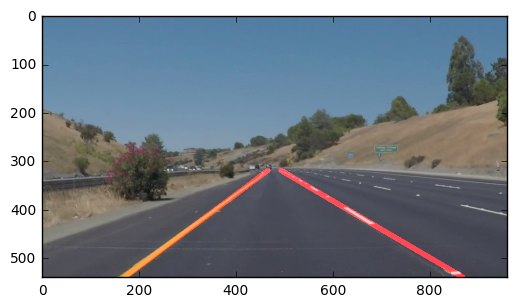

In [23]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!
### Pipeline Process
For creating a pipeline I defined a simple function that first saves the dimensions/shape of the image, then grayscales it and applies a Guassian Blur of Kernel size 5 and uses the Ostu's method for automatically calculating the low and high threshold for Canny edge detection and applies Hough Transform to detect the lines and draws it over. To mask only the lane area we define/hardcode the coordinates at which lanes are availables, since for this taks car never changes it's lane.

### Where it Fails
This pipeline will posssibly fail if car changes it's lane or slightly changes it's position within the lane as for now masking part is done using defining fixed coordinates

### How it can be made better

Well main bottleneck is HoughLines, if we can detect right parameters that could work we can improve it also if we use inRange to detect colors between White and Yellow and use that color selected area along for masking instead of fixed coordinates we can improve it. Also if we modify draw_line and Hough Transform to detect curves we can improve it for the challenge video as well

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Average right_slope average is  -0.6952982555
right line 1 (500, 320) (1149, 720)
left line 2 (928, 320) (352, 720)
Average right_slope average is  -0.681229794579
right line 1 (494, 320) (1149, 720)
left line 2 (801, 320) (214, 720)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

Average right_slope average is  -0.6952982555
right line 1 (500, 320) (1149, 720)
left line 2 (928, 320) (352, 720)



  0%|          | 1/251 [00:00<01:08,  3.65it/s]

Average right_slope average is  -0.681229794579
right line 1 (494, 320) (1149, 720)
left line 2 (801, 320) (214, 720)



  1%|          | 2/251 [00:00<01:06,  3.76it/s]

Average right_slope average is  -0.682071019362
right line 1 (497, 320) (1153, 720)
left line 2 (944, 320) (357, 720)
Average right_slope average is  -0.668160855736
right line 1 (494, 320) (1154, 720)
left line 2 (806, 320) (208, 720)



  1%|          | 3/251 [00:00<01:05,  3.79it/s]

Average right_slope average is  -0.661658583936
right line 1 (374, 320) (1077, 720)
left line 2 (916, 320) (312, 720)
Average right_slope average is  -0.691419398064
right line 1 (492, 320) (1159, 720)
left line 2 (796, 320) (218, 720)



  2%|▏         | 4/251 [00:01<01:04,  3.84it/s]

Average right_slope average is  -0.668308421882
right line 1 (535, 320) (1107, 720)
left line 2 (902, 320) (304, 720)
Average right_slope average is  -0.66827307509
right line 1 (520, 320) (1136, 720)
left line 2 (810, 320) (212, 720)



  2%|▏         | 5/251 [00:01<01:04,  3.84it/s]

Average right_slope average is  -0.683958705299
right line 1 (532, 320) (1104, 720)
left line 2 (918, 320) (333, 720)
Average right_slope average is  -0.675336317468
right line 1 (511, 320) (1140, 720)
left line 2 (807, 320) (215, 720)



  2%|▏         | 6/251 [00:01<01:02,  3.95it/s]

Average right_slope average is  -0.648345699419
right line 1 (508, 320) (1145, 720)
left line 2 (899, 320) (282, 720)
Average right_slope average is  -0.680338888758
right line 1 (504, 320) (1139, 720)
left line 2 (807, 320) (219, 720)



  3%|▎         | 7/251 [00:01<01:01,  3.99it/s]

Average right_slope average is  -0.685331940854
right line 1 (518, 320) (1136, 720)
left line 2 (898, 320) (314, 720)
Average right_slope average is  -0.68744801009
right line 1 (499, 320) (1152, 720)
left line 2 (804, 320) (223, 720)



  3%|▎         | 8/251 [00:02<01:02,  3.88it/s]

Average right_slope average is  -0.67066208311
right line 1 (504, 320) (1141, 720)
left line 2 (910, 320) (314, 720)
Average right_slope average is  -0.70720562399
right line 1 (509, 320) (1140, 720)
left line 2 (797, 320) (231, 720)



  4%|▎         | 9/251 [00:02<00:59,  4.06it/s]

Average right_slope average is  -0.683133830515
right line 1 (512, 320) (1134, 720)
left line 2 (919, 320) (334, 720)
Average right_slope average is  -0.713211206969
right line 1 (498, 320) (1151, 720)
left line 2 (794, 320) (233, 720)



  4%|▍         | 10/251 [00:02<01:00,  3.98it/s]

Average right_slope average is  -0.674103488296
right line 1 (506, 320) (1139, 720)
left line 2 (971, 320) (377, 720)
Average right_slope average is  -0.697316316938
right line 1 (504, 320) (1144, 720)
left line 2 (802, 320) (228, 720)



  4%|▍         | 11/251 [00:02<00:59,  4.02it/s]

Average right_slope average is  -0.675163608602
right line 1 (448, 320) (1118, 720)
left line 2 (936, 320) (343, 720)
Average right_slope average is  -0.713284274998
right line 1 (498, 320) (1156, 720)
left line 2 (796, 320) (235, 720)



  5%|▍         | 12/251 [00:03<01:00,  3.92it/s]

Average right_slope average is  -0.693259094536
right line 1 (498, 320) (1153, 720)
left line 2 (914, 320) (337, 720)
Average right_slope average is  -0.742255903648
right line 1 (491, 320) (1163, 720)
left line 2 (787, 320) (248, 720)



  5%|▌         | 13/251 [00:03<00:59,  4.01it/s]

Average right_slope average is  -0.689805666881
right line 1 (489, 320) (1159, 720)
left line 2 (928, 320) (348, 720)
Average right_slope average is  -0.720599760279
right line 1 (498, 320) (1157, 720)
left line 2 (793, 320) (238, 720)



  6%|▌         | 14/251 [00:03<00:56,  4.16it/s]

Average right_slope average is  -0.665514167128
right line 1 (495, 320) (1154, 720)
left line 2 (916, 320) (315, 720)
Average right_slope average is  -0.733631555767
right line 1 (501, 320) (1153, 720)
left line 2 (789, 320) (244, 720)
Average right_slope average is  -0.666028678646
right line 1 (501, 320) (1157, 720)
left line 2 


  6%|▌         | 15/251 [00:03<00:53,  4.44it/s]

(946, 320) (345, 720)
Average right_slope average is  -0.729411914756
right line 1 (498, 320) (1164, 720)
left line 2 (786, 320) (238, 720)
Average right_slope average is  -0.673639420411
right line 1 (519, 320) (1126, 720)
left line 2 (993, 320) (399, 720)
Average right_slope average is  -0.732975751778
right line 1 (506, 320) (1147, 720)
left line 2 (784, 320) (238, 720)



  7%|▋         | 17/251 [00:04<00:48,  4.79it/s]

Average right_slope average is  -0.666353879372
right line 1 (512, 320) (1131, 720)
left line 2 (910, 320) (310, 720)
Average right_slope average is  -0.733287352982
right line 1 (492, 320) (1151, 720)
left line 2 (787, 320) (242, 720)
Average right_slope average is  -0.693649725643
right line 1 (516, 320) (1129, 720)
left line 2 (904, 320) (327, 720)



  7%|▋         | 18/251 [00:04<00:48,  4.84it/s]

Average right_slope average is  -0.709553328379
right line 1 (482, 320) (1161, 720)
left line 2 (792, 320) (229, 720)
Average right_slope average is  -0.72847771141
right line 1 (484, 320) (1149, 720)
left line 2 (971, 320) (422, 720)
Average right_slope average is  -0.706939493667
right line 1 (484, 320) (1154, 720)
left line 2 (796, 320) (230, 720)



  8%|▊         | 20/251 [00:04<00:46,  4.99it/s]

Average right_slope average is  -0.679452573509
right line 1 (496, 320) (1141, 720)
left line 2 (920, 320) (331, 720)
Average right_slope average is  -0.713930612459
right line 1 (491, 320) (1150, 720)
left line 2 (793, 320) (232, 720)
Average right_slope average is  -0.657696015156
right line 1 (491, 320) (1145, 720)
left line 2 (928, 320) (320, 720)



  8%|▊         | 21/251 [00:04<00:46,  4.92it/s]

Average right_slope average is  -0.711811835311
right line 1 (498, 320) (1147, 720)
left line 2 (795, 320) (233, 720)
Average right_slope average is  -0.663302715201
right line 1 (504, 320) (1136, 720)
left line 2 (907, 320) (304, 720)



  9%|▉         | 22/251 [00:05<00:46,  4.90it/s]

Average right_slope average is  -0.712040426355
right line 1 (483, 320) (1162, 720)
left line 2 (792, 320) (230, 720)
Average right_slope average is  -0.676560302112
right line 1 (511, 320) (1140, 720)
left line 2 (936, 320) (345, 720)



  9%|▉         | 23/251 [00:05<00:48,  4.72it/s]

Average right_slope average is  -0.715937852399
right line 1 (461, 320) (1158, 720)
left line 2 (787, 320) (229, 720)
Average right_slope average is  -0.699237464736
right line 1 (486, 320) (1150, 720)
left line 2 (930, 320) (358, 720)
Average right_slope average is  -0.708892601903



 10%|▉         | 25/251 [00:05<00:46,  4.86it/s]

right line 1 (492, 320) (1147, 720)
left line 2 (792, 320) (228, 720)
Average right_slope average is  -0.701483546228
right line 1 (479, 320) (1156, 720)
left line 2 (903, 320) (333, 720)
Average right_slope average is  -0.72062994654
right line 1 (496, 320) (1149, 720)
left line 2 (788, 320) (233, 720)



 10%|█         | 26/251 [00:06<00:53,  4.19it/s]

Average right_slope average is  -0.669705588098
right line 1 (534, 320) (1139, 720)
left line 2 (908, 320) (311, 720)
Average right_slope average is  -0.72672733282
right line 1 (489, 320) (1152, 720)
left line 2 (788, 320) (237, 720)



 11%|█         | 27/251 [00:06<00:54,  4.15it/s]

Average right_slope average is  -0.685609627877
right line 1 (510, 320) (1128, 720)
left line 2 (933, 320) (350, 720)
Average right_slope average is  -0.749441985155
right line 1 (483, 320) (1157, 720)
left line 2 (777, 320) (243, 720)



 11%|█         | 28/251 [00:06<00:57,  3.88it/s]

Average right_slope average is  -0.695903820307
right line 1 (499, 320) (1149, 720)
left line 2 (885, 320) (310, 720)
Average right_slope average is  -0.709883231411
right line 1 (487, 320) (1149, 720)
left line 2 (791, 320) (227, 720)



 12%|█▏        | 29/251 [00:06<00:59,  3.76it/s]

Average right_slope average is  -0.688295928693
right line 1 (501, 320) (1143, 720)
left line 2 (905, 320) (324, 720)
Average right_slope average is  -0.733472237996
right line 1 (494, 320) (1147, 720)
left line 2 (785, 320) (239, 720)



 12%|█▏        | 30/251 [00:07<00:56,  3.88it/s]

Average right_slope average is  -0.671160338319
right line 1 (522, 320) (1119, 720)
left line 2 (939, 320) (343, 720)
Average right_slope average is  -0.720815372429
right line 1 (501, 320) (1136, 720)
left line 2 (787, 320) (232, 720)



 12%|█▏        | 31/251 [00:07<01:03,  3.49it/s]

Average right_slope average is  -0.687243567517
right line 1 (506, 320) (1133, 720)
left line 2 (979, 320) (397, 720)
Average right_slope average is  -0.719770658327
right line 1 (497, 320) (1142, 720)
left line 2 (786, 320) (230, 720)



 13%|█▎        | 32/251 [00:07<00:59,  3.69it/s]

Average right_slope average is  -0.685605123504
right line 1 (488, 320) (1146, 720)
left line 2 (891, 320) (307, 720)
Average right_slope average is  -0.718491788265
right line 1 (486, 320) (1151, 720)
left line 2 (790, 320) (233, 720)



 13%|█▎        | 33/251 [00:07<00:55,  3.91it/s]

Average right_slope average is  -0.686458015721
right line 1 (507, 320) (1129, 720)
left line 2 (939, 320) (356, 720)
Average right_slope average is  -0.724643675825
right line 1 (491, 320) (1141, 720)
left line 2 (786, 320) (234, 720)



 14%|█▎        | 34/251 [00:08<00:54,  4.01it/s]

Average right_slope average is  -0.690890016177
right line 1 (511, 320) (1196, 720)
left line 2 (937, 320) (358, 720)
Average right_slope average is  -0.682991672857
right line 1 (481, 320) (1146, 720)
left line 2 (802, 320) (216, 720)



 14%|█▍        | 35/251 [00:08<00:52,  4.10it/s]

Average right_slope average is  -0.6651150397
right line 1 (497, 320) (1135, 720)
left line 2 (880, 320) (279, 720)
Average right_slope average is  -0.695330380297
right line 1 (479, 320) (1156, 720)
left line 2 (797, 320) (222, 720)



 14%|█▍        | 36/251 [00:08<00:51,  4.14it/s]

Average right_slope average is  -0.679289389482
right line 1 (481, 320) (1148, 720)
left line 2 (883, 320) (294, 720)
Average right_slope average is  -0.679540509072
right line 1 (464, 320) (1174, 720)
left line 2 (804, 320) (215, 720)



 15%|█▍        | 37/251 [00:08<00:51,  4.18it/s]

Average right_slope average is  -0.695629306895
right line 1 (511, 320) (1159, 720)
left line 2 (879, 320) (304, 720)
Average right_slope average is  -0.68342575519
right line 1 (479, 320) (1167, 720)
left line 2 (800, 320) (215, 720)



 15%|█▌        | 38/251 [00:09<00:54,  3.89it/s]

Average right_slope average is  -0.670400336342
right line 1 (511, 320) (1215, 720)
left line 2 (878, 320) (282, 720)
Average right_slope average is  -0.668105255994
right line 1 (463, 320) (1195, 720)
left line 2 (805, 320) (206, 720)



 16%|█▌        | 39/251 [00:09<00:58,  3.64it/s]

Average right_slope average is  -0.688456424779
right line 1 (501, 320) (1147, 720)
left line 2 (864, 320) (283, 720)
Average right_slope average is  -0.675731820841
right line 1 (468, 320) (1208, 720)
left line 2 (803, 320) (211, 720)



 16%|█▌        | 40/251 [00:09<00:57,  3.70it/s]

Average right_slope average is  -0.676625505081
right line 1 (518, 320) (1115, 720)
left line 2 (890, 320) (299, 720)
Average right_slope average is  -0.678716000755
right line 1 (469, 320) (1181, 720)
left line 2 (803, 320) (213, 720)



 16%|█▋        | 41/251 [00:10<00:59,  3.53it/s]

Average right_slope average is  -0.66365217688
right line 1 (513, 320) (1128, 720)
left line 2 (850, 320) (248, 720)
Average right_slope average is  -0.673683516306
right line 1 (464, 320) (1182, 720)
left line 2 (805, 320) (211, 720)



 17%|█▋        | 42/251 [00:10<01:01,  3.38it/s]

Average right_slope average is  -0.669249456084
right line 1 (556, 320) (1332, 720)
left line 2 (841, 320) (243, 720)
Average right_slope average is  -0.676511898542
right line 1 (459, 320) (1154, 720)
left line 2 (805, 320) (214, 720)



 17%|█▋        | 43/251 [00:10<01:06,  3.14it/s]

Average right_slope average is  -0.668391460156
right line 1 (487, 320) (1186, 720)
left line 2 (841, 320) (242, 720)
Average right_slope average is  -0.671591492422
right line 1 (452, 320) (1203, 720)
left line 2 (809, 320) (213, 720)



 18%|█▊        | 44/251 [00:11<01:07,  3.07it/s]

Average right_slope average is  -0.660285462529
right line 1 (483, 320) (1156, 720)
left line 2 (840, 320) (235, 720)
Average right_slope average is  -0.668163006432
right line 1 (469, 320) (1181, 720)
left line 2 (812, 320) (214, 720)



 18%|█▊        | 45/251 [00:11<01:05,  3.16it/s]

Average right_slope average is  -0.676616647775
right line 1 (519, 320) (1219, 720)
left line 2 (847, 320) (256, 720)
Average right_slope average is  -0.670289302427
right line 1 (453, 320) (1194, 720)
left line 2 (812, 320) (216, 720)



 18%|█▊        | 46/251 [00:11<01:01,  3.36it/s]

Average right_slope average is  -0.672430767003
right line 1 (535, 320) (1269, 720)
left line 2 (830, 320) (235, 720)
Average right_slope average is  -0.664966941365
right line 1 (457, 320) (1184, 720)
left line 2 (818, 320) (216, 720)



 19%|█▊        | 47/251 [00:11<00:56,  3.59it/s]

Average right_slope average is  -0.674672572691
right line 1 (541, 320) (1188, 720)
left line 2 (838, 320) (245, 720)
Average right_slope average is  -0.700263700264
right line 1 (446, 320) (1183, 720)
left line 2 (800, 320) (229, 720)



 19%|█▉        | 48/251 [00:12<00:56,  3.57it/s]

Average right_slope average is  -0.688876508532
right line 1 (526, 320) (1204, 720)
left line 2 (833, 320) (252, 720)
Average right_slope average is  -0.692049996228
right line 1 (447, 320) (1187, 720)
left line 2 (805, 320) (227, 720)



 20%|█▉        | 49/251 [00:12<00:55,  3.64it/s]

Average right_slope average is  -0.669957126792
right line 1 (531, 320) (1225, 720)
left line 2 (825, 320) (228, 720)
Average right_slope average is  -0.715625804115
right line 1 (426, 320) (1186, 720)
left line 2 (795, 320) (236, 720)



 20%|█▉        | 50/251 [00:12<00:53,  3.74it/s]

Average right_slope average is  -0.671023207545
right line 1 (626, 320) (1386, 720)
left line 2 (835, 320) (239, 720)
Average right_slope average is  -0.704871409292
right line 1 (441, 320) (1166, 720)
left line 2 (799, 320) (231, 720)



 20%|██        | 51/251 [00:12<00:54,  3.69it/s]

Average right_slope average is  -0.671133578693
right line 1 (656, 320) (1341, 720)
left line 2 (832, 320) (236, 720)
Average right_slope average is  -0.67865014631
right line 1 (444, 320) (1207, 720)
left line 2 (810, 320) (221, 720)



 21%|██        | 52/251 [00:13<00:54,  3.63it/s]

Average right_slope average is  -0.667742293422
right line 1 (634, 320) (1429, 720)
left line 2 (836, 320) (237, 720)
Average right_slope average is  -0.724219288077
right line 1 (423, 320) (1238, 720)
left line 2 (789, 320) (237, 720)



 21%|██        | 53/251 [00:13<01:00,  3.30it/s]

Average right_slope average is  -0.669215031864
right line 1 (624, 320) (1325, 720)
left line 2 (825, 320) (228, 720)
Average right_slope average is  -0.698637150787
right line 1 (432, 320) (1220, 720)
left line 2 (805, 320) (233, 720)



 22%|██▏       | 54/251 [00:13<01:01,  3.21it/s]

Average right_slope average is  -0.683627943786
right line 1 (659, 320) (1393, 720)
left line 2 (833, 320) (248, 720)
Average right_slope average is  -0.713171018784
right line 1 (445, 320) (1204, 720)
left line 2 (791, 320) (230, 720)



 22%|██▏       | 55/251 [00:14<01:03,  3.09it/s]

Average right_slope average is  -0.67740169303
right line 1 (572, 320) (1249, 720)
left line 2 (812, 320) (222, 720)
Average right_slope average is  -0.716367487969
right line 1 (440, 320) (1185, 720)
left line 2 (794, 320) (235, 720)


Average right_slope average is  -0.696275211451
right line 1 (656, 320) (1330, 720)
left line 2 (790, 320) (216, 720)
Average right_slope average is  -0.719179613278
right line 1 (429, 320) (1224, 720)
left line 2 (790, 320) (234, 720)



 23%|██▎       | 57/251 [00:14<01:05,  2.96it/s]

Average right_slope average is  -0.682681253455
right line 1 (631, 320) (1362, 720)
left line 2 (808, 320) (222, 720)
Average right_slope average is  -0.698656727055
right line 1 (424, 320) (1195, 720)
left line 2 (801, 320) (228, 720)



 23%|██▎       | 58/251 [00:15<01:08,  2.82it/s]

Average right_slope average is  -0.683329497147
right line 1 (612, 320) (1268, 720)
left line 2 (824, 320) (239, 720)
Average right_slope average is  -0.72333242825
right line 1 (456, 320) (1168, 720)
left line 2 (787, 320) (234, 720)



 24%|██▎       | 59/251 [00:15<01:02,  3.09it/s]

Average right_slope average is  -0.697398129897
right line 1 (600, 320) (1324, 720)
left line 2 (799, 320) (225, 720)
Average right_slope average is  -0.694449350719
right line 1 (422, 320) (1163, 720)
left line 2 (805, 320) (229, 720)



 24%|██▍       | 60/251 [00:15<00:58,  3.25it/s]

Average right_slope average is  -0.712026648779
right line 1 (624, 320) (1355, 720)
left line 2 (797, 320) (235, 720)
Average right_slope average is  -0.708924134626
right line 1 (433, 320) (1151, 720)
left line 2 (794, 320) (230, 720)



 24%|██▍       | 61/251 [00:16<00:57,  3.28it/s]

Average right_slope average is  -0.677252217229
right line 1 (612, 320) (1326, 720)
left line 2 (771, 320) (181, 720)
Average right_slope average is  -0.708529735571
right line 1 (467, 320) (1160, 720)
left line 2 (793, 320) (229, 720)



 25%|██▍       | 62/251 [00:16<00:53,  3.50it/s]

Average right_slope average is  -0.71930138672
right line 1 (690, 320) (1482, 720)
left line 2 (787, 320) (231, 720)
Average right_slope average is  -0.682323600593
right line 1 (444, 320) (1155, 720)
left line 2 (802, 320) (216, 720)



 25%|██▌       | 63/251 [00:16<00:52,  3.58it/s]

Average right_slope average is  -0.672499608694
right line 1 (687, 320) (1477, 720)
left line 2 (750, 320) (155, 720)
Average right_slope average is  -0.675406894581
right line 1 (376, 320) (1261, 720)
left line 2 (811, 320) (219, 720)



 25%|██▌       | 64/251 [00:16<00:52,  3.57it/s]

Average right_slope average is  -0.682275141181
right line 1 (653, 320) (1414, 720)
left line 2 (769, 320) (182, 720)
Average right_slope average is  -0.690804529184
right line 1 (409, 320) (1209, 720)
left line 2 (800, 320) (221, 720)



 26%|██▌       | 65/251 [00:17<00:52,  3.54it/s]

Average right_slope average is  -0.67559203285
right line 1 (665, 320) (1344, 720)
left line 2 (698, 320) (106, 720)
Average right_slope average is  -0.679670409682
right line 1 (474, 320) (1165, 720)
left line 2 (807, 320) (218, 720)



 26%|██▋       | 66/251 [00:17<00:50,  3.63it/s]

Average right_slope average is  -0.70305824257
right line 1 (713, 320) (1507, 720)
left line 2 (738, 320) (169, 720)
Average right_slope average is  -0.668203654245
right line 1 (396, 320) (1178, 720)
left line 2 (816, 320) (218, 720)



 27%|██▋       | 67/251 [00:17<00:50,  3.63it/s]

Average right_slope average is  -0.722941797752
right line 1 (707, 320) (1495, 720)
left line 2 (800, 320) (247, 720)
Average right_slope average is  -0.672136999959
right line 1 (462, 320) (1168, 720)
left line 2 (815, 320) (220, 720)



 27%|██▋       | 68/251 [00:18<00:52,  3.47it/s]

Average right_slope average is  -0.677229598615
right line 1 (699, 320) (1451, 720)
left line 2 (691, 320) (101, 720)
Average right_slope average is  -0.709688805519
right line 1 (381, 320) (1207, 720)
left line 2 (728, 320) (164, 720)



 27%|██▋       | 69/251 [00:18<00:51,  3.54it/s]

Average right_slope average is  -0.662453626771
right line 1 (712, 320) (1491, 720)
left line 2 (755, 320) (151, 720)
Average right_slope average is  -0.678161757391
right line 1 (434, 320) (1218, 720)
left line 2 (811, 320) (221, 720)



 28%|██▊       | 70/251 [00:18<00:52,  3.44it/s]

Average right_slope average is  -0.687498366144
right line 1 (716, 320) (1483, 720)
left line 2 (704, 320) (122, 720)
Average right_slope average is  -0.708193080737
right line 1 (395, 320) (1202, 720)
left line 2 (803, 320) (238, 720)



 28%|██▊       | 71/251 [00:19<00:52,  3.44it/s]

Average right_slope average is  -0.692965812674
right line 1 (760, 320) (1563, 720)
left line 2 (751, 320) (174, 720)
Average right_slope average is  -0.725923763393
right line 1 (420, 320) (1215, 720)
left line 2 (740, 320) (189, 720)



 29%|██▊       | 72/251 [00:19<00:53,  3.33it/s]

Average right_slope average is  -0.709006972739
right line 1 (718, 320) (1502, 720)
left line 2 (806, 320) (242, 720)
Average right_slope average is  -0.681863154483
right line 1 (400, 320) (1183, 720)
left line 2 (813, 320) (226, 720)



 29%|██▉       | 73/251 [00:19<00:53,  3.33it/s]

Average right_slope average is  -0.730862096945
right line 1 (723, 320) (1489, 720)
left line 2 (735, 320) (188, 720)
Average right_slope average is  -0.711618411835
right line 1 (463, 320) (1190, 720)
left line 2 (800, 320) (238, 720)



 29%|██▉       | 74/251 [00:19<00:53,  3.33it/s]

Average right_slope average is  -0.701803936362
right line 1 (760, 320) (1502, 720)
left line 2 (760, 320) (190, 720)
Average right_slope average is  -0.729556581652
right line 1 (428, 320) (1192, 720)
left line 2 (795, 320) (247, 720)



 30%|██▉       | 75/251 [00:20<00:53,  3.32it/s]

Average right_slope average is  -0.686420943901
right line 1 (786, 320) (1564, 720)
left line 2 (596, 320) (13, 720)
Average right_slope average is  -0.717655093181
right line 1 (426, 320) (1253, 720)
left line 2 (801, 320) (243, 720)



 30%|███       | 76/251 [00:20<00:57,  3.07it/s]

Average right_slope average is  -0.727185714509
right line 1 (732, 320) (1500, 720)
left line 2 (797, 320) (247, 720)
Average right_slope average is  -0.736159763232
right line 1 (425, 320) (1251, 720)
left line 2 (795, 320) (252, 720)



 31%|███       | 77/251 [00:20<00:58,  2.95it/s]

Average right_slope average is  -0.722538348216
right line 1 (763, 320) (1518, 720)
left line 2 (482, 320) (-70, 720)
Average right_slope average is  -0.739515958613
right line 1 (464, 320) (1189, 720)
left line 2 (791, 320) (250, 720)



 31%|███       | 78/251 [00:21<00:59,  2.89it/s]

Average right_slope average is  -0.695995061311
right line 1 (774, 320) (1575, 720)
left line 2 (621, 320) (46, 720)
Average right_slope average is  -0.717100060318
right line 1 (475, 320) (1181, 720)
left line 2 (803, 320) (245, 720)



 31%|███▏      | 79/251 [00:21<00:59,  2.89it/s]

Average right_slope average is  -0.730784633373
right line 1 (733, 320) (1518, 720)
left line 2 (445, 320) (-102, 720)
Average right_slope average is  -0.718319978068
right line 1 (463, 320) (1203, 720)
left line 2 (802, 320) (245, 720)



 32%|███▏      | 80/251 [00:22<00:59,  2.86it/s]

Average right_slope average is  -0.681513042596
right line 1 (782, 320) (1573, 720)
left line 2 (335, 320) (-251, 720)
Average right_slope average is  -0.753055574566
right line 1 (487, 320) (1180, 720)
left line 2 (788, 320) (257, 720)



 32%|███▏      | 81/251 [00:22<01:00,  2.81it/s]

Average right_slope average is  -0.692870392222
right line 1 (742, 320) (1548, 720)
left line 2 (348, 320) (-228, 720)
Average right_slope average is  -0.75056442455
right line 1 (477, 320) (1194, 720)
left line 2 (791, 320) (258, 720)



 33%|███▎      | 82/251 [00:22<01:02,  2.72it/s]

Average right_slope average is  -0.733913885919
right line 1 (709, 320) (1527, 720)
left line 2 (300, 320) (-244, 720)
Average right_slope average is  -0.756900849053
right line 1 (470, 320) (1193, 720)
left line 2 (788, 320) (259, 720)



 33%|███▎      | 83/251 [00:23<01:00,  2.79it/s]

Average right_slope average is  -0.68398142217
right line 1 (702, 320) (1482, 720)
left line 2 (231, 320) (-353, 720)
Average right_slope average is  -0.730399261266
right line 1 (482, 320) (1180, 720)
left line 2 (797, 320) (249, 720)



 33%|███▎      | 84/251 [00:23<00:59,  2.79it/s]

Average right_slope average is  -0.710777367892
right line 1 (820, 320) (1624, 720)
left line 2 (424, 320) (-138, 720)
Average right_slope average is  -0.748843367802
right line 1 (465, 320) (1198, 720)
left line 2 (789, 320) (254, 720)



 34%|███▍      | 85/251 [00:23<01:02,  2.64it/s]

Average right_slope average is  -0.711203181554
right line 1 (723, 320) (1521, 720)
left line 2 (357, 320) (-204, 720)
Average right_slope average is  -0.744112177805
right line 1 (483, 320) (1185, 720)
left line 2 (794, 320) (256, 720)



 34%|███▍      | 86/251 [00:24<01:03,  2.62it/s]

Average right_slope average is  -0.714621172924
right line 1 (671, 320) (1477, 720)
left line 2 (371, 320) (-188, 720)
Average right_slope average is  -0.749705899366
right line 1 (449, 320) (1226, 720)
left line 2 (790, 320) (256, 720)



 35%|███▍      | 87/251 [00:24<00:59,  2.75it/s]

Average right_slope average is  -0.678358349161
right line 1 (685, 320) (1476, 720)
left line 2 (230, 320) (-359, 720)
Average right_slope average is  -0.744104718248
right line 1 (501, 320) (1167, 720)
left line 2 (793, 320) (256, 720)



 35%|███▌      | 88/251 [00:25<00:59,  2.73it/s]

Average right_slope average is  -0.726885186883
right line 1 (670, 320) (1485, 720)
left line 2 (337, 320) (-212, 720)
Average right_slope average is  -0.767366937154
right line 1 (433, 320) (1213, 720)
left line 2 (791, 320) (269, 720)



 35%|███▌      | 89/251 [00:25<00:56,  2.86it/s]

Average right_slope average is  -0.690677446086
right line 1 (626, 320) (1418, 720)
left line 2 (266, 320) (-312, 720)
Average right_slope average is  -0.682362668751
right line 1 (486, 320) (1172, 720)
left line 2 (703, 320) (116, 720)



 36%|███▌      | 90/251 [00:25<00:54,  2.98it/s]

Average right_slope average is  -0.687128841982
right line 1 (663, 320) (1482, 720)
left line 2 (460, 320) (-121, 720)
Average right_slope average is  -0.717266529136
right line 1 (486, 320) (1170, 720)
left line 2 (722, 320) (165, 720)



 36%|███▋      | 91/251 [00:25<00:51,  3.09it/s]

Average right_slope average is  -0.708312728449
right line 1 (666, 320) (1485, 720)
left line 2 (418, 320) (-145, 720)
Average right_slope average is  -0.760861190772
right line 1 (487, 320) (1173, 720)
left line 2 (658, 320) (132, 720)



 37%|███▋      | 92/251 [00:26<00:52,  3.05it/s]

Average right_slope average is  -0.70202724513
right line 1 (625, 320) (1405, 720)
left line 2 (344, 320) (-225, 720)
Average right_slope average is  -0.766839378238
right line 1 (444, 320) (1203, 720)
left line 2 (781, 320) (259, 720)



 37%|███▋      | 93/251 [00:26<00:52,  3.03it/s]

Average right_slope average is  -0.708482619277
right line 1 (604, 320) (1383, 720)
left line 2 (447, 320) (-117, 720)
Average right_slope average is  -0.691954788993
right line 1 (454, 320) (1195, 720)
left line 2 (695, 320) (117, 720)



 37%|███▋      | 94/251 [00:26<00:49,  3.16it/s]

Average right_slope average is  -0.683835659928
right line 1 (648, 320) (1457, 720)
left line 2 (808, 320) (223, 720)
Average right_slope average is  -0.776589302119
right line 1 (462, 320) (1190, 720)
left line 2 (697, 320) (182, 720)



 38%|███▊      | 95/251 [00:27<00:47,  3.25it/s]

Average right_slope average is  -0.669658977429
right line 1 (629, 320) (1413, 720)
left line 2 (783, 320) (186, 720)
Average right_slope average is  -0.795698924731
right line 1 (465, 320) (1199, 720)
left line 2 (769, 320) (266, 720)


Average right_slope average is  -0.680912048903
right line 1 (639, 320) (1479, 720)
left line 2 (804, 320) (216, 720)
Average right_slope average is  nan
right line 1 (438, 320) (1205, 720)


ValueError: cannot convert float NaN to integer

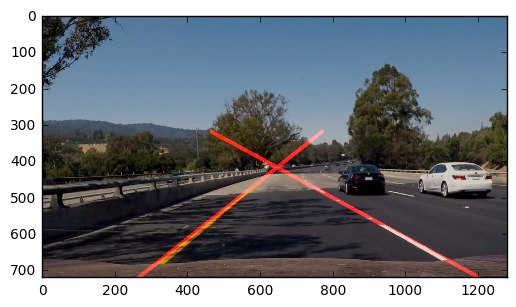

In [11]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))